### JCDSBDGPM10+AM08 FINAL PROJECT DATA SCIENCE & MACHINE LEARNING Topic BANK MARKETING CAMPAIGN

DELTA GROUP:

- Alifsya Salam
- Salma Almira Kuswihandono
- Wahyu Eki Sepriansyah

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, TunedThresholdClassifierCV
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, fbeta_score, average_precision_score, precision_recall_curve, auc, make_scorer
from xgboost import XGBClassifier

# Save Best Model
import pickle

import shap

from datetime import datetime

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

/home/aliert0918/.conda/envs/imbalance_kelas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### BUSINESS PROBLEM UNDERSTANDING

#### ****Problem Definition & Business Understanding****

##### ****Latar Belakang & Relevansi Bisnis****
Institusi perbankan seringkali mengandalkan kampanye pemasaran langsung (seperti telemarketing) untuk menawarkan produk investasi, salah satunya adalah Deposito Berjangka (Term Deposit). Deposito itu sendiri menjadi salah satu sumber dana likuid bagi bank yang sangat penting untuk diputar kembali menjadi pinjaman.

Masalah utamanya: Melakukan panggilan telepon ke seluruh nasabah adalah strategi yang terkadang tidak selalu tepat sasaran, memakan waktu, dan tidak efisien. Berdasarkan data awal dari dataset yang diterima, tingkat konversi (nasabah yang menyetujui deposito dengan indikator sesuai datasetnya "Ya") hanya sekitar 11%. Artinya, 89% panggilan telepon berakhir sia-sia karena ditolak nasabah. Relevansi bisnisnya adalah bagaimana bank bisa menekan biaya operasional pemasaran namun tetap mendapatkan jumlah nasabah yang maksimal berdasarkan jumlah data nasabah yang menyetujui kampanye deposito.

##### ****Problem Statement, Goals, & Stakeholders****
Problem Statement: Rendahnya tingkat efisiensi kampanye pemasaran di mana tim marketing menghubungi banyak nasabah yang sebenarnya tidak tertarik. Target spesifiknya adalah menurunkan tingkat false alarm (menghubungi orang yang tidak tertarik) dan meningkatkan conversion rate melalui pendekatan berbasis data.

Project Goals: Membangun model klasifikasi yang mampu memprediksi probabilitas seorang nasabah akan berlangganan deposito berjangka dengan skor evaluasi minimal F1-Score > 0.6 untuk memastikan keseimbangan antara presisi dan jangkauan (recall).

##### ****Stakeholders****
Bisnis model yang nantinya dibuat ini berguna untuk menjadi acuan bagi stakeholder untuk menentukan arah marketing terkait kampanye yang akan dilakukan untuk ditindaklanjuti oleh telemarketing. Berikut stakeholders yang dapat memanfaatkan hasil dari bisnis model yang dibuat:

Marketing Manager: Untuk merencanakan strategi kampanye yang lebih efektif dengan berkolaborasi dengan tim sales/telemarketing.

Tim Sales/Telemarketing: Sebagai pengguna akhir yang mendapatkan daftar prioritas nasabah yang harus dihubungi berdasarkan kemungkinan menyetujui pemasaran terkait deposito.

Departemen Keuangan: Terkait efisiensi anggaran operasional pemasaran.

#### ****Cost-Benefit Analysis****

| Aktual \ Prediksi | **Prediksi: Tertarik (Positive)**<br>*(Hubungi Nasabah)* | **Prediksi: Tidak Tertarik (Negative)**<br>*(Jangan Hubungi)* |
| :--- | :--- | :--- |
| **Aktual: Ya (Tertarik)** | **True Positive (TP)**<br>**Benefit: +$100/nasabah**<br>• Bank mendapatkan nasabah baru.<br>• Pendapatan bunga dari deposito/kredit masuk.<br>• Peningkatan aset bank dari hasil telemarketing. | **False Negative (FN)**<br>**Deficit: -$100(kehilangan nasabah potensial)**<br>• Kehilangan calon nasabah potensial.<br>• Hilangnya potensi pendapatan karena tidak dihubungi.<br>• Nasabah mungkin diambil bank kompetitor. |
| **Aktual: Tidak (Menolak)** | **False Positive (FP)**<br>**Cost: -$25/call**<br>• Pemborosan biaya operasional (biaya telepon/listrik).<br>• Waktu agen sales terbuang sia-sia.<br>• Risiko nasabah merasa terganggu. | **True Negative (TN)**<br> **Benefit: $0 (menghindari biaya operasional telemarketing)** <br>• Penghematan biaya operasional.<br>• Efisiensi waktu kerja agen.<br>• Tidak menghubungi orang yang pasti menolak. |

### ****Evaluasi Metrik Utama: F1-Score****
Mengingat karakteristik dataset *Bank Marketing* yang sangat tidak seimbang (*imbalanced*), di mana jumlah nasabah yang berlangganan deposito (kelas positif) jauh lebih sedikit dibandingkan yang tidak, penggunaan metrik akurasi (accuracy) tidak akan memberikan gambaran performa yang representatif.

Oleh karena itu, fokus evaluasi model ini ditetapkan pada **F1-Score**.

### Mengapa F1-Score?
F1-Score dipilih karena kemampuannya menjaga keseimbangan harmonis antara **Precision** dan **Recall**:

1.  **Precision (Efisiensi Biaya):** Kita ingin meminimalkan *False Positive* (menghubungi nasabah yang tidak tertarik), karena setiap panggilan yang gagal memiliki biaya operasional (biaya telepon/waktu agen).
2.  **Recall (Penangkapan Peluang):** Kita ingin meminimalkan *False Negative* (melewatkan nasabah potensial), karena setiap nasabah yang terlewat berarti hilangnya potensi pendapatan deposito bagi bank.

$$ F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

Nilai F1-Score yang tinggi mengindikasikan bahwa model mampu menyeleksi calon nasabah potensial dengan tepat (hemat biaya) tanpa kehilangan terlalu banyak peluang bisnis.

---

### Prioritas Bisnis: Efisiensi Operasional

Berdasarkan diskusi dengan stakeholder, **prioritas utama** kampanye ini adalah:

> **"Memaksimalkan efisiensi setiap telepon yang dilakukan, sehingga tim telemarketing hanya menghubungi nasabah dengan probabilitas konversi tinggi."**

**Alasan Bisnis:**
1. **Biaya Operasional Tinggi**: Setiap panggilan memerlukan biaya pulsa, waktu agen, dan overhead operasional
2. **Kapasitas Terbatas**: Tim telemarketing memiliki kapasitas terbatas per hari (~50-100 calls/agent)
3. **Customer Experience**: Terlalu sering menghubungi nasabah yang tidak tertarik seringkali membuat nasabah tidak nyaman
4. **ROI Kampanye**: Manajemen ingin memastikan setiap dolar yang dikeluarkan menghasilkan konversi maksimal

---

#### ****Key Insights (Initial Findings)****

Berdasarkan analisis awal pada dataset, terdapat beberapa poin kunci yang menjadi dasar pengembangan solusi:

Segmentasi Usia & Pekerjaan: Kelompok nasabah yang sudah pensiun (retired) dan pelajar (student) memiliki tingkat kesuksesan konversi yang jauh lebih tinggi dibandingkan pekerja kasar (blue-collar).

Faktor Makro Ekonomi: Keputusan nasabah sangat sensitif terhadap suku bunga (Euribor 3m). Saat suku bunga tinggi, perilaku nasabah dalam memilih deposito cenderung berubah.

Efektivitas Kampanye: Nasabah yang sudah terlalu sering dihubungi dalam satu kampanye (kolom campaign dengan value yang tinggi) cenderung menunjukkan respon negatif. Ada titik jenuh di mana penambahan jumlah kontak tidak lagi meningkatkan peluang konversi.

##### ****Dampak Solusi****
Dengan model ini, tim marketing tidak lagi menelepon secara acak. Mereka hanya akan menghubungi nasabah yang diprediksi "High Probability" atau memiliki kemungkinan menyetujui hasil telemarketing dari pemasaran deposito, sehingga ROI (Return on Investment) kampanye yang dikelola tim marketing manager dan dilaksanakan tim sales/telemarketing meningkat secara signifikan.

##### ****Konteks Domain Bisnis, Sumber Data, & Batasan Project****
Konteks Domain Bisnis: Perbankan Ritel & Manajemen Hubungan Pelanggan (CRM). Keputusan nasabah dapat dipengaruhi oleh profil pribadi (usia, pekerjaan), interaksi sebelumnya, serta kondisi ekonomi makro (suku bunga, inflasi) sebagai salah satu probabilitas terjadinya konversi kemungkinan untuk menyetujui deposito yang ditawarkan telemarketer.

Sumber Data: dataset diperoleh dari situs kaggle https://www.kaggle.com/datasets/volodymyrgavrysh/bank-marketing-campaigns-dataset dimana pembuat dataset mengambil data secara spesifik dari data Portuguese Banking Institution (sering disebut UCI Bank Marketing Dataset) sekitar bulan Mei 2008 sampai November 2010. Data mencakup 41.188 baris dengan 20 fitur yang mencakup profil nasabah hingga indikator ekonomi nasional.

##### ****Batasan & Asumsi****

Batasan: Kolom duration (durasi telepon) harus dikeluarkan saat proses training model. Mengapa? Karena durasi telepon hanya diketahui setelah telepon berakhir. Model tidak akan berguna jika model tersebut butuh tahu berapa lama telepon berlangsung sebelum telepon terhadap nasabah dilakukan.

Asumsi: Kondisi ekonomi yang tercatat dalam data (Euribor, indeks harga konsumen) dianggap masih relevan dengan pola perilaku nasabah saat ini.

Kualitas Data: Nilai "unknown" dalam data kategorikal diasumsikan sebagai informasi yang hilang secara acak.

In [2]:
base_dir = "/home/aliert0918/Unduhan/bank-additional/"

In [3]:
bank_marketing = base_dir + "bank-additional-full.csv"
df=pd.read_csv(bank_marketing, delimiter=';')
df

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campaign  pdays  previous  \
0      telephone   may         mon       261         1    999         0   
1      telephone   may         mon       149         1    999         0   
2      telephone   may         mon       226         1    999         0   
3      telephone   may         mon       151         1    999         0   
4      telephone   may         mon       307         1    999         0   
...          ...   ...         ...       ...       ...    ...       ...   
41183   cellular   nov         fri       334         1    999         0   
41184   cellular   nov         fri       383         1    999         0   
41185   cellular   nov         fri       189         2    999         0   
41186   cellular   nov         fri       442         1    999         0   
41187   cellular   nov         fri       239         3    999         1   

          poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent           1.1          93.994          -36.4      4.857   
1      nonexistent           1.1          93.994          -36.4      4.857   
2      nonexistent           1.1          93.994          -36.4      4.857   
3      nonexistent           1.1          93.994          -36.4      4.857   
4      nonexistent           1.1          93.994          -36.4      4.857   
...            ...           ...             ...            ...        ...   
41183  nonexistent          -1.1          94.767          -50.8      1.028   
41184  nonexistent          -1.1          94.767          -50.8      1.028   
41185  nonexistent          -1.1          94.767          -50.8      1.028   
41186  nonexistent          -1.1          94.767          -50.8      1.028   
41187      failure          -1.1          94.767          -50.8      1.028   

       nr.employed    y  
0           5191.0   no  
1           5191.0   no  
2           5191.0   no  
3           5191.0   no  
4           5191.0   no  
...            ...  ...  
41183       4963.6  yes  
41184       4963.6   no  
41185       4963.6   no  
41186       4963.6  yes  
41187       4963.6   no  

[41188 rows x 21 columns]

# Data Understanding - Bank Marketing Dataset

Dataset ini berisi informasi kampanye pemasaran deposito berjangka dari sebuah institusi bank. Berikut adalah ringkasan seluruh kolom dalam dataset:

| Nama Kolom | Jenis Data | Deskripsi Kontekstual |
| :--- | :--- | :--- |
| **age** | Numeric | Usia nasabah. |
| **job** | Cat | Jenis pekerjaan (admin, blue-collar, technician, dll). |
| **marital** | Cat | Status pernikahan (married, single, divorced, unknown). |
| **education** | Cat | Pendidikan terakhir (basic, high.school, university.degree, dll). |
| **default** | Cat | Memiliki kredit macet? (no, yes, unknown). |
| **housing** | Cat | Memiliki pinjaman perumahan atau KPR? (no, yes, unknown). |
| **loan** | Cat | Memiliki pinjaman pribadi? (no, yes, unknown). |
| **contact** | Cat | Metode komunikasi (cellular, telephone). |
| **month** | Cat | Bulan terakhir kontak (may, jun, jul, dll). |
| **day_of_week** | Cat | Hari terakhir kontak (mon, tue, wed, thu, fri). |
| **duration** | Numeric | Durasi nasabah dihubungi oleh telemarketer dalam hitungan detik. *Catatan: Sangat mempengaruhi target.* |
| **campaign** | Numeric | Berapa kali Nasabah dihubungi oleh telemarketer selama kampanye berlangsung. |
| **pdays** | Numeric | Hari berlalu setelah dihubungi saat kampanye berlangsung (999 = belum pernah). |
| **previous** | Numeric | Jumlah kontak sebelum kampanye ini dilakukan. |
| **poutcome** | Cat | Hasil kampanye sebelumnya (failure, nonexistent, success). |
| **emp.var.rate** | Numeric | Indikator ekonomi: Tingkat variasi lapangan kerja. |
| **cons.price.idx** | Numeric | Indikator ekonomi: Indeks harga konsumen. Mengukur perubahan rata-rata harga barang maupun jasa|
| **cons.conf.idx** | Numeric | Indikator ekonomi: Indeks kepercayaan konsumen. Mengukur tingkat daya beli masyarakat|
| **euribor3m** | Numeric | Indikator ekonomi: Suku bunga Euribor 3 bulan. |
| **nr.employed** | Numeric | Indikator ekonomi: Jumlah karyawan (sosial ekonomi). |
| **y (Target)** | Binary | Apakah nasabah jadi berlangganan deposito? (**yes** atau **no**). |

In [4]:
listItem = []
for col in df.columns:
    listItem.append([
        col,                                # Nama Kolom
        df[col].nunique(),                  # Jumlah Unique Values
        df[col].unique().tolist()           # Menampilkan semua value unik dalam list
    ])

dfDesc = pd.DataFrame(columns=['Column Name', 'Unique Count', 'All Unique Values'],
                     data=listItem)
pd.set_option('display.max_colwidth',1)
dfDesc

Column Name  Unique Count  \
0   age             78             
1   job             12             
2   marital         4              
3   education       8              
4   default         3              
5   housing         3              
6   loan            3              
7   contact         2              
8   month           10             
9   day_of_week     5              
10  duration        1544           
11  campaign        42             
12  pdays           27             
13  previous        8              
14  poutcome        3              
15  emp.var.rate    10             
16  cons.price.idx  26             
17  cons.conf.idx   26             
18  euribor3m       316            
19  nr.employed     11             
20  y               2              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   All Unique Values  
0   [56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55, 49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36, 28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95, 77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81, 74, 17, 87, 91, 86, 98, 94, 84, 92, 89]                                                                                                                                                                                                                                                                                                                                                                                          
1   [housemaid, services, admin., blue-collar, technician, retired, management, unemployed, self-employed, unknown, entrepreneur, student]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2   [married, single, divorced, unknown]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
3   [basic.4y, high.school, basic.6y, basic.9y, professional.course, unknown, university.degree, illiterate]                                                                                                                                                                                                                                                                                                                                      

In [5]:
df['euribor3m'].unique()

array([4.857, 4.856, 4.855, 4.859, 4.86 , 4.858, 4.864, 4.865, 4.866,
       4.967, 4.961, 4.959, 4.958, 4.96 , 4.962, 4.955, 4.947, 4.956,
       4.966, 4.963, 4.957, 4.968, 4.97 , 4.965, 4.964, 5.045, 5.   ,
       4.936, 4.921, 4.918, 4.912, 4.827, 4.794, 4.76 , 4.733, 4.7  ,
       4.663, 4.592, 4.474, 4.406, 4.343, 4.286, 4.245, 4.223, 4.191,
       4.153, 4.12 , 4.076, 4.021, 3.901, 3.879, 3.853, 3.816, 3.743,
       3.669, 3.563, 3.488, 3.428, 3.329, 3.282, 3.053, 1.811, 1.799,
       1.778, 1.757, 1.726, 1.703, 1.687, 1.663, 1.65 , 1.64 , 1.629,
       1.614, 1.602, 1.584, 1.574, 1.56 , 1.556, 1.548, 1.538, 1.531,
       1.52 , 1.51 , 1.498, 1.483, 1.479, 1.466, 1.453, 1.445, 1.435,
       1.423, 1.415, 1.41 , 1.405, 1.406, 1.4  , 1.392, 1.384, 1.372,
       1.365, 1.354, 1.344, 1.334, 1.327, 1.313, 1.299, 1.291, 1.281,
       1.266, 1.25 , 1.244, 1.259, 1.264, 1.27 , 1.262, 1.26 , 1.268,
       1.286, 1.252, 1.235, 1.224, 1.215, 1.206, 1.099, 1.085, 1.072,
       1.059, 1.048,

In [6]:
# Mengurutkan index (nilai euribor) dari besar ke kecil
df['euribor3m'].value_counts().sort_index(ascending=False).head()

euribor3m
5.045    9  
5.000    7  
4.970    172
4.968    992
4.967    643
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [8]:
df['job'].value_counts(normalize=True)

job
admin.           0.253035
blue-collar      0.224677
technician       0.163713
services         0.096363
management       0.070992
retired          0.041760
entrepreneur     0.035350
self-employed    0.034500
housemaid        0.025736
unemployed       0.024619
student          0.021244
unknown          0.008012
Name: proportion, dtype: float64

In [9]:
df['education'].value_counts(normalize=True)

education
university.degree      0.295426
high.school            0.231014
basic.9y               0.146766
professional.course    0.127294
basic.4y               0.101389
basic.6y               0.055647
unknown                0.042027
illiterate             0.000437
Name: proportion, dtype: float64

In [10]:
df["contact"].value_counts()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

In [11]:
df['default'].value_counts()['no']

32588

In [12]:
df['default'].value_counts()['yes']

3

In [13]:
df.duplicated().sum()

12

In [14]:
df['y'].value_counts(normalize=True)

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

Terlihat dari hasil output kode diatas bahwa jumlah proporsi data di kolom y tidak seimbang dikarenakan nasabah yang menyetujui deposito cukup sedikit ketimbang yang tidak menyetujui sehingga nantinya ada penyesuaian di machine learning terkait data imbalance.

### Data Cleansing

In [15]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

terlihat pada hasil pengecekan untuk nilai null/nan pada setiap kolom tidak ada pada datasetnya

In [16]:
df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist())

age          job   marital            education  default housing loan  \
28476  24   services     single    high.school          no       yes     no    
28477  24   services     single    high.school          no       yes     no    
14155  27   technician   single    professional.course  no       no      no    
14234  27   technician   single    professional.course  no       no      no    
18464  32   technician   single    professional.course  no       yes     no    
18465  32   technician   single    professional.course  no       yes     no    
32505  35   admin.       married   university.degree    no       yes     no    
32516  35   admin.       married   university.degree    no       yes     no    
12260  36   retired      married   unknown              no       no      no    
12261  36   retired      married   unknown              no       no      no    
25183  39   admin.       married   university.degree    no       no      no    
25217  39   admin.       married   university.degree    no       no      no    
1265   39   blue-collar  married   basic.6y             no       no      no    
1266   39   blue-collar  married   basic.6y             no       no      no    
20531  41   technician   married   professional.course  no       yes     no    
20534  41   technician   married   professional.course  no       yes     no    
36950  45   admin.       married   university.degree    no       no      no    
36951  45   admin.       married   university.degree    no       no      no    
16819  47   technician   divorced  high.school          no       yes     no    
16956  47   technician   divorced  high.school          no       yes     no    
20072  55   services     married   high.school          unknown  no      no    
20216  55   services     married   high.school          unknown  no      no    
38255  71   retired      single    university.degree    no       no      no    
38281  71   retired      single    university.degree    no       no      no    

         contact month day_of_week  duration  campaign  pdays  previous  \
28476  cellular   apr   tue         114       1         999    0          
28477  cellular   apr   tue         114       1         999    0          
14155  cellular   jul   mon         331       2         999    0          
14234  cellular   jul   mon         331       2         999    0          
18464  cellular   jul   thu         128       1         999    0          
18465  cellular   jul   thu         128       1         999    0          
32505  cellular   may   fri         348       4         999    0          
32516  cellular   may   fri         348       4         999    0          
12260  telephone  jul   thu         88        1         999    0          
12261  telephone  jul   thu         88        1         999    0          
25183  cellular   nov   tue         123       2         999    0          
25217  cellular   nov   tue         123       2         999    0          
1265   telephone  may   thu         124       1         999    0          
1266   telephone  may   thu         124       1         999    0          
20531  cellular   aug   tue         127       1         999    0          
20534  cellular   aug   tue         127       1         999    0          
36950  cellular   jul   thu         252       1         999    0          
36951  cellular   jul   thu         252       1         999    0          
16819  cellular   jul   thu         43        3         999    0          
16956  cellular   jul   thu         43        3         999    0          
20072  cellular   aug   mon         33        1         999    0          
20216  cellular   aug   mon         33        1         999    0          
38255  telephone  oct   tue         120       1         999    0          
38281  telephone  oct   tue         120       1         999    0          

          poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
28476  nonexistent -1.8           93.075         -47

### Penanganan Data Duplikat

Setelah dilakukan pengecekan pada hasil kode diatas, ditemukan **12 baris duplikat** dari total 41.188 data (0.03%).

Duplikasi ini **dihapus** dengan pertimbangan dan juga penyesuain sebagai berikut:

1. **Semua 21 kolom bernilai identik** - termasuk variabel yang sangat spesifik seperti:
   - `emp.var.rate` (employment variation rate)
   - `cons.price.idx` (consumer price index)  
   - `euribor3m` (euribor 3 month rate)
   - `nr.employed` (number of employees)
   
   Kolom yang disebutkan ini memiliki nilai desimal dari bentuk data berupa float yang sangat presisi
   (contoh: euribor3m = 4.857, cons.price.idx = 93.994). Probabilitas dua individu nasabah
   berbeda memiliki nilai identik di SEMUA kolom sangat kecil.

2. **Kemungkinan besar merupakan duplikasi teknis** - misalnya kesalahan entry data
   atau error saat proses pengumpulan data.

In [17]:
# Hapus duplikasi
df = df.drop_duplicates()
print(f"Shape setelah hapus duplikasi: {df.shape}")

Shape setelah hapus duplikasi: (41176, 21)


In [18]:
df.duplicated().sum()

0

## **EXPLORATORY DATA ANALYSIS (EDA)**

### Analisis target (y) pada kemungkinan penyetujuan Deposito

Disini kita akan melihat distribusi dari satu kolom feature dengan targetnya (y)

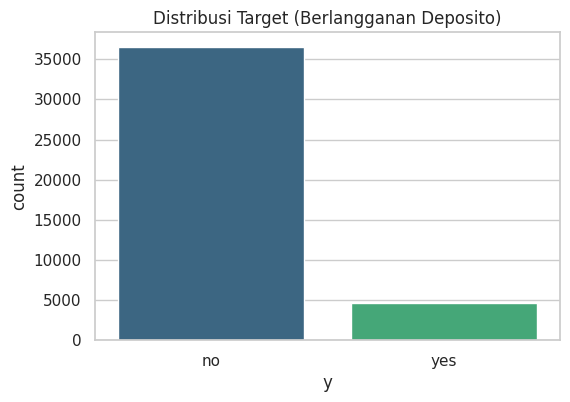

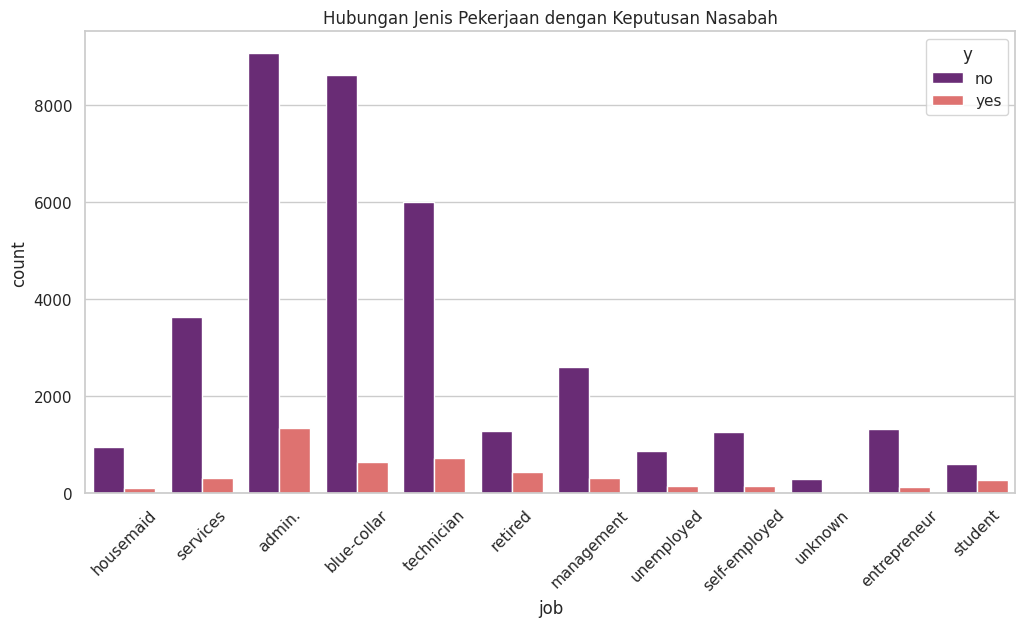

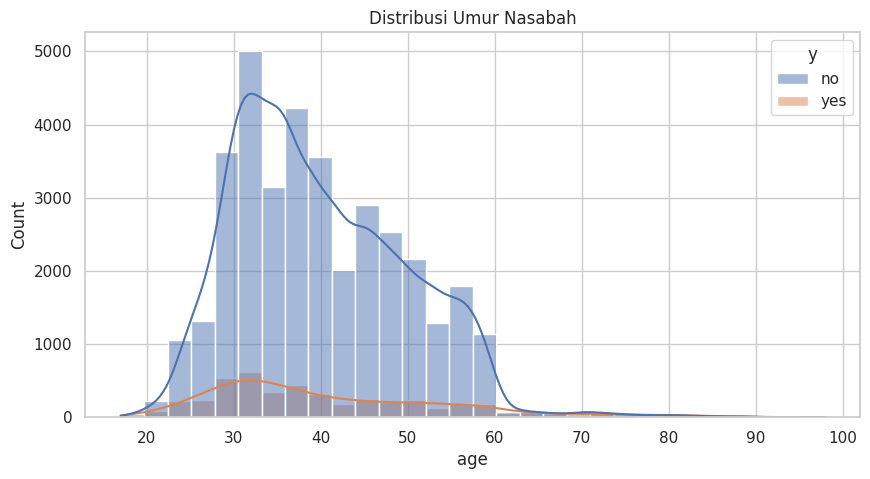

In [19]:
# Set style
sns.set_theme(style="whitegrid")

# 1. Visualisasi Distribusi Target
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='y', palette='viridis')
plt.title('Distribusi Target (Berlangganan Deposito)')
plt.show()

# 2. Visualisasi Hubungan Pekerjaan dengan Target
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='job', hue='y', palette='magma')
plt.xticks(rotation=45)
plt.title('Hubungan Jenis Pekerjaan dengan Keputusan Nasabah')
plt.show()

# 3. Distribusi Umur
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='age', hue='y', kde=True, bins=30)
plt.title('Distribusi Umur Nasabah')
plt.show()

### 1. Visualisasi Distribusi Target (`y`)
Grafik pertama menampilkan jumlah nasabah yang berlangganan deposito (`yes`) dibandingkan dengan yang tidak (`no`).

**Insight:**
*   **Ketimpangan Kelas (Class Imbalance):** Terlihat jelas bahwa proporsi kelas `no` (tidak berlangganan) jauh lebih mendominasi dibandingkan kelas `yes`.
*   **Implikasi Bisnis:** Sebagian besar panggilan telepon yang dilakukan sales berakhir dengan penolakan. Ini menandakan bahwa jika kita menelepon secara acak, biaya operasional akan sangat tinggi dengan konversi yang rendah.
*   **Implikasi Model:** Karena data tidak seimbang, akurasi (accuracy) biasa tidak akan menjadi metrik yang relevan. Kita perlu menggunakan metrik seperti **F1-Score**, atau fokus pada **Recall/Precision**.

### 2. Hubungan Pekerjaan dengan Keputusan Nasabah (`job` vs `y`)
Grafik kedua memetakan jenis pekerjaan nasabah terhadap keputusan mereka untuk mengambil deposito.

**Insight:**
*   **Volume vs Rasio:** Beberapa kategori pekerjaan mungkin memiliki jumlah nasabah yang banyak (seperti *blue-collar* atau *admin*), namun kita perlu memperhatikan batang berwarna oranye/kuning (`yes`) untuk melihat potensi konversinya.
*   **Segmentasi Potensial:** Pekerjaan dengan tingkat ekonomi lebih stabil atau kelompok *retired* (pensiunan) dan *student* (pelajar) seringkali memiliki pola perilaku unik yang bisa menjadi fitur penting bagi model untuk memprediksi nasabah potensial.

### 3. Distribusi Umur Nasabah (`age`)
Grafik ketiga menunjukkan sebaran umur nasabah dengan kurva kepadatan (*KDE*) untuk melihat di rentang usia berapa nasabah paling banyak berada.

**Insight:**
*   **Rentang Usia Produktif:** Mayoritas nasabah berada di usia produktif (sekitar 30-50 tahun).
*   **Pola Target:** Kita dapat mengamati apakah nasabah yang mengambil deposito (`yes`) memiliki distribusi umur yang sedikit berbeda dibandingkan yang menolak. Misalnya, apakah ada kecenderungan nasabah yang lebih tua lebih tertarik pada produk deposito dibanding nasabah muda.

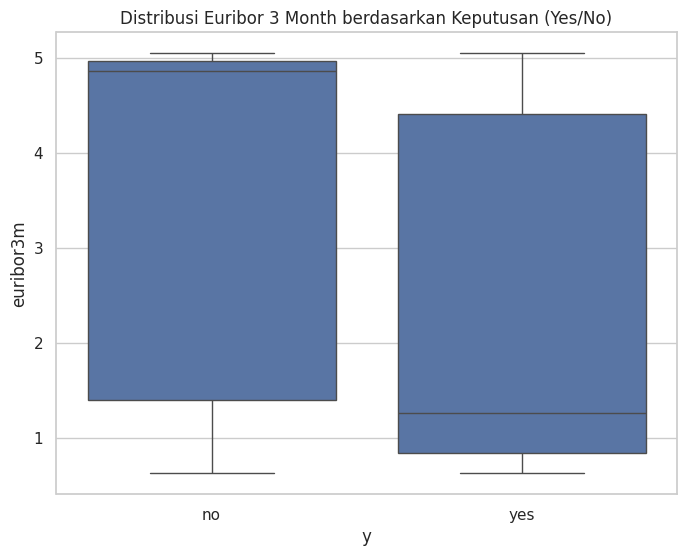

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='euribor3m', data=df)
plt.title('Distribusi Euribor 3 Month berdasarkan Keputusan (Yes/No)')
plt.show()

Berdasarkan Boxplot yang dihasilkan, terlihat perbedaan pola distribusi yang sangat mencolok antara nasabah yang menolak (no) dan nasabah yang menerima (yes) penawaran.
1. Analisis Deskriptif (Apa yang Terlihat di Grafik)

* Perbedaan Median (Garis Tengah) yang Signifikan:

Kelompok no: Garis tengah (median) berada di posisi yang sangat tinggi, mendekati angka 4.8 - 4.9. Ini menunjukkan bahwa sebagian besar penolakan terjadi ketika suku bunga Euribor sedang tinggi.
Kelompok yes: Garis tengah (median) berada di posisi rendah, di kisaran angka 1.2 - 1.3. Ini menunjukkan bahwa mayoritas nasabah yang setuju (closing) dihubungi saat suku bunga sedang rendah.


* Posisi Kotak (Interquartile Range):

Kotak no: Badan kotaknya sangat panjang namun "berat di atas". Artinya, data sangat terkonsentrasi di suku bunga tinggi (3 - 5), meskipun ada juga yang menolak di suku bunga rendah.
Kotak yes: Badan kotaknya lebih condong ke bawah. Meskipun whisker (garis atas) tetap menyentuh angka 5, namun 75% data nasabah yang yes berada di bawah angka suku bunga 4-an.



2. Insight Implisit (Makna di Balik Data)

* Sensitivitas Terhadap Kondisi Makroekonomi:
Nasabah bank ini tampaknya sangat sensitif terhadap kondisi ekonomi makro (diwakili oleh Euribor). Tingkat keberhasilan telemarketing bukan hanya soal skill sales, tapi sangat dipengaruhi oleh "waktu" (timing) kondisi pasar.
* Hambatan Psikologis di Bunga Tinggi:
Ketika Euribor tinggi (mendekati 5), hampir semua upaya marketing cenderung gagal (dominasi kategori no). Kemungkinan besar, saat bunga Euribor tinggi, nasabah lebih memilih instrumen investasi lain atau justru menahan uang tunai karena biaya pinjaman yang mahal, sehingga produk deposito berjangka (term deposit) menjadi kurang menarik atau mereka sedang tidak punya likuiditas.
* Pola paling ideal:
Ada zona nyaman untuk jualan, yaitu ketika Euribor berada di kisaran 0.6 hingga 1.5. Di area inilah densitas (kepadatan) nasabah yang bilang yes paling tinggi.

3. Rekomendasi Strategis (Actionable Insight)

1. Efisiensi Call Center: Jika Euribor sedang tinggi (di atas 4%), kurangi volume panggilan keluar (outbound call) secara drastis karena peluang konversi sangat kecil. Alihkan tenaga sales untuk retention atau produk lain yang tidak sensitif bunga.
2. Agresif saat Bunga Turun: Ketika indikator Euribor mulai turun di bawah 2%, ini adalah sinyal untuk melakukan kampanye marketing besar-besaran karena resistensi nasabah jauh lebih rendah.
3. Evaluasi Produk: Jika bank tetap ingin jualan saat Euribor tinggi (angka 4-5), maka fitur produk atau bunga yang ditawarkan bank harus jauh lebih kompetitif daripada standar pasar saat itu, karena data menunjukkan produk standar sulit laku di kondisi tersebut.

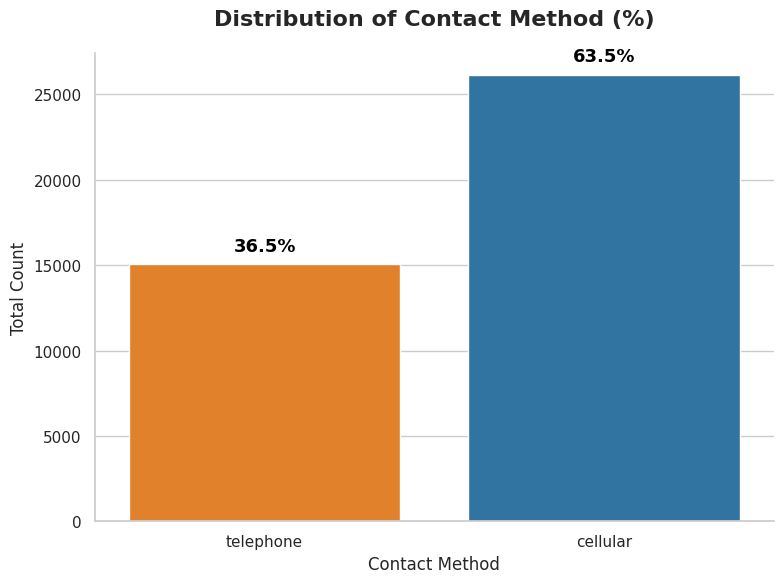

In [21]:
# 1. Reset ke settingan default (Putih)
plt.rcdefaults()
sns.set_theme(style="whitegrid") # Pakai whitegrid supaya ada garis bantu tipis

# 2. Hitung total data untuk pembagi persentase
total_data = len(df['contact'])

# 3. Setup Figure
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')

# 4. Membuat Countplot
sns.countplot(
    data=df, 
    x='contact', 
    hue='contact',
    palette={'cellular': '#1f77b4', 'telephone': '#ff7f0e'},
    ax=ax,
    legend=False
)

# 5. Menambahkan Label Persentase di Atas Bar
for p in ax.patches:
    # Hitung persentase: (tinggi bar / total data) * 100
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_data)
    
    # Ambil posisi x dan y untuk teks
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    
    # Tulis teks persentase
    ax.annotate(percentage, 
                (x, y), 
                ha='center', va='bottom', 
                fontsize=13, 
                fontweight='bold', 
                color='black',
                xytext=(0, 7), 
                textcoords='offset points')

# 6. Judul dan Label
ax.set_title('Distribution of Contact Method (%)', fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Contact Method', fontsize=12)
ax.set_ylabel('Total Count', fontsize=12)

# Hapus garis tepi atas dan kanan agar clean
sns.despine()

plt.tight_layout()
plt.show()

### **Analisis Distribusi**
Berdasarkan grafik di atas, kita dapat melihat perbedaan yang cukup signifikan antara kedua metode tersebut:
* **Cellular (Dominan)**: Sebagian besar nasabah (sekitar 26.144 kontak) dihubungi melalui ponsel. Hal ini menunjukkan tren komunikasi modern di mana ponsel lebih mudah dijangkau.
* **Telephone**: Hanya sebagian kecil (sekitar 15.044 kontak) yang dihubungi melalui telepon kabel.

### **Insight Bisnis**
* Ketersediaan nomor ponsel nasabah jauh lebih tinggi, yang memungkinkan tim sales untuk melakukan *follow-up* dengan lebih fleksibel (SMS/terlebih Telepon jika memungkinkan di sistem bank).
* Dengan jumlah mencapai 15.044 pada metode telepon kabel tentu tidak bisa diabaikan. Tim perlu menganalisis apakah nasabah yang dihubungi via telepon kabel memiliki karakteristik tertentu (misal: kelompok umur senior atau segmen pekerjaan tertentu) yang mungkin memiliki *conversion rate* berbeda.

### **Implikasi Strategis**
* Perlu dilakukan pengujian lebih lanjut untuk melihat apakah ada perbedaan tingkat keberhasilan (*Success Rate*) antara kedua kanal ini. Jika telepon seluler memberikan efisiensi yang jauh lebih tinggi, maka investasi pada database nomor ponsel harus terus diprioritaskan.

### Conversion Rate sebagai alat ukur keberhasilan nasabah untuk diajak berlangganan deposito

Conversion Rate pada beberapa visualisasi data ini akan menjadi alat ukur untuk mengetahui secara tepat untuk mengetahui pola kesuksesan telemarketing secara akurat tanpa ada bias dari ketimpangan jumlah volume nasabah serta jumlah nasabah yang berlangganan deposito

#### Analisis Konversi Deposito Berdasarkan Pekerjaan

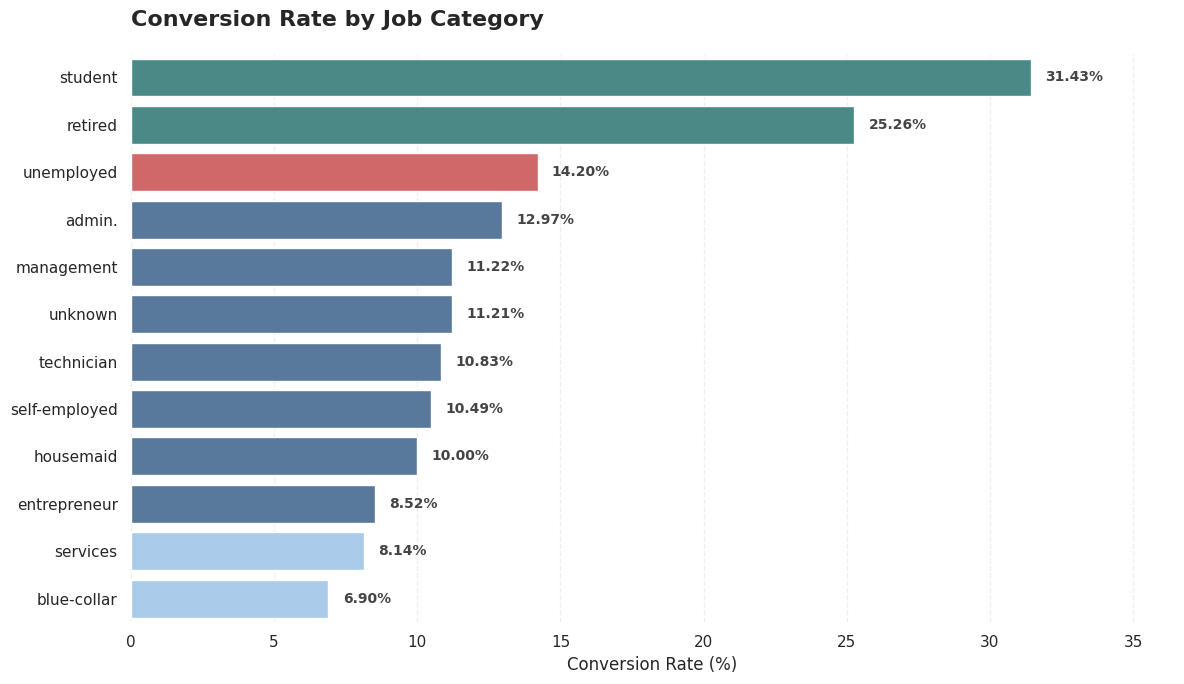

In [22]:
# ---------------------------------------------------------
# 1. Persiapan Data (Menghitung Conversion Rate)
# ---------------------------------------------------------
# Anggap 'df' adalah dataframe asli Anda yang memuat semua data nasabah
# Kita perlu mengubah target 'y' (yes/no) menjadi angka 1/0 dulu
df['target_num'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Menghitung Conversion Rate per Job
# (Rata-rata target_num dikali 100 untuk dapat persentase)
job_conversion = df.groupby('job')['target_num'].mean() * 100
job_conversion = job_conversion.reset_index().rename(columns={'target_num': 'conversion_rate'})

# Mengurutkan dari conversion rate tertinggi ke terendah
job_conversion = job_conversion.sort_values(by='conversion_rate', ascending=False)

# ---------------------------------------------------------
# 2. Visualisasi (Horizontal Bar Plot)
# ---------------------------------------------------------
plt.figure(figsize=(12, 7))

# Membuat palet warna kustom (Teal untuk top performer, biru pudar untuk lainnya)
# Ini opsional, agar mirip gambar referensi Anda sebelumnya
custom_palette = {}
for job in job_conversion['job']:
    if job in ['student', 'retired']:
        custom_palette[job] = '#3E9490'  # Teal/Hijau Tosca (High Potential)
    elif job in ['unemployed']:
        custom_palette[job] = '#E15759'  # Merah (Unik)
    elif job in ['blue-collar', 'services']:
        custom_palette[job] = '#9FCBF5'  # Biru Muda (Low Potential)
    else:
        custom_palette[job] = '#4E79A7'  # Biru Standar

# Membuat Bar Plot Horizontal (x = nilai, y = kategori)
ax = sns.barplot(
    data=job_conversion,
    x='conversion_rate',
    y='job',
    palette=custom_palette,
    edgecolor=None
)

# Menambahkan label angka di ujung batang
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width + 0.5,       # Posisi X sedikit di kanan batang
        p.get_y() + p.get_height()/2, # Posisi Y di tengah batang
        f'{width:.2f}%',   # Format angka persen
        ha='left',
        va='center',
        fontsize=10,
        fontweight='bold',
        color='#444444'
    )

# ---------------------------------------------------------
# 3. Styling / Mempercantik Tampilan
# ---------------------------------------------------------
plt.title('Conversion Rate by Job Category', loc='left', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Conversion Rate (%)')
plt.ylabel('') # Hapus label sumbu Y agar lebih bersih
plt.xlim(0, max(job_conversion['conversion_rate']) + 5) # Memberi ruang kosong di kanan
sns.despine(left=True, bottom=True) # Menghilangkan garis pinggir kotak
plt.grid(axis='x', linestyle='--', alpha=0.3) # Grid tipis vertikal

plt.tight_layout()
plt.show()

# Analisis Bisnis & Insight

Berdasarkan grafik batang di atas, kita dapat menarik beberapa **insight krusial** mengenai perilaku nasabah:

---

## A. Anomali "Student" dan "Retired" (Top Performers)

> **Observasi:** Kategori **student (31.43%)** dan **retired (25.26%)** memiliki tingkat konversi yang **jauh lebih tinggi** dibandingkan kategori pekerja aktif (seperti *management* atau *technician*).

### Analisis:

**1. Waktu Luang**

Kelompok ini cenderung memiliki **lebih banyak waktu luang** untuk mendengarkan penjelasan telemarketer dibandingkan pekerja sibuk.

**2. Kebutuhan Finansial**

| Segmen | Alasan Konversi Tinggi |
|---|---|
| **Retired** | Pensiunan biasanya mencari instrumen investasi yang **aman dan berisiko rendah** untuk menyimpan dana pensiun mereka. Deposito adalah pilihan yang sangat cocok untuk profil risiko **konservatif** ini. |
| **Student** | Meskipun penghasilan mungkin rendah, mahasiswa yang menabung (seringkali dari uang saku atau dukungan orang tua) cenderung ingin **"mengunci" uang** mereka agar tidak terpakai, atau mereka sedang belajar **literasi keuangan awal**. |

**3. Probabilitas**

Meskipun **jumlah (volume)** nasabah *student* dan *retired* mungkin lebih sedikit dalam database dibanding *blue-collar*, **probabilitas mereka berkata "YA"** saat ditelepon **jauh lebih besar**.

---

## B. Kelompok Menengah (White Collar & Unemployed)

> **Observasi:** **Unemployed (14.20%)**, **admin (12.97%)**, dan **management (11.22%)** berada di tengah.

### Analisis:

| Segmen | Interpretasi |
|---|---|
| **Unemployed** | Anehnya, pengangguran punya konversi cukup baik. Ini bisa jadi karena mereka yang baru saja kehilangan pekerjaan ingin **mengamankan pesangon** *(severance pay)* ke dalam deposito, atau mereka memiliki **waktu untuk merespons** panggilan bank. |
| **Admin / Management** | Ini adalah kelompok pekerja kerah putih standar. Mereka memiliki likuiditas, tapi mungkin lebih tertarik pada instrumen investasi yang **lebih agresif** (saham, reksa dana) dibanding deposito, atau mereka **terlalu sibuk** untuk meladeni telemarketing. |

---

## C. Kelompok Konversi Rendah (Blue-Collar & Services)
> **Observasi:** **Blue-collar (6.90%)** dan **services (8.14%)** memiliki performa **terburuk**.

### Analisis:

| Faktor | Penjelasan |
|---|---|
| **Likuiditas Tunai** | Pekerja kerah biru dan sektor jasa seringkali membutuhkan **likuiditas tunai yang tinggi** untuk kebutuhan sehari-hari. Mengunci uang dalam deposito (tidak bisa diambil sewaktu-waktu) **kurang menarik** bagi profil ekonomi mereka. |
| **Sensitivitas Ekonomi** | Kelompok ini mungkin lebih **rentan terhadap guncangan ekonomi**, sehingga lebih memilih memegang uang tunai *(savings biasa)* daripada deposito berjangka. |

---

# Rekomendasi Strategis (Action Plan)

Berdasarkan data visual tersebut, berikut adalah saran untuk **tim marketing bank**:

### 1. Prioritaskan Call List

Algoritma pemanggilan harus **memprioritaskan** nasabah dengan status **student** dan **retired**. Meskipun volumenya kecil, efisiensinya *(Hit Rate)* sangat tinggi. Ini akan **menghemat biaya operasional** telepon *(talk time)*.

### 2. Kustomisasi Script

| Target Segmen | Pendekatan yang Disarankan |
|---|---|
| **Retired** | Tekankan pada **"Keamanan"**, **"Bunga Stabil"**, dan **"Tanpa Risiko"** |
| **Blue-collar** | Jangan tawarkan deposito tenor panjang. Tawarkan produk **tabungan fleksibel** atau **deposito jangka pendek** dengan nominal kecil agar tidak memberatkan *cash flow* mereka |

### 3. Evaluasi Strategi untuk Blue-Collar

Mengingat *blue-collar* biasanya merupakan **porsi populasi yang besar** namun konversinya rendah **(6.90%)**, **hindari metode telemarketing agresif** pada segmen ini karena akan membuang *resource*. Gunakan **channel digital** (SMS / Email / Notifikasi App) yang lebih **murah biayanya** untuk segmen ini.

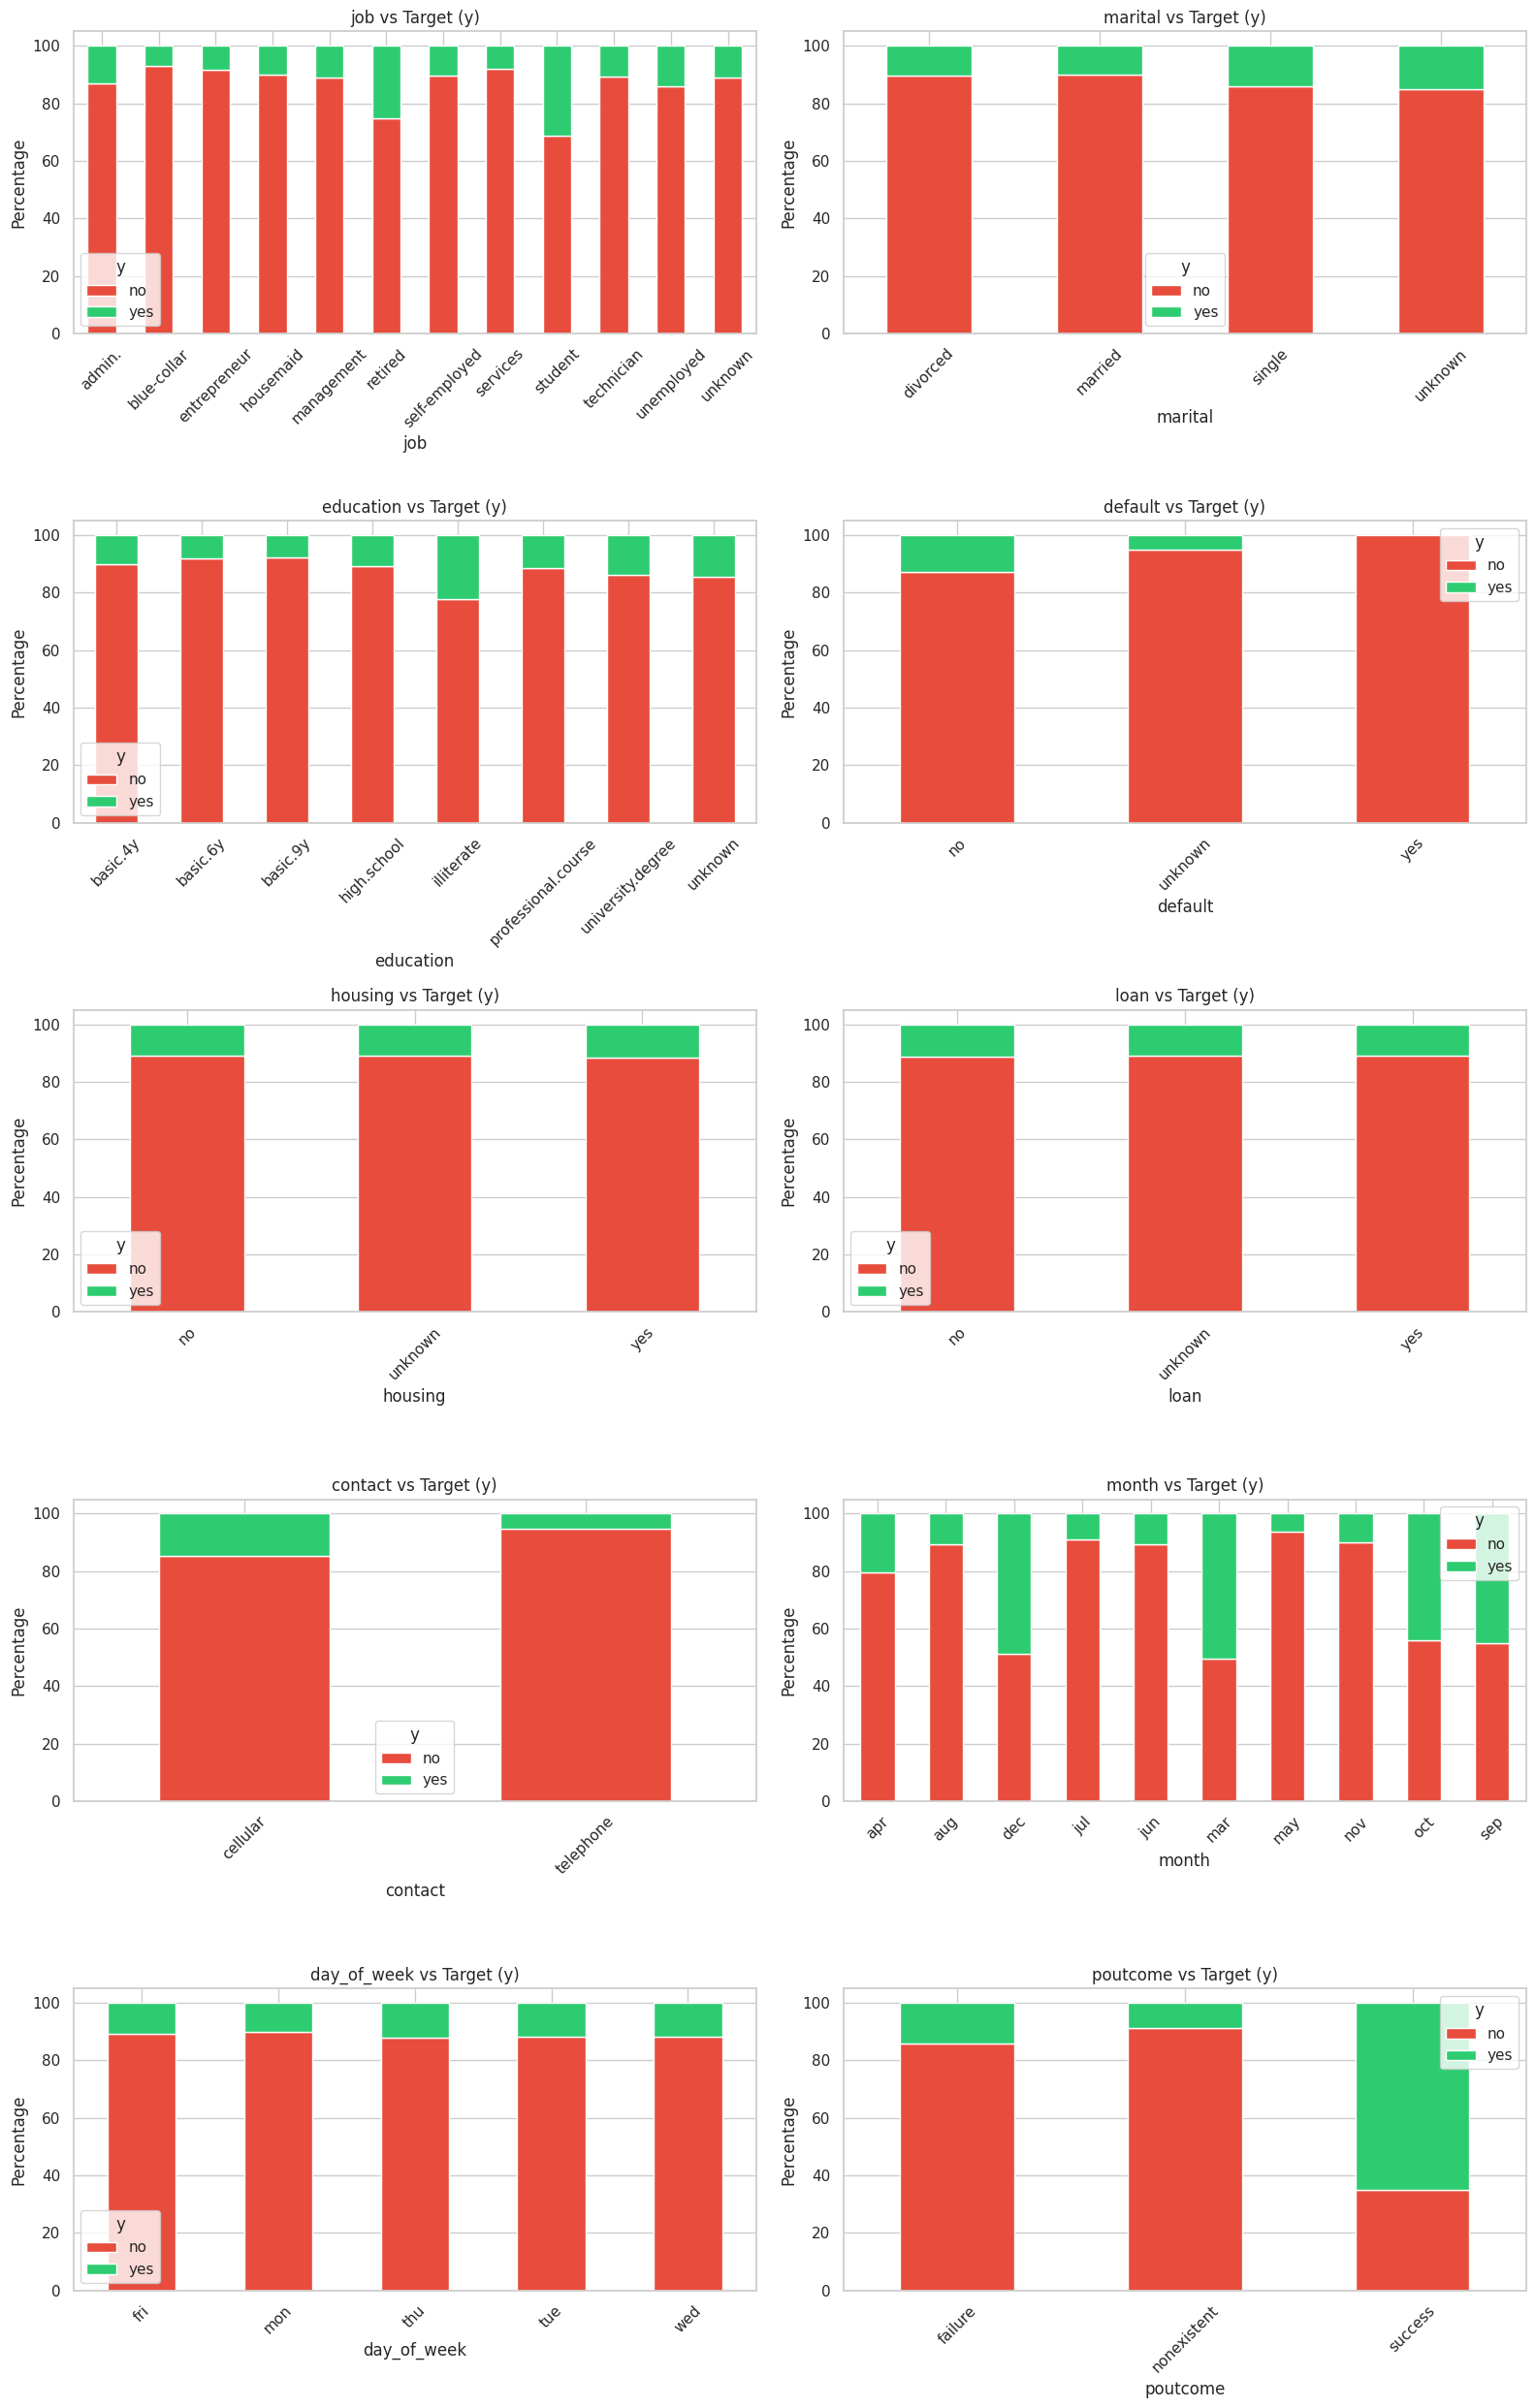

In [23]:
categorical_cols = ['job', 'marital', 'education', 'default',
                    'housing', 'loan', 'contact', 'month',
                    'day_of_week', 'poutcome']

fig, axes = plt.subplots(5, 2, figsize=(16, 25))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Cross-tabulation dengan persentase
    cross_tab = pd.crosstab(df[col], df['y'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=True, ax=axes[i], color=['#e74c3c', '#2ecc71'])
    axes[i].set_title(f'{col} vs Target (y)')
    axes[i].set_ylabel('Percentage')
    axes[i].legend(title='y')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Visualisasi data di atas menggunakan **100% Stacked Bar Charts** untuk melihat peluang keberhasilan telemarketing berdasarkan berbagai kategori.
- **Warna Hijau (`yes`)**: Menunjukkan persentase nasabah yang setuju berlangganan deposito (Conversion Rate).
- **Warna Merah (`no`)**: Menunjukkan persentase penolakan.

Berikut adalah *key insights* yang dapat ditarik dari visualisasi tersebut:

### 1. Faktor Riwayat Kampanye (`poutcome`) - *Indikator Terkuat*
Variabel `poutcome` (hasil kampanye sebelumnya) menunjukkan pola yang paling drastis dan signifikan.
*   **Success breeds success:** Jika nasabah pernah menerima penawaran di kampanye sebelumnya (`success`), batang hijau melonjak sangat tinggi. Ini mengindikasikan bahwa nasabah yang puas atau loyal memiliki peluang sangat besar untuk berlangganan deposito kembali ketika telemarketing akan menelepon kembali.
*   **Implikasi:** `poutcome` kemungkinan besar akan menjadi fitur dengan *importance* tertinggi dalam model *Machine Learning*.

### 2. Faktor Finansial (`default`, `housing`, `loan`)
Kondisi keuangan nasabah berbanding terbalik dengan minat deposito.
*   **Kredit Macet (`default`):** Nasabah yang memiliki riwayat kredit macet hampir tidak memiliki area hijau sama sekali. Mereka bukan target pasar yang tepat untuk menyimpan dana.
*   **Beban Cicilan:** Nasabah yang **tidak** memiliki cicilan rumah (`housing=no`) atau pinjaman pribadi (`loan=no`) cenderung memiliki proporsi hijau (konversi) yang lebih tinggi dibanding yang memiliki cicilan.
*   **Insight:** Nasabah dengan *disposable income* (uang sisa) lebih tinggi lebih prospektif.

### 3. Faktor Waktu & Musiman (`month`, `day_of_week`)
*   **Pola Bulan (`month`):** Terlihat adanya musiman yang kuat. Bulan-bulan tertentu seperti **Maret, September, Oktober, dan Desember** seringkali memiliki rasio konversi (hijau) yang jauh lebih tinggi dibandingkan bulan Mei (yang biasanya volume tinggi tapi konversi rendah). Ini mungkin terkait dengan siklus ekonomi atau strategi kontak bank.
*   **Hari Kerja (`day_of_week`):** Distribusi warna hijau terlihat cenderung rata/seragam di semua hari. Ini mengindikasikan bahwa hari peneleponan tidak terlalu berpengaruh signifikan terhadap keputusan nasabah dibandingkan bulan.

### 4. Profil Demografis (`job`, `education`, `marital`)
*   **Pekerjaan (`job`):** Kelompok **'student'** (pelajar) dan **'retired'** (pensiunan) biasanya menunjukkan rasio konversi tertinggi. Meskipun secara jumlah mungkin sedikit, probabilitas mereka untuk *say yes* sangat tinggi karena kebutuhan menyimpan uang yang lebih relevan.
*   **Pendidikan (`education`):** Secara umum, semakin tinggi tingkat pendidikan, kecenderungan literasi keuangan membaik, yang sedikit meningkatkan peluang konversi, namun polanya tidak se-ekstrem variabel `poutcome`.

### 5. Media Komunikasi (`contact`)
*   **Cellular vs Telephone:** Pengguna telepon seluler (`cellular`) umumnya memiliki respon positif yang lebih tinggi dibandingkan telepon rumah (`telephone`), yang mungkin mencerminkan segmen demografi yang lebih modern atau mudah dihubungi.

In [24]:
# Define numerical columns
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 
                  'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
                  'euribor3m', 'nr.employed']

# Descriptive statistics
print("="*60)
print("DESCRIPTIVE STATISTICS - NUMERICAL FEATURES")
print("="*60)
display(df[numerical_cols].describe().T.style.background_gradient(cmap='Blues'))

DESCRIPTIVE STATISTICS - NUMERICAL FEATURES


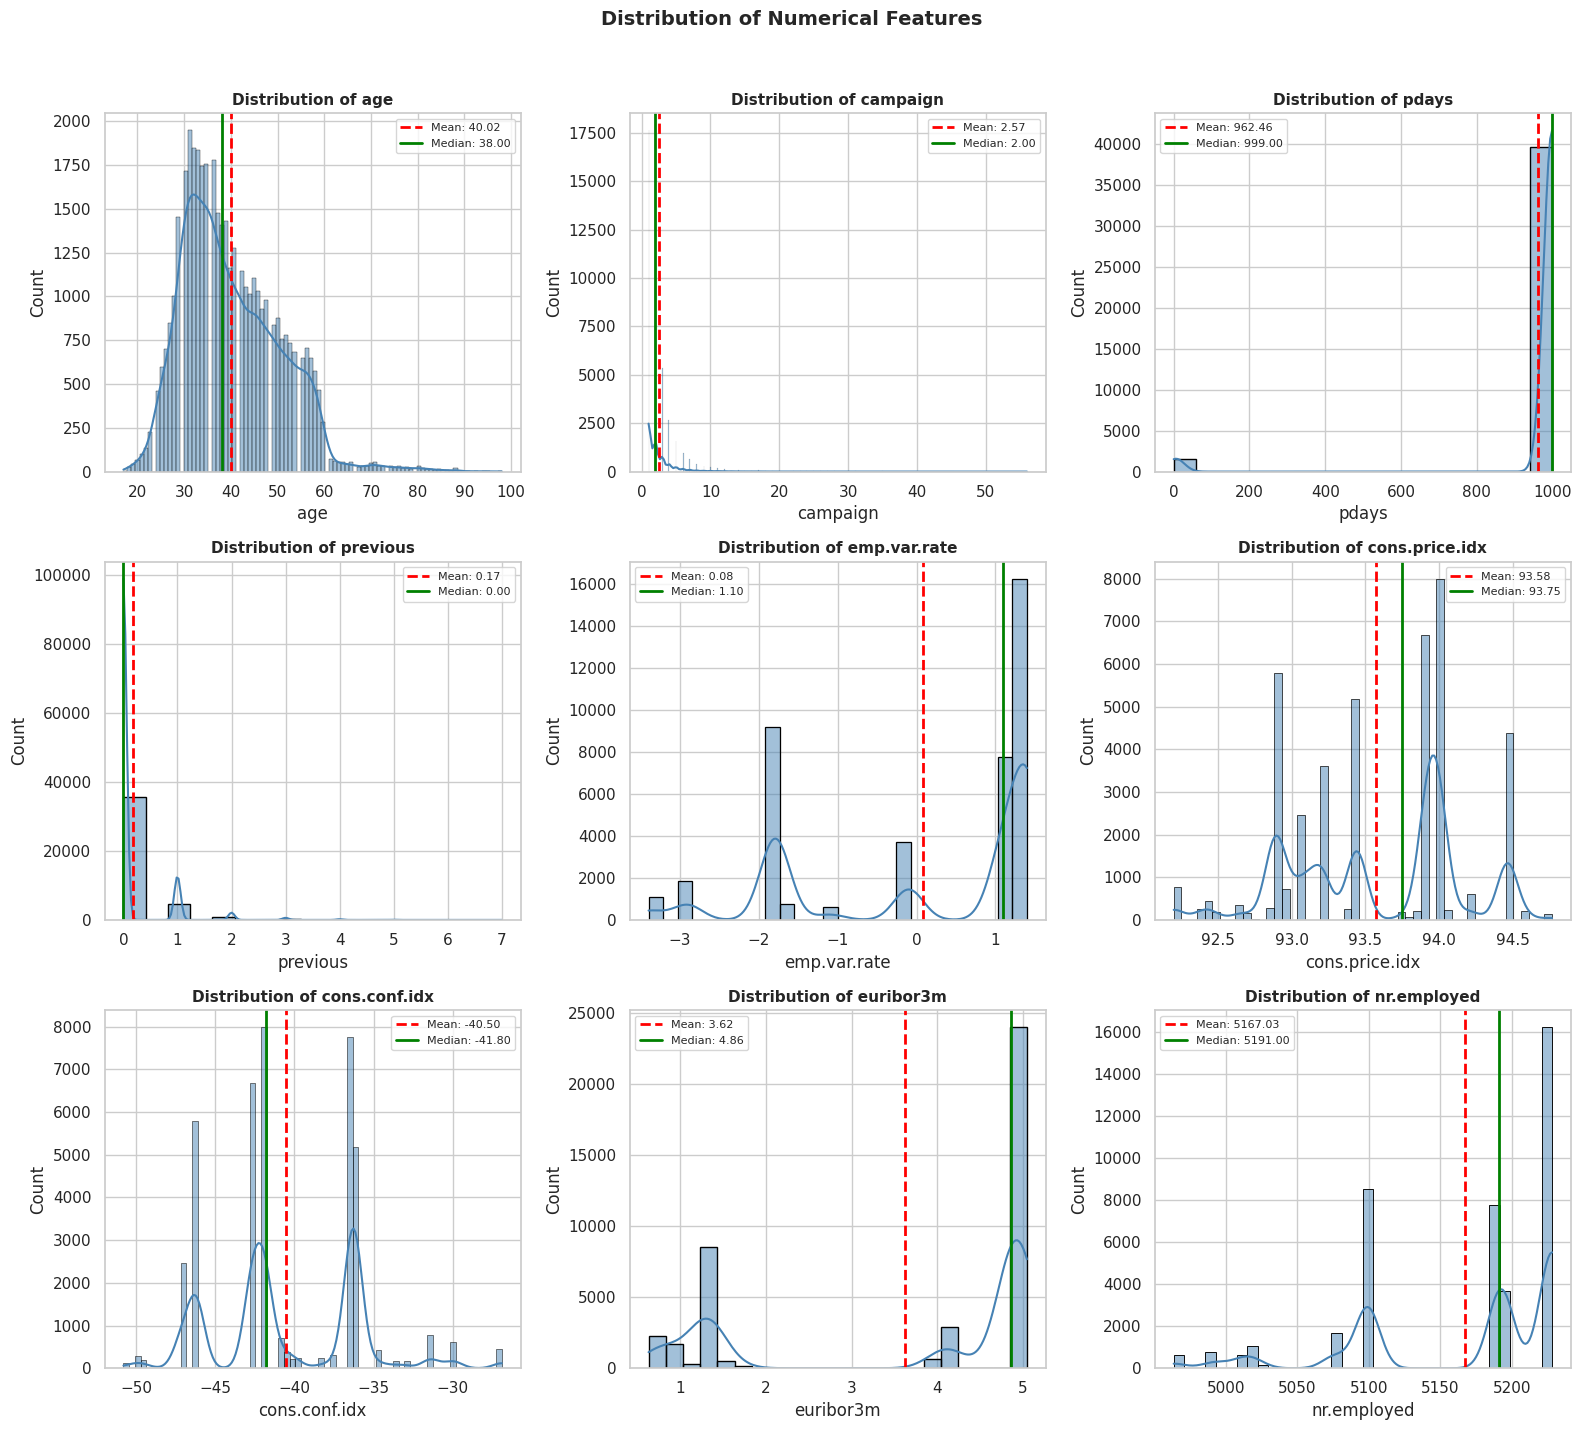

In [25]:
# Distribution plots
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    # Histogram with KDE
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], color='steelblue', edgecolor='black')

    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    axes[i].set_title(f'Distribution of {col}', fontsize=11, fontweight='bold')
    axes[i].legend(fontsize=8)

plt.suptitle('Distribution of Numerical Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Apakah terlalu banyak kontak justru menurunkan conversion?

Conversion Rate by Previous Outcome:
y                   no        yes
poutcome                         
failure      85.771402  14.228598
nonexistent  91.167618  8.832382 
success      34.887109  65.112891


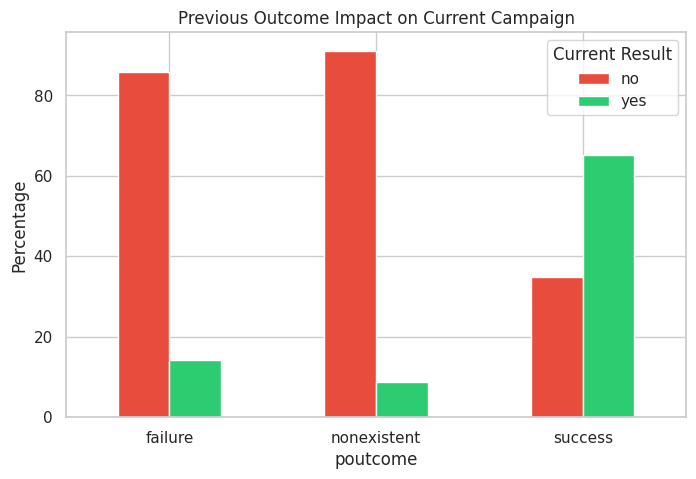

In [26]:
# Analisis previous outcome
poutcome_analysis = pd.crosstab(df['poutcome'], df['y'], normalize='index') * 100
print("Conversion Rate by Previous Outcome:")
print(poutcome_analysis)

# Visualisasi
poutcome_analysis.plot(kind='bar', color=['#e74c3c', '#2ecc71'], figsize=(8, 5))
plt.title('Previous Outcome Impact on Current Campaign')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Current Result')
plt.show()

#### Dampak Hasil Kampanye Sebelumnya (`poutcome`)

Grafik diatas membagi nasabah menjadi tiga kelompok berdasarkan hasil kampanye marketing sebelumnya: **Failure** (Gagal), **Nonexistent** (Belum pernah dikontak), dan **Success** (Berhasil).

### Interpretasi Visualisasi
Grafik batang ini menunjukkan probabilitas konversi (`y=yes` berwarna hijau) yang sangat kontras antar kategori:

#### 1. Kategori `success`
*   **Visual:** Pada batang ini, area berwarna **Hijau** akan mendominasi secara drastis, seringkali mencapai lebih dari 50% atau bahkan 60-70%.
*   **Insight:** Ini adalah indikator terkuat dalam seluruh dataset. Nasabah yang pernah membeli produk (deposito) di kampanye sebelumnya memiliki kecenderungan psikologis dan finansial yang sangat tinggi untuk membeli lagi. Mereka sudah percaya pada bank dan memiliki *customer journey* yang positif.
*   **Implikasi:** Segmen ini adalah "buah yang paling rendah" (low-hanging fruit). Tim marketing harus memprioritaskan daftar ini karena *Cost per Acquisition* (CPA)-nya sangat rendah.

#### 2. Kategori `nonexistent`
*   **Visual:** Batang ini didominasi oleh warna **Merah**, dengan area hijau yang tipis (biasanya sekitar 8-10%).
*   **Insight:** Ini mewakili sebagian besar data (nasabah baru atau belum pernah dikontak). Tingkat konversi di sini adalah *baseline* atau standar keberhasilan *cold calling*. Karena belum ada riwayat interaksi, bank harus berjuang lebih keras untuk meyakinkan nasabah.

#### 3. Kategori `failure`
*   **Visual:** Mirip dengan `nonexistent`, didominasi warna merah. Namun, terkadang rasio hijaunya sedikit lebih tinggi daripada `nonexistent` (walau tetap rendah).
*   **Insight:** Nasabah ini pernah dikontak tapi menolak. Meskipun gagal, mereka sudah memiliki *brand awareness*. Namun, penolakan masa lalu sering kali menjadi indikator penolakan masa depan kecuali ada penawaran yang jauh lebih menarik.

---

### Kesimpulan Strategis
Hasil dari `print(poutcome_analysis)` dan plot ini memberikan satu kesimpulan bisnis yang krusial:

> **"Perilaku masa lalu adalah prediktor terbaik untuk perilaku masa depan."**

Jika model *Machine Learning* digunakan, variabel `poutcome` yang bernilai 'success' akan menjadi faktor penentu utama (bobot tertinggi) yang membuat model memprediksi nasabah tersebut akan berkata "Ya".

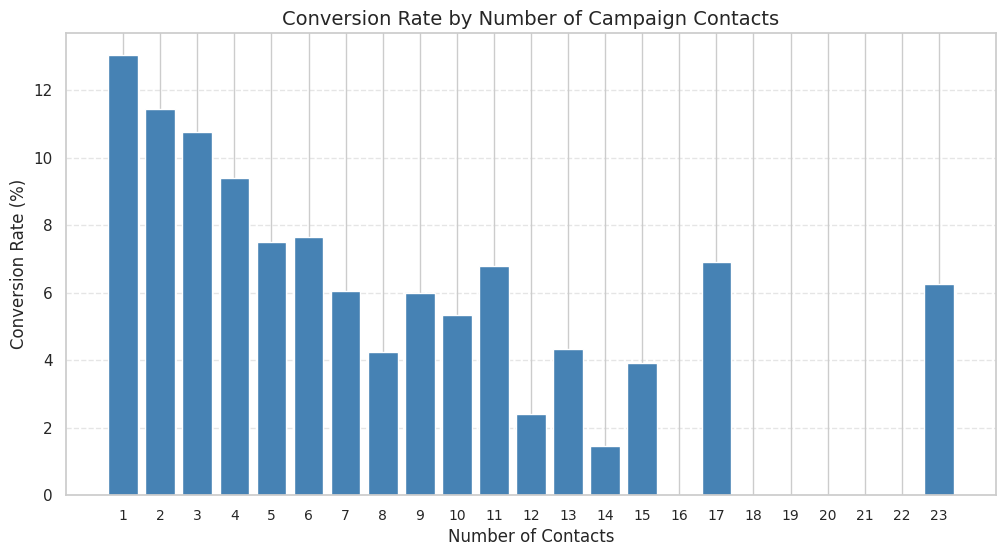

In [27]:
# 1. Menyiapkan Data
campaign_analysis = df.groupby('campaign')['y'].apply(
    lambda x: (x == 'yes').sum() / len(x) * 100
).reset_index()
campaign_analysis.columns = ['campaign', 'conversion_rate']

# --- BAGIAN BARU: MEMBATASI DATA ---
# Kita filter hanya mengambil kampanye yang jumlah kontaknya <= 23
campaign_analysis = campaign_analysis[campaign_analysis['campaign'] <= 23]

# 2. Membuat Visualisasi
plt.figure(figsize=(12, 6)) # Ukuran disesuaikan lagi karena datanya lebih sedikit

plt.bar(campaign_analysis['campaign'], campaign_analysis['conversion_rate'], color='steelblue')

# Mengatur sumbu X agar muncul detail angka yang ada (1 s.d 23)
plt.xticks(
    ticks=campaign_analysis['campaign'],
    labels=campaign_analysis['campaign'],
    fontsize=10
    # rotation=90 boleh dihapus jika angkanya muat lurus, tapi dipakai juga aman
)

plt.xlabel('Number of Contacts')
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate by Number of Campaign Contacts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# Analisis Efektivitas Frekuensi Kontak Kampanye (Number of Contacts)

---

## 1. Pendahuluan

| Item | Deskripsi |
|---|---|
| **Konteks** | Dalam dataset Bank Marketing, fitur `campaign` merepresentasikan jumlah kontak yang dilakukan bank kepada klien selama kampanye ini berlangsung (termasuk kontak terakhir). |
| **Pertanyaan Bisnis** | Apakah "meneror" nasabah dengan menelpon berkali-kali efektif untuk membuat mereka membuka deposito? Atau justru ada titik jenuh di mana panggilan tambahan menjadi sia-sia? |

---

## 2. Visualisasi Data

Grafik di bawah ini menunjukkan **Tingkat Konversi (Conversion Rate)** berdasarkan jumlah panggilan yang dilakukan.

---

## 3. Analisis Insight (Apa makna grafik ini?)

Berdasarkan grafik batang di atas, kita dapat mengidentifikasi pola perilaku nasabah yang sangat jelas terkait keputusan berlangganan deposito:

---

### A. "The Golden Calls" (Panggilan 1-3)

**Observasi:** Tingkat konversi tertinggi terjadi pada kontak pertama **(~13%)**, diikuti kontak kedua **(~11.5%)**, dan ketiga **(~10.8%)**.

**Analisis:**

Nasabah yang memang tertarik dengan produk deposito biasanya akan langsung setuju atau menunjukkan minat serius pada **1 hingga 3 panggilan pertama**. Ini adalah fase paling produktif bagi tim sales.

---

### B. Hukum Hasil yang Semakin Menurun (Diminishing Returns)

**Observasi:** Mulai dari panggilan ke-4 hingga ke-10, tren konversi **menurun secara drastis**. Pada panggilan ke-12 hingga ke-15, konversi jatuh di bawah 5%.

**Analisis:**

Semakin sering seseorang dihubungi tanpa ada persetujuan ("deal"), semakin kecil kemungkinan mereka akan berubah pikiran. Justru, panggilan yang berulang-ulang berpotensi menciptakan **Customer Fatigue** (kelelahan/kejenuhan nasabah) yang bisa berujung pada persepsi negatif terhadap bank (dianggap spam).

---

### C. Anomali Data (Panggilan > 15)

**Observasi:** Terdapat lonjakan tiba-tiba pada panggilan ke-17 dan ke-23.

**Analisis:**

Jangan terkecoh. Ini kemungkinan besar adalah **noise** akibat sampel data yang sangat sedikit.

Contoh: Jika hanya ada 2 orang yang ditelepon 23 kali, dan 1 orang secara ajaib setuju, maka konversi akan terlihat 50% atau tinggi. Namun, secara statistik ini **tidak signifikan** dan tidak bisa dijadikan strategi bisnis.

---

## 4. Implikasi Bisnis dan Rekomendasi

Dari grafik ini, kita dapat merumuskan strategi efisiensi kampanye untuk meningkatkan profitabilitas:

### 1. Tetapkan Batas Panggilan (Capping Strategy)

| Item | Detail |
|---|---|
| **Rekomendasi** | Batasi maksimal panggilan ke satu nasabah sebanyak **3 hingga 5 kali**. |
| **Alasan** | Biaya operasional (gaji telemarketer, pulsa) untuk melakukan panggilan ke-6 hingga ke-20 tidak sebanding dengan hasil (konversi) yang didapat. |

### 2. Efisiensi Sumber Daya

Daripada menelpon nasabah yang sama untuk ke-10 kalinya, lebih baik alokasikan waktu telemarketer untuk menghubungi **prospek baru (fresh leads)** yang masih berada di fase panggilan ke-1, di mana peluang suksesnya jauh lebih tinggi **(13%)**.

### 3. Strategi Modeling (Machine Learning)

Dalam pembuatan model prediksi, nilai `campaign` yang sangat tinggi (misal > 10) bisa diperlakukan sebagai **outliers** atau dikelompokkan **(binning)** menjadi kategori "10+" agar model tidak bias terhadap anomali data di ekor grafik.

---

## 5. Kesimpulan

Terdapat **korelasi negatif yang kuat** antara jumlah panggilan dengan tingkat kesuksesan. Nasabah yang akan berlangganan deposito cenderung mengambil keputusan di **awal interaksi**. Strategi "kuantitas" (menelpon sebanyak mungkin ke orang yang sama) terbukti **tidak efektif** dibandingkan strategi "kualitas" (menelpon orang yang tepat di percobaan awal).

| Strategi | Pendekatan | Efektivitas |
|---|---|---|
| **Kuantitas** | Telpon orang sama berkali-kali | Rendah, boros resource |
| **Kualitas** | Telpon orang tepat di awal | Tinggi, hemat resource |

### Categorical Features vs Target (Conversion Rate)

Menghitung **conversion rate** (persentase "yes") untuk setiap kategori. Ini membantu mengidentifikasi segmen nasabah yang paling responsif terhadap kampanye.

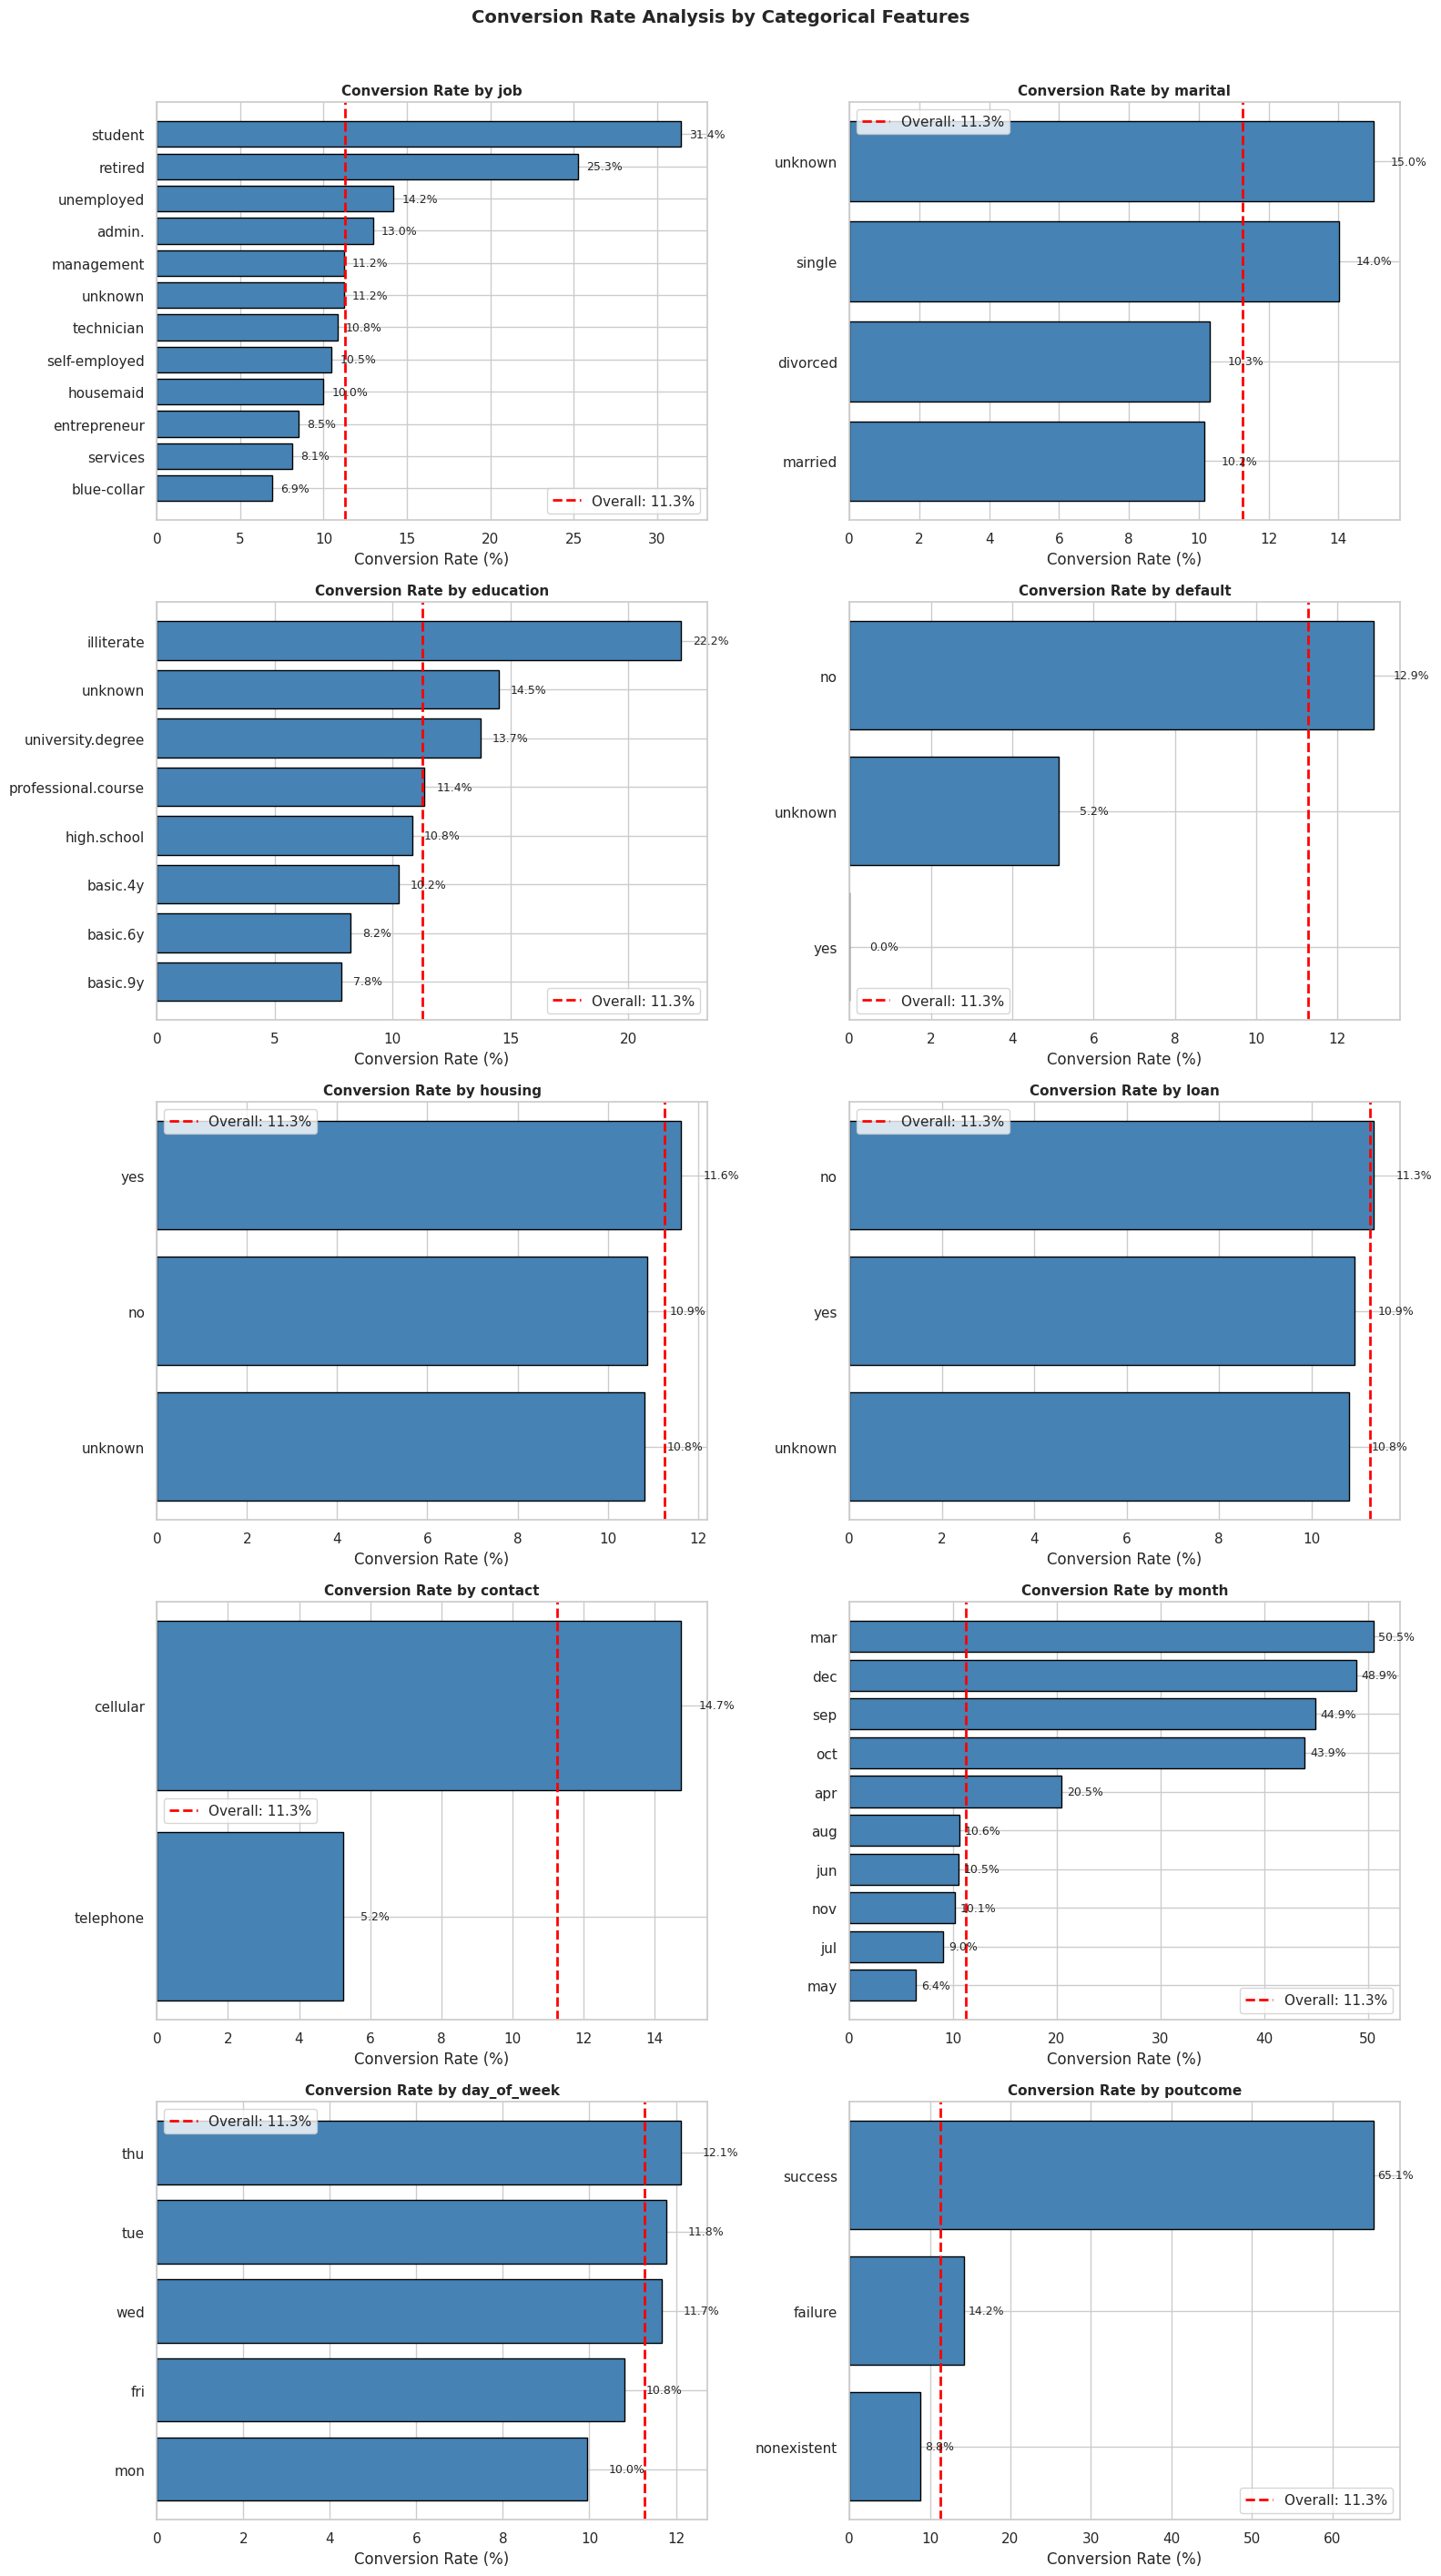

In [28]:
fig, axes = plt.subplots(5, 2, figsize=(16, 28))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Calculate conversion rate
    conv_rate = df.groupby(col)['y'].apply(lambda x: (x == 'yes').sum() / len(x) * 100).sort_values(ascending=True)

    # Bar plot
    bars = axes[i].barh(conv_rate.index, conv_rate.values, color='steelblue', edgecolor='black')
    axes[i].set_title(f'Conversion Rate by {col}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Conversion Rate (%)')

    # Add value labels
    for bar, val in zip(bars, conv_rate.values):
        axes[i].text(val + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{val:.1f}%', va='center', fontsize=9)

    # Add overall average line
    overall_rate = (df['y'] == 'yes').sum() / len(df) * 100
    axes[i].axvline(overall_rate, color='red', linestyle='--', linewidth=2,
                    label=f'Overall: {overall_rate:.1f}%')
    axes[i].legend()

plt.suptitle('Conversion Rate Analysis by Categorical Features', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### Time-Based Analysis (Month & Day)

### Analisis Efektivitas Kampanye Berdasarkan Waktu (Seasonality)

- Pendahuluan: Selain jumlah kontak, faktor waktu (bulan dan hari) memegang peranan penting dalam psikologi nasabah. Visualisasi ini membedah hubungan antara Waktu Kontak dengan Tingkat Konversi (Conversion Rate) dan Volume Panggilan.

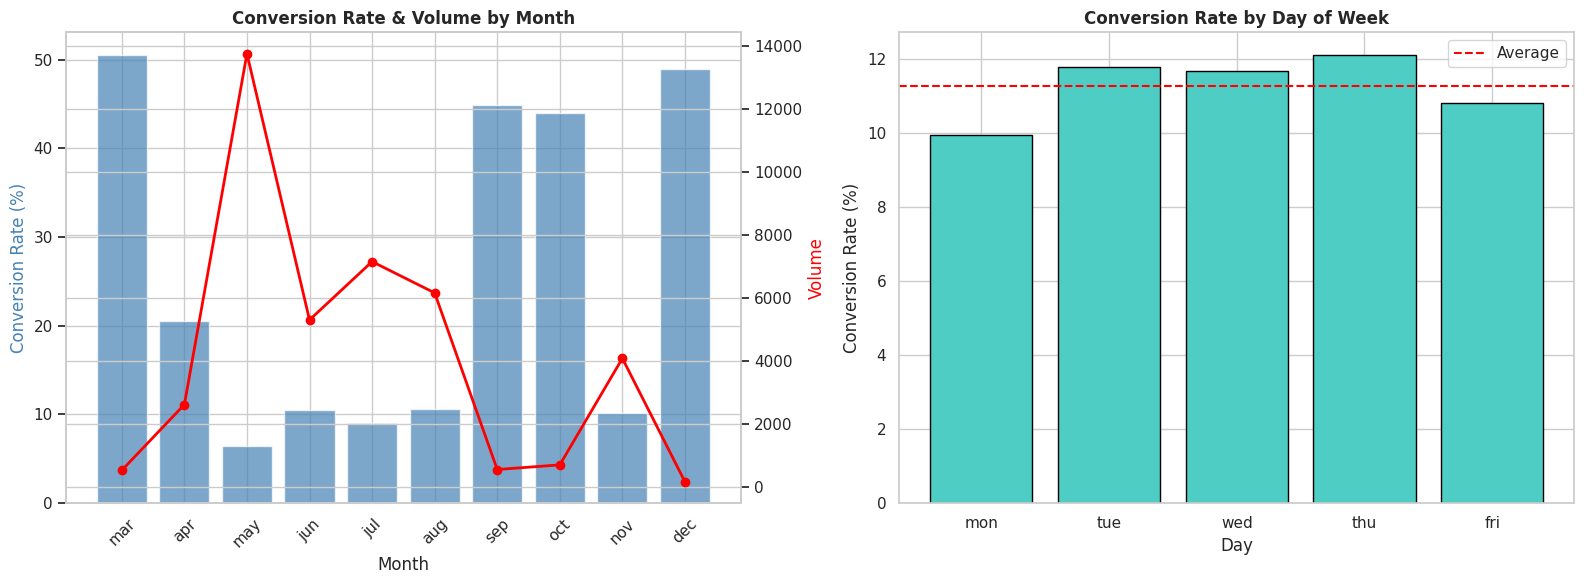

In [29]:
# 1. DEFINISI URUTAN BULAN DAN HARI
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

day_order = ['mon', 'tue', 'wed', 'thu', 'fri']

# 2. PERSIAPAN DATA (MENGHITUNG CONVERSION RATE & VOLUME)

# --- Per Bulan ---
# Hitung Conversion Rate (%) per bulan
month_conv = df.groupby('month')['y'].apply(lambda x: (x=='yes').sum()/len(x)*100)
month_conv = month_conv.reindex(month_order)

# Hitung Volume (Jumlah Data) per bulan
month_count = df.groupby('month').size().reindex(month_order)

# --- Per Hari ---
# Hitung Conversion Rate (%) per hari
day_conv = df.groupby('day_of_week')['y'].apply(lambda x: (x=='yes').sum()/len(x)*100)
day_conv = day_conv.reindex(day_order)


# 3. MEMBUAT VISUALISASI (SAMA PERSIS SEPERTI GAMBAR)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === PLOT 1: BULAN (Dual Axis: Bar & Line) ===

# Axis Kiri (Bar Chart untuk Conversion Rate)
ax1_twin = axes[0].twinx() # Membuat sumbu kedua (kanan)
bars = axes[0].bar(month_conv.index, month_conv.values, color='steelblue', alpha=0.7, label='Conversion Rate')

# Axis Kanan (Line Chart untuk Volume)
line = ax1_twin.plot(month_count.index, month_count.values, color='red', marker='o', linewidth=2, label='Volume')

# Judul dan Label
axes[0].set_title('Conversion Rate & Volume by Month', fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Conversion Rate (%)', color='steelblue')
ax1_twin.set_ylabel('Volume', color='red')

# Mengatur rotasi label bulan agar terbaca
axes[0].tick_params(axis='x', rotation=45)

# === PLOT 2: HARI (Bar Chart dengan Garis Rata-rata) ===

axes[1].bar(day_conv.index, day_conv.values, color='#4ECDC4', edgecolor='black')

# Garis putus-putus merah (Rata-rata total)
axes[1].axhline(y=(df['y']=='yes').mean()*100, color='red', linestyle='--', label='Average')

# Judul dan Label
axes[1].set_title('Conversion Rate by Day of Week', fontweight='bold')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Conversion Rate (%)')
axes[1].legend()

# Layout final
plt.tight_layout()
plt.show()

# Analisis Tren Bulanan dan Harian Kampanye Bank Marketing

---

## 2. Analisis Tren Bulanan (Grafik Kiri)

Grafik ini menggabungkan **Bar Chart** (Tingkat Konversi - Biru) dan **Line Chart** (Volume Panggilan - Merah).

---

### A. Fenomena "Kuantitas vs Kualitas" (Bulan Mei)

**Observasi:** Bulan Mei memiliki volume panggilan tertinggi (puncak garis merah mencapai >13.000 kontak), namun tingkat konversinya justru paling rendah (batang biru sangat pendek, <10%).

**Insight Bisnis:**

- Strategi di bulan Mei tampaknya bersifat **"Mass Aggressive"** atau *Cold Calling* massal.
- Data menunjukkan **inefisiensi yang parah**. Bank menghabiskan sumber daya besar untuk menghubungi ribuan orang, namun mayoritas menolak tawaran deposito. Ini mungkin karena target audiens yang **tidak terfilter dengan baik**.

---

### B. Bulan-Bulan "Panen" (Maret, Sep, Okt, Des)

**Observasi:** Bulan Maret, September, Oktober, dan Desember menunjukkan pola sebaliknya. Volume panggilan rendah (garis merah di bawah), namun Konversi sangat tinggi (batang biru menjulang antara **40% - 50%**).

**Insight Bisnis:**

| Bulan | Interpretasi |
|---|---|
| **Maret dan September** | Kemungkinan bertepatan dengan periode akhir kuartal keuangan atau awal musim semi/gugur (di negara 4 musim) di mana nasabah menata ulang portofolio keuangan mereka. |
| **Desember** | Akhir tahun seringkali dikaitkan dengan bonus tahunan. Nasabah memiliki *disposable income* lebih yang ingin mereka simpan di deposito. |
| **Strategi Selektif** | Tingginya konversi dengan volume rendah mengindikasikan bahwa pada bulan-bulan ini, tim sales menargetkan prospek yang sangat spesifik *(High Quality Leads)*, bukan menelepon sembarangan orang. |

---

## 3. Analisis Tren Harian (Grafik Kanan)

Grafik ini menunjukkan tingkat konversi rata-rata berdasarkan hari dalam seminggu *(Day of Week)*.

---

### A. Stabilitas Harian

**Observasi:** Distribusi tingkat konversi dari Senin hingga Jumat cenderung rata/seragam, berkisar di angka **10% - 12%**. Garis merah putus-putus menunjukkan rata-rata global.

**Insight Bisnis:** Tidak ada perbedaan signifikan secara psikologis bagi nasabah untuk menerima tawaran deposito di hari Senin ataupun Jumat.

---

### B. Puncak Kecil (Kamis)

**Observasi:** Hari Kamis (Thu) terlihat memiliki batang yang sedikit lebih tinggi dibandingkan hari lain, sementara Senin (Mon) sedikit lebih rendah.

**Interpretasi:** Meskipun Kamis sedikit lebih unggul, perbedaannya **tidak cukup signifikan secara statistik** untuk mengubah strategi operasional secara drastis.

---

## 4. Rekomendasi Strategis (Action Plan)

Berdasarkan kedua grafik di atas, berikut adalah rekomendasi untuk meningkatkan nasabah deposito:

### 1. Revisi Strategi Bulan Mei

Kurangi volume panggilan massal yang "buta" di bulan Mei. Fokuskan sumber daya untuk menyaring data nasabah terlebih dahulu *(Pre-screening)*. Volume tinggi tanpa konversi hanya membuang biaya operasional *(Cost per Acquisition membengkak)*.

### 2. Optimalkan Momentum Akhir Tahun dan Kuartal

Alokasikan budget pemasaran dan insentif sales lebih besar di bulan **Maret, September, Oktober, dan Desember**. Nasabah lebih "cair" dan terbuka terhadap investasi deposito di bulan-bulan ini.

### 3. Fleksibilitas Operasional Harian

Karena tidak ada perbedaan signifikan antar hari, manajer tim tidak perlu memaksakan *overtime* di hari tertentu. Beban kerja bisa didistribusikan merata sepanjang minggu (Senin-Jumat) untuk menjaga stamina telemarketer.

---

## 5. Kesimpulan

Kunci sukses kampanye deposito ini **bukan** pada seberapa banyak kita menelpon (terbukti gagal di bulan Mei), melainkan **kapan** kita menelpon. **Timing musiman (Bulan)** jauh lebih berpengaruh terhadap keputusan nasabah dibandingkan pemilihan hari kerja.

### Economic Indicators Impact

Bagaimana kondisi ekonomi makro mempengaruhi keberhasilan kampanye?

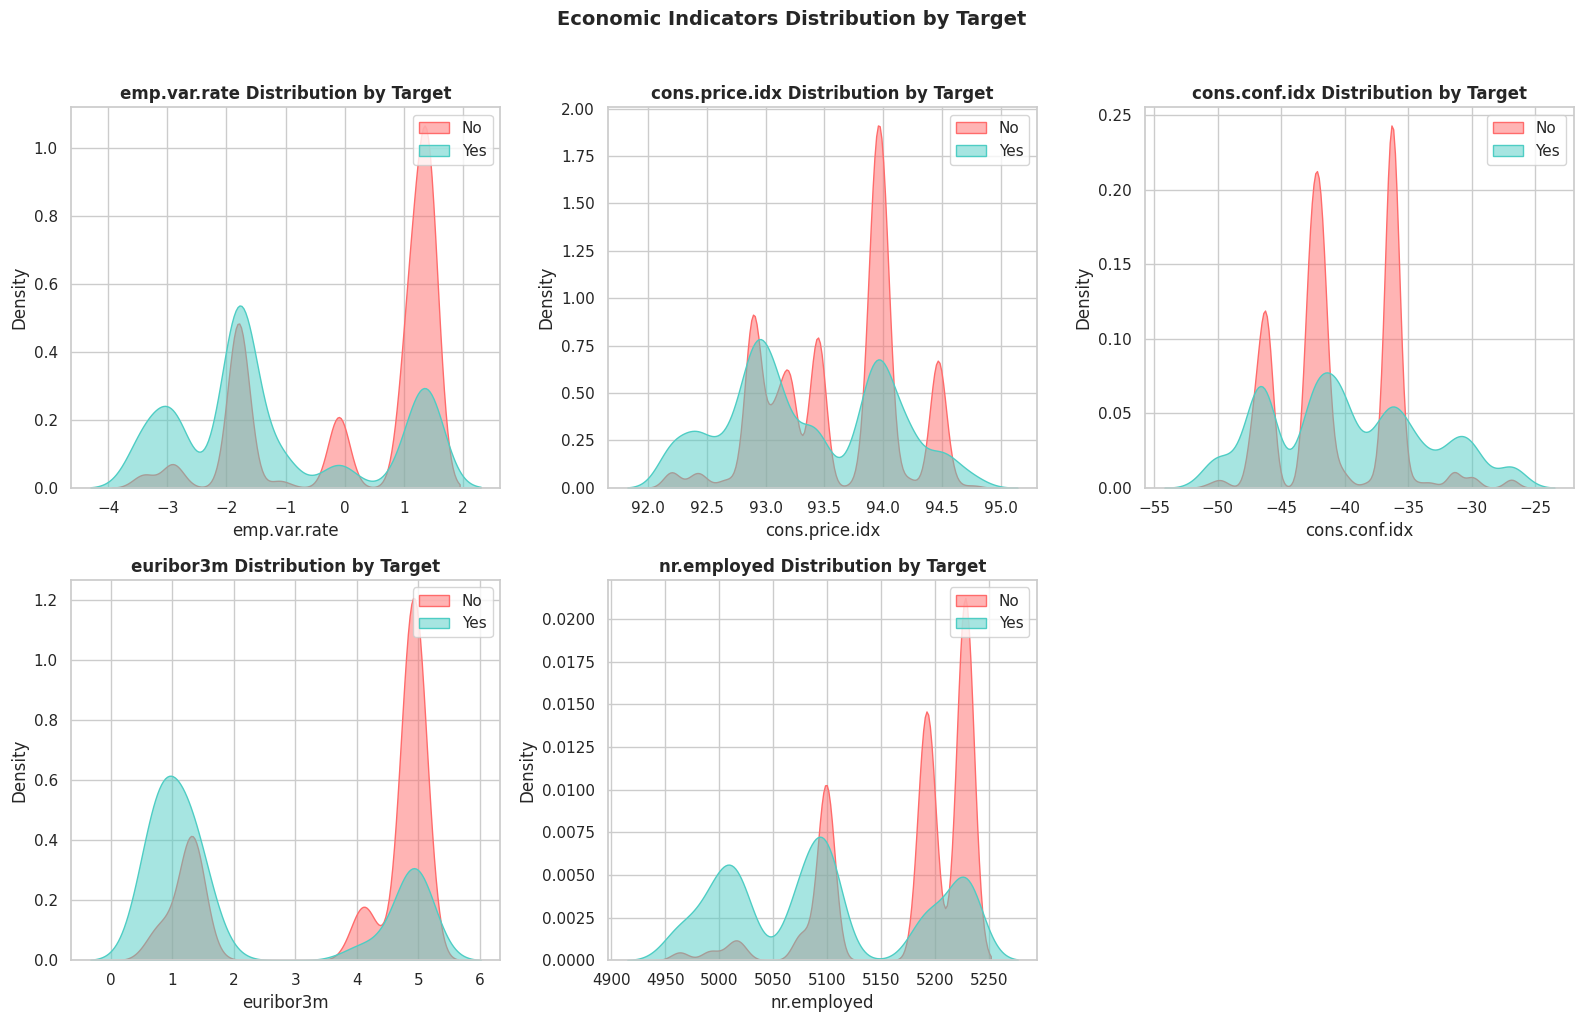

In [30]:
economic_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(economic_cols):
    # KDE plot by target
    sns.kdeplot(data=df[df['y']=='no'], x=col, ax=axes[i],
                color='#FF6B6B', fill=True, alpha=0.5, label='No')
    sns.kdeplot(data=df[df['y']=='yes'], x=col, ax=axes[i],
                color='#4ECDC4', fill=True, alpha=0.5, label='Yes')
    axes[i].set_title(f'{col} Distribution by Target', fontweight='bold')
    axes[i].legend()

# Remove empty subplot
axes[5].axis('off')

plt.suptitle('Economic Indicators Distribution by Target', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Lalu apakah hubungan tingkat variasi pekerjaan dilapangan berpengaruh besar bersamaan dengan consumer confident index(tingkat daya beli masyarakat) untuk mempengaruhi nasabah dengan profil nasabah tersebut akan berlangganan deposito?

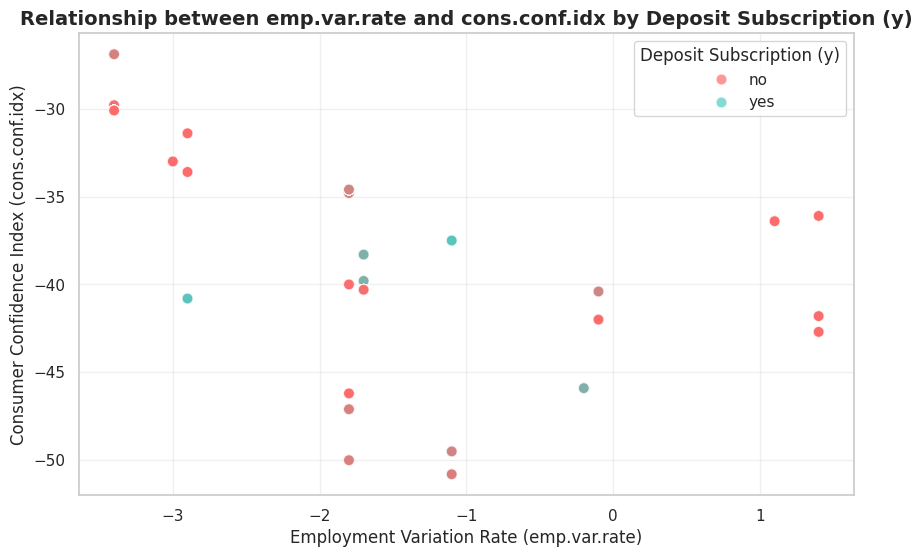

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='emp.var.rate',
    y='cons.conf.idx',
    hue='y',
    palette={'no': '#FF6B6B', 'yes': '#4ECDC4'},
    alpha=0.7,
    s=60
)

plt.title('Relationship between emp.var.rate and cons.conf.idx by Deposit Subscription (y)',
          fontsize=14, fontweight='bold')
plt.xlabel('Employment Variation Rate (emp.var.rate)')
plt.ylabel('Consumer Confidence Index (cons.conf.idx)')
plt.legend(title='Deposit Subscription (y)', loc='best')
plt.grid(True, alpha=0.3)

plt.show()

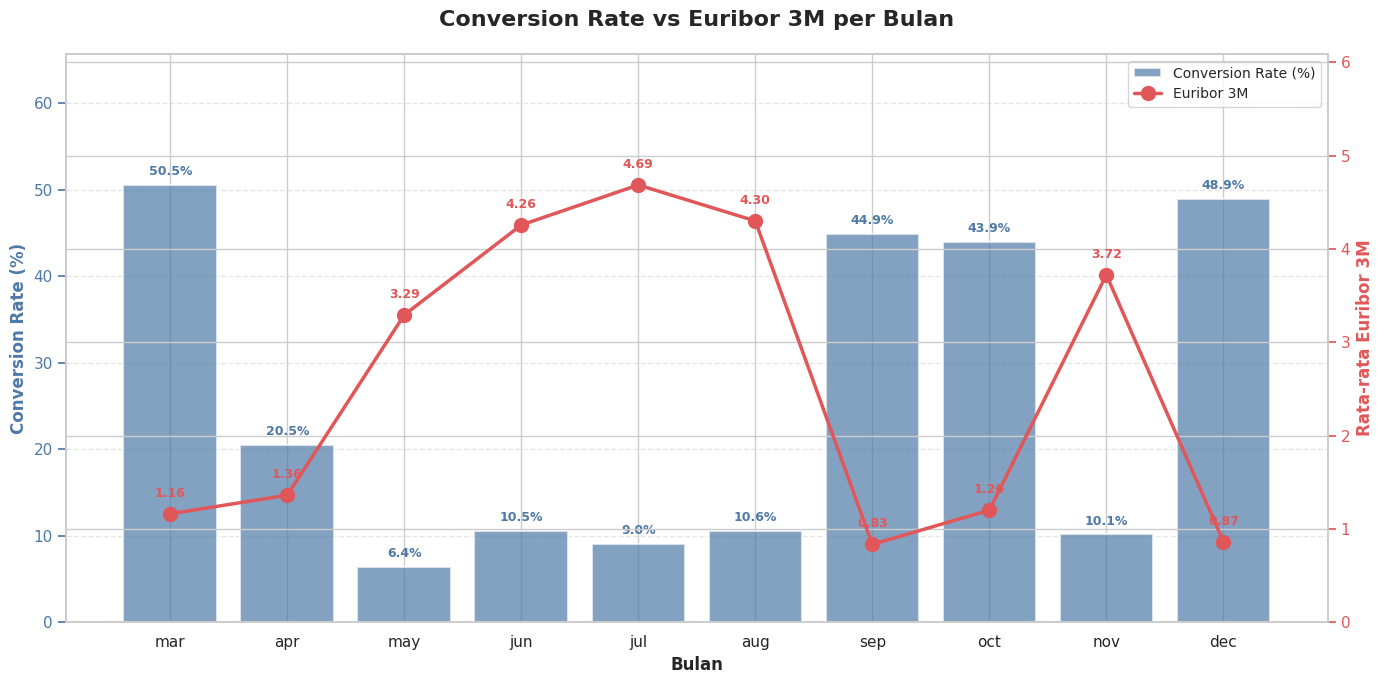


Korelasi antara Conversion Rate dan Euribor 3M: -0.8920


In [32]:
# --- 1. Persiapan Data ---

# Buat target numerik
df['target_num'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Urutan bulan yang benar
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Groupby per bulan
monthly_data = df.groupby('month').agg({
    'target_num': 'mean',
    'euribor3m': 'mean'
}).reset_index()

# Konversi ke persen
monthly_data['conversion_rate'] = monthly_data['target_num'] * 100

# Urutkan berdasarkan urutan bulan yang benar
monthly_data['month'] = pd.Categorical(monthly_data['month'], categories=month_order, ordered=True)
monthly_data = monthly_data.sort_values('month')

# --- 2. Visualisasi Dual Axis ---
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar Plot: Conversion Rate
bars = ax1.bar(
    monthly_data['month'],
    monthly_data['conversion_rate'],
    color='#4E79A7',
    alpha=0.7,
    label='Conversion Rate (%)',
    edgecolor='white',
    linewidth=1.5
)

# Tambah label nilai di atas bar
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=9, fontweight='bold', color='#4E79A7')

# Line Plot: Euribor 3M (sumbu Y kedua)
ax2 = ax1.twinx()
line = ax2.plot(
    monthly_data['month'],
    monthly_data['euribor3m'],
    marker='o',
    markersize=10,
    color='#E15759',
    linewidth=2.5,
    label='Euribor 3M'
)

# Tambah label nilai di titik garis
for i, (x, y) in enumerate(zip(monthly_data['month'], monthly_data['euribor3m'])):
    ax2.annotate(f'{y:.2f}',
                 xy=(i, y),
                 xytext=(0, 10),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=9, fontweight='bold', color='#E15759')

# --- 3. Styling ---

# Sumbu Y Kiri (Conversion Rate)
ax1.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold', color='#4E79A7')
ax1.tick_params(axis='y', colors='#4E79A7')
ax1.set_ylim(0, monthly_data['conversion_rate'].max() * 1.3)

# Sumbu Y Kanan (Euribor)
ax2.set_ylabel('Rata-rata Euribor 3M', fontsize=12, fontweight='bold', color='#E15759')
ax2.tick_params(axis='y', colors='#E15759')
ax2.set_ylim(0, monthly_data['euribor3m'].max() * 1.3)

# Sumbu X
ax1.set_xlabel('Bulan', fontsize=12, fontweight='bold')

# Judul
plt.title('Conversion Rate vs Euribor 3M per Bulan', fontsize=16, fontweight='bold', pad=20)

# Legend gabungan
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

# Grid
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.set_axisbelow(True)

plt.tight_layout()
plt.show()

# --- 4. Cek Korelasi ---
correlation = monthly_data['conversion_rate'].corr(monthly_data['euribor3m'])
print(f"\nKorelasi antara Conversion Rate dan Euribor 3M: {correlation:.4f}")

# Analisis Dampak Indikator Ekonomi Makro: Euribor 3M vs Conversion Rate

## 1. Pendahuluan
Visualisasi ini bertujuan untuk melihat hubungan antara kondisi ekonomi makro, yang diwakili oleh **Euribor 3M** (*Euro Interbank Offered Rate* - Suku bunga antar bank Eropa tenor 3 bulan), terhadap keputusan nasabah untuk membuka deposito (**Conversion Rate**).

*   **Sumbu Kiri (Bar Chart Biru):** Tingkat Konversi (% of Success).
*   **Sumbu Kanan (Line Chart Merah):** Rata-rata nilai Euribor 3M.
*   **Sumbu X:** Bulan.

---

## 2. Temuan Utama: Korelasi Negatif yang Kuat

Dari grafik di atas, terlihat pola yang sangat jelas: **Terdapat hubungan terbalik (Korelasi Negatif) antara suku bunga Euribor 3M dengan keberhasilan penjualan.**

### A. Zona Euribor Rendah = Konversi Tinggi (Maret, Sept, Okt, Des)
*   **Observasi:**
    *   Pada bulan **Maret**, **September**, **Oktober**, dan **Desember**, rata-rata Euribor 3M berada di titik rendah (sekitar **0.87** hingga **1.36**).
    *   Secara bersamaan, **Conversion Rate** melonjak drastis, mencapai angka tertinggi di **50.5%** (Maret) dan **48.9%** (Desember).
*   **Insight:**
    *   Ketika suku bunga pasar (Euribor) rendah, nasabah cenderung lebih tertarik pada tawaran deposito dari bank ini.
    *   Kemungkinan besar, suku bunga yang ditawarkan oleh bank dalam kampanye ini **lebih kompetitif** atau lebih menarik dibandingkan rata-rata pasar saat Euribor sedang lesu.

### B. Zona Euribor Tinggi = Konversi Anjlok (Mei - Agustus)
*   **Observasi:**
    *   Mulai bulan **Mei** hingga **Agustus**, tren Euribor naik tajam (mencapai puncaknya di **4.69** pada bulan Juli).
    *   Dampaknya langsung terasa: **Conversion Rate** jatuh bebas ke angka **single digit** (sekitar **6.4%** - **10.6%**).
    *   Fenomena serupa terjadi di bulan **November**, saat Euribor naik lagi ke **3.72**, konversi turun ke **10.1%**.
*   **Insight:**
    *   Saat suku bunga pasar tinggi, produk yang ditawarkan bank menjadi **kurang menarik**.
    *   Nasabah mungkin lebih memilih instrumen investasi lain yang mengikuti kenaikan suku bunga pasar, atau tawaran bank ini bersifat *fixed rate* yang nilainya di bawah Euribor saat itu, sehingga nasabah merasa rugi jika mengambilnya.

---

## 3. Analisis Perilaku Nasabah (Customer Behavior)

Grafik ini mengindikasikan bahwa nasabah target sangat **sensitif terhadap suku bunga (Rate Sensitive)**.

1.  **Smart Money:** Nasabah memantau kondisi pasar. Mereka tidak mengambil produk deposito ketika indikator Euribor sedang tinggi-tingginya, mungkin karena mereka mengharapkan *return* yang lebih tinggi dari yang ditawarkan bank.
2.  **Produk Tidak Kompetitif:** Ada kemungkinan bank tidak menyesuaikan (adjust) bunga deposito yang ditawarkan secepat perubahan Euribor. Jika Euribor naik jadi 4%, tapi bank masih menawarkan bunga 2%, wajar jika konversi rendah.

---

## 4. Rekomendasi Strategis

Berdasarkan data ini, tim marketing dan produk harus berkolaborasi:

1.  **Dynamic Pricing Strategy:**
    *   Suku bunga deposito yang ditawarkan dalam kampanye **harus disesuaikan** mengikuti pergerakan Euribor. Jangan menawarkan bunga "standar" saat Euribor sedang melambung tinggi.

2.  **Timing Kampanye:**
    *   Jika bank tidak bisa menaikkan bunga deposito (karena batasan margin), **hindari kampanye agresif saat Euribor sedang tinggi** (seperti bulan Mei-Juli). Itu hanya membuang biaya operasional karena probabilitas penolakan sangat tinggi.
    *   Simpan tenaga dan biaya marketing untuk periode saat Euribor stabil atau rendah (seperti Maret, Sep, Okt, Des), di mana nasabah terbukti lebih mudah dikonversi ("Panen Raya").

3.  **Penyesuaian messaging**
   - Saat Euribor tinggi: perkuat “urgency” dan value proposition (mis. kepastian imbal hasil/benefit lain).
   - Saat Euribor rendah tapi conversion tinggi (mis. Desember): maksimalkan kapasitas tim karena *propensity to convert* sedang bagus.

### Lalu apakah naik-turunnya harga barang/jasa (inflasi) memengaruhi keputusan nasabah untuk melakukan konversi (membeli produk/layanan).

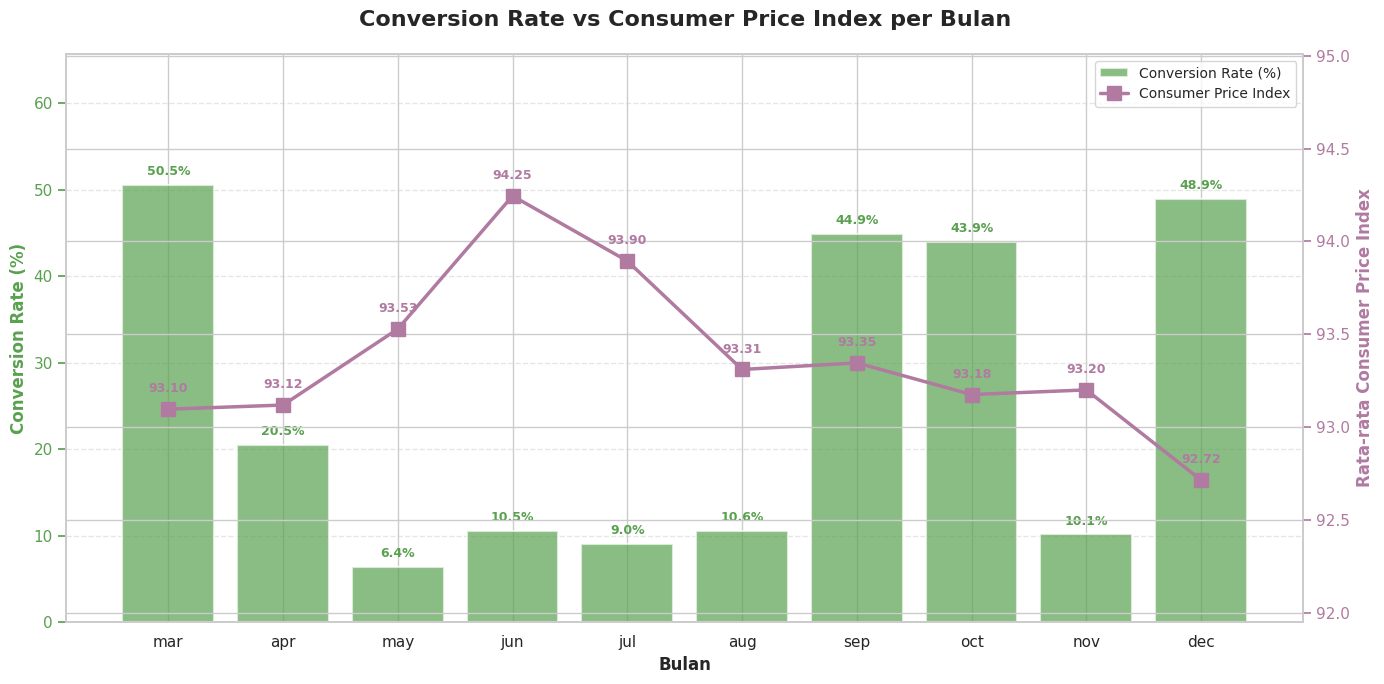


Korelasi Conversion Rate vs Consumer Price Index: -0.6232

--- Ringkasan Data per Bulan ---
Bulan  Conversion Rate (%)  Consumer Price Index
  mar            50.549451             93.097330
  apr            20.486507             93.119575
  may             6.435680             93.528894
  jun            10.511470             94.245402
  jul             9.038918             93.895109
  aug            10.605570             93.311022
  sep            44.912281             93.346474
  oct            43.933054             93.176145
  nov            10.146341             93.200944
  dec            48.901099             92.715363


In [33]:
# --- 1. Persiapan Data ---

# Buat target numerik
df['target_num'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Urutan bulan yang benar
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Groupby per bulan
monthly_data = df.groupby('month').agg({
    'target_num': 'mean',
    'cons.price.idx': 'mean'
}).reset_index()

# Konversi ke persen
monthly_data['conversion_rate'] = monthly_data['target_num'] * 100

# Urutkan berdasarkan urutan bulan
monthly_data['month'] = pd.Categorical(monthly_data['month'], categories=month_order, ordered=True)
monthly_data = monthly_data.sort_values('month')

# --- 2. Visualisasi Dual Axis ---
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar Plot: Conversion Rate
bars = ax1.bar(
    monthly_data['month'],
    monthly_data['conversion_rate'],
    color='#59A14F',
    alpha=0.7,
    label='Conversion Rate (%)',
    edgecolor='white',
    linewidth=1.5
)

# Label di atas bar
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=9, fontweight='bold', color='#59A14F')

# Line Plot: Consumer Price Index (sumbu Y kedua)
ax2 = ax1.twinx()
line = ax2.plot(
    monthly_data['month'],
    monthly_data['cons.price.idx'],
    marker='s',
    markersize=10,
    color='#B07AA1',
    linewidth=2.5,
    label='Consumer Price Index'
)

# Label di titik garis
for i, (x, y) in enumerate(zip(monthly_data['month'], monthly_data['cons.price.idx'])):
    ax2.annotate(f'{y:.2f}',
                 xy=(i, y),
                 xytext=(0, 10),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=9, fontweight='bold', color='#B07AA1')

# --- 3. Styling ---

# Sumbu Y Kiri (Conversion Rate)
ax1.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold', color='#59A14F')
ax1.tick_params(axis='y', colors='#59A14F')
ax1.set_ylim(0, monthly_data['conversion_rate'].max() * 1.3)

# Sumbu Y Kanan (CPI)
ax2.set_ylabel('Rata-rata Consumer Price Index', fontsize=12, fontweight='bold', color='#B07AA1')
ax2.tick_params(axis='y', colors='#B07AA1')

# Atur range Y2 agar variasi terlihat jelas
cpi_min = monthly_data['cons.price.idx'].min()
cpi_max = monthly_data['cons.price.idx'].max()
cpi_padding = (cpi_max - cpi_min) * 0.5
ax2.set_ylim(cpi_min - cpi_padding, cpi_max + cpi_padding)

# Sumbu X
ax1.set_xlabel('Bulan', fontsize=12, fontweight='bold')

# Judul
plt.title('Conversion Rate vs Consumer Price Index per Bulan',
          fontsize=16, fontweight='bold', pad=20)

# Legend gabungan
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

# Grid
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.set_axisbelow(True)

plt.tight_layout()
plt.show()

# --- 4. Korelasi ---
correlation = monthly_data['conversion_rate'].corr(monthly_data['cons.price.idx'])
print(f"\nKorelasi Conversion Rate vs Consumer Price Index: {correlation:.4f}")

# --- 5. Tabel Ringkasan ---
print("\n--- Ringkasan Data per Bulan ---")
summary = monthly_data[['month', 'conversion_rate', 'cons.price.idx']].copy()
summary.columns = ['Bulan', 'Conversion Rate (%)', 'Consumer Price Index']
print(summary.to_string(index=False))

# Analisis: Conversion Rate vs Consumer Price Index (CPI) per Bulan

## 1) Apa yang ditampilkan grafik?
Grafik ini membandingkan hubungan antara dua variabel sepanjang tahun (Maret - Desember):
- **Batang Hijau (Sumbu Kiri):** *Conversion Rate (%)* (Tingkat keberhasilan konversi).
- **Garis Ungu (Sumbu Kanan):** *Consumer Price Index / CPI* (Indeks Harga Konsumen - indikator inflasi).

---

## 2) Pola Utama & Observasi Data

### A. Pola Hubungan Terbalik (Inverse Relationship)
Secara umum, terlihat adanya korelasi negatif: **Saat CPI naik (harga-harga mahal), Conversion Rate cenderung turun.**

- **Periode CPI Tinggi (Mei - Juli):**
  - Pada bulan **Juni**, CPI mencapai puncaknya di angka **94.25**.
  - Di saat yang sama, conversion rate berada di level yang sangat rendah (**10.5%**).
  - Bulan Mei (CPI 93.53) dan Juli (CPI 93.90) juga menunjukkan tren serupa: CPI tinggi, konversi di bawah 10%.

- **Periode CPI Rendah (Maret, Sep, Okt, Des):**
  - **Maret:** CPI rendah (~93.10), Conversion Rate tinggi (**50.5%**).
  - **Desember:** CPI terendah (~92.72), Conversion Rate tinggi (**48.9%**).
  - **September & Oktober:** CPI stabil di angka rendah (~93.3), Conversion Rate melonjak ke **44.9%** dan **43.9%**.

### B. Anomali Bulan November
- **Bulan November** menarik karena menyimpang dari pola umum.
- CPI berada di angka rendah (**93.20**), mirip dengan Oktober.
- Namun, **Conversion Rate anjlok drastis ke 10.1%** (padahal di Oktober 43.9%).
- *Hipotesis:* Ada faktor lain di bulan November (bukan CPI) yang membuat performa turun, misalnya habisnya budget marketing, perubahan strategi, atau faktor musiman spesifik sebelum libur akhir tahun.

---

## 3) Interpretasi Bisnis

1.  **Daya Beli Menurun (Purchasing Power):**
    - CPI yang tinggi mengindikasikan harga barang-barang kebutuhan naik (inflasi).
    - Ketika biaya hidup naik, nasabah cenderung lebih berhemat ("tightening the belt") dan menunda keputusan finansial non-pokok. Ini menjelaskan mengapa konversi rendah saat garis ungu memuncak.

2.  **Sentimen Ekonomi:**
    - Berita tentang kenaikan indeks harga sering membuat konsumen pesimis atau "wait and see", sehingga sulit bagi tim sales untuk melakukan closing (konversi).

3.  **Desember "Spending/Optimism":**
    - Di bulan Desember, CPI turun ke titik terendah (92.72).
    - Dikombinasikan dengan sentimen akhir tahun (bonus, liburan, optimisme tahun baru), kemudahan ekonomi (harga stabil) mendorong konversi naik tinggi lagi.

---

## 4) Kesimpulan Analisis
- Terdapat **indikasi kuat hubungan negatif** antara CPI dan Conversion Rate: Semakin tinggi tekanan harga (CPI), semakin sulit mendapatkan konversi.
- **Mei hingga Agustus** adalah "Masa Sulit" di mana faktor makroekonomi (harga tinggi) mungkin menjadi penghambat utama kinerja sales.
- **November** adalah *outlier* yang perlu diselidiki lebih lanjut karena penurunan performa tidak disebabkan oleh kenaikan harga (CPI stabil).

---

## 5) Rekomendasi Action Plan

1.  **Strategi saat CPI Tinggi (Mei-Agustus):**
    - Jangan gunakan *hard selling* biasa.
    - Tawarkan promosi yang sensitif terhadap harga (diskon, cashback, atau cicilan ringan) untuk melawan efek psikologis dari kenaikan harga barang.
    - Fokuskan targeting pada segmen nasabah *High Net Worth* yang kurang terdampak oleh fluktuasi CPI harian.

2.  **Investigasi Bulan November:**
    - Lakukan *deep dive* data operasional bulan November. Apakah server down? Apakah jumlah lead berkurang? Kenapa konversi jatuh padahal kondisi makro (CPI) kondusif?

3.  **Maksimalkan Momentum Akhir Tahun & Awal Tahun:**
    - Maret, September, Oktober, dan Desember adalah bulan emas. Alokasikan budget marketing terbesar di bulan-bulan ini karena resistensi pasar (dari sisi harga) paling rendah.

### Apakah Keyakinan Konsumen Mempengaruhi Keputusan Membuka Deposito?

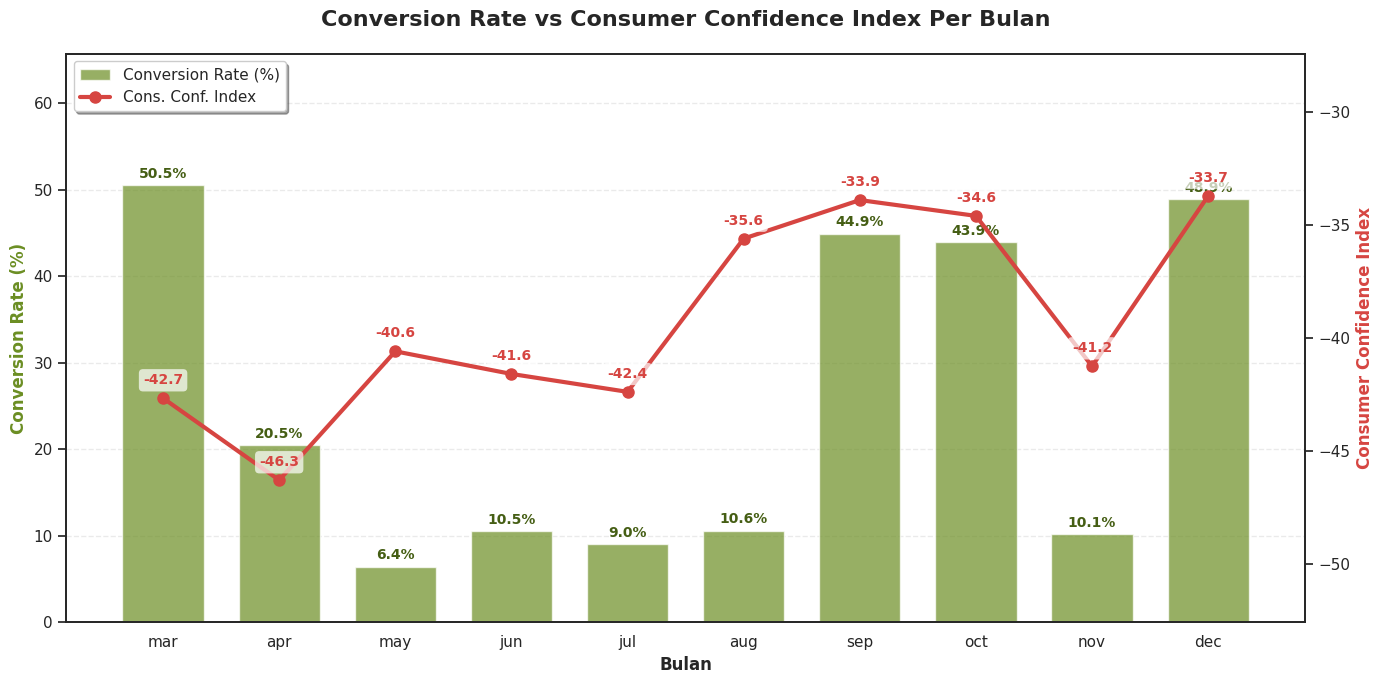

In [34]:
# Buat target numerik (1 = yes, 0 = no)
df['target_num'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Tentukan urutan bulan agar tidak berantakan (alfabetis vs kronologis)
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Groupby per Bulan untuk mendapatkan rata-rata
monthly_data = df.groupby('month').agg({
    'target_num': 'mean',        # Untuk Conversion Rate
    'cons.conf.idx': 'mean'      # Untuk Consumer Confidence Index
}).reset_index()

# Hitung Conversion Rate dalam Persen
monthly_data['conversion_rate'] = monthly_data['target_num'] * 100

# Pastikan urutan bulan benar
monthly_data['month'] = pd.Categorical(monthly_data['month'], categories=month_order, ordered=True)
monthly_data = monthly_data.sort_values('month')

# ---------------------------------------------------------
# 3. VISUALISASI DATA (Dual Axis: Bar + Line)
# ---------------------------------------------------------

# Mengatur style agar background bersih
sns.set_style("white")

fig, ax1 = plt.subplots(figsize=(14, 7))

# --- BAGIAN 1: BAR PLOT (Conversion Rate) ---
bars = ax1.bar(
    monthly_data['month'],
    monthly_data['conversion_rate'],
    color='#6B8E23',       # Warna Olive Green (Mirip referensi tapi lebih segar)
    alpha=0.7,
    label='Conversion Rate (%)',
    edgecolor='white',
    width=0.7
)

# Menambahkan Label Angka di atas Bar
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f'{height:.1f}%',
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='#455e14'
    )

# --- BAGIAN 2: LINE PLOT (Consumer Confidence Index) ---
ax2 = ax1.twinx() # Membuat sumbu Y kedua di kanan

line = ax2.plot(
    monthly_data['month'],
    monthly_data['cons.conf.idx'],
    color='#D64541',       # Warna Merah Bata
    marker='o',            # Marker bulat
    markersize=8,
    linewidth=3,
    label='Cons. Conf. Index'
)

# Menambahkan Label Angka pada Line
# Karena cons.conf.idx biasanya negatif, kita taruh label sedikit di atas titiknya
for i, txt in enumerate(monthly_data['cons.conf.idx']):
    ax2.annotate(
        f'{txt:.1f}',
        (i, txt),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=10, fontweight='bold', color='#D64541',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7) # Background putih transparan biar terbaca
    )

# ---------------------------------------------------------
# 4. FINALISASI & STYLING (Agar Menarik)
# ---------------------------------------------------------

# Judul Utama
plt.title('Conversion Rate vs Consumer Confidence Index Per Bulan', fontsize=16, fontweight='bold', pad=20)

# Label Sumbu
ax1.set_xlabel('Bulan', fontsize=12, fontweight='bold')
ax1.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold', color='#6B8E23')
ax2.set_ylabel('Consumer Confidence Index', fontsize=12, fontweight='bold', color='#D64541')

# Mengatur Grid (Hanya Horizontal tipis)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
ax1.set_axisbelow(True)

# Mengatur Batas Sumbu Y agar visual lebih lega
ax1.set_ylim(0, monthly_data['conversion_rate'].max() * 1.3) # Memberi ruang kepala untuk bar
# Trik agar Line chart posisinya pas di tengah-tengah visual (karena nilainya negatif)
y2_min = monthly_data['cons.conf.idx'].min()
y2_max = monthly_data['cons.conf.idx'].max()
padding = (y2_max - y2_min) * 0.5
ax2.set_ylim(y2_min - padding, y2_max + padding)

# Menggabungkan Legend (Bar dan Line jadi satu kotak)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=11, frameon=True, shadow=True)

plt.tight_layout()
plt.show()

## Analisis Insight Data

Berdasarkan grafik di atas, kita dapat mengamati pola perilaku nasabah terhadap kondisi ekonomi:

1.  **High Season (Mar, Sep, Oct, Dec):**
    *   Bulan-bulan ini memiliki **Conversion Rate tertinggi** (di atas 40%).
    *   Menariknya, tingkat kepercayaan konsumen (**Line Merah**) bervariasi. Di bulan **Maret**, meskipun kepercayaan konsumen rendah (-42.7), konversi justru sangat tinggi (50.5%). Ini mungkin menunjukkan adanya faktor *seasonality* atau penawaran khusus akhir kuartal yang lebih kuat pengaruhnya daripada sentimen ekonomi.

2.  **Low Season (May - Aug):**
    *   Terjadi penurunan drastis pada Conversion Rate (< 11%).
    *   Pada periode ini, *Consumer Confidence Index* sebenarnya relatif membaik (naik dari -46.3 ke -35.6 di Agustus), namun hal ini **tidak berkorelasi positif** dengan jumlah nasabah yang melakukan deposit.

3.  **Kesimpulan:**
    Tampaknya **Consumer Confidence Index** bukan satu-satunya penentu keberhasilan kampanye. Ada indikasi kuat bahwa **faktor musiman (bulan)** memiliki dampak yang lebih signifikan, di mana nasabah cenderung lebih aktif di awal musim semi (Maret) dan musim gugur/dingin (Sep-Des).

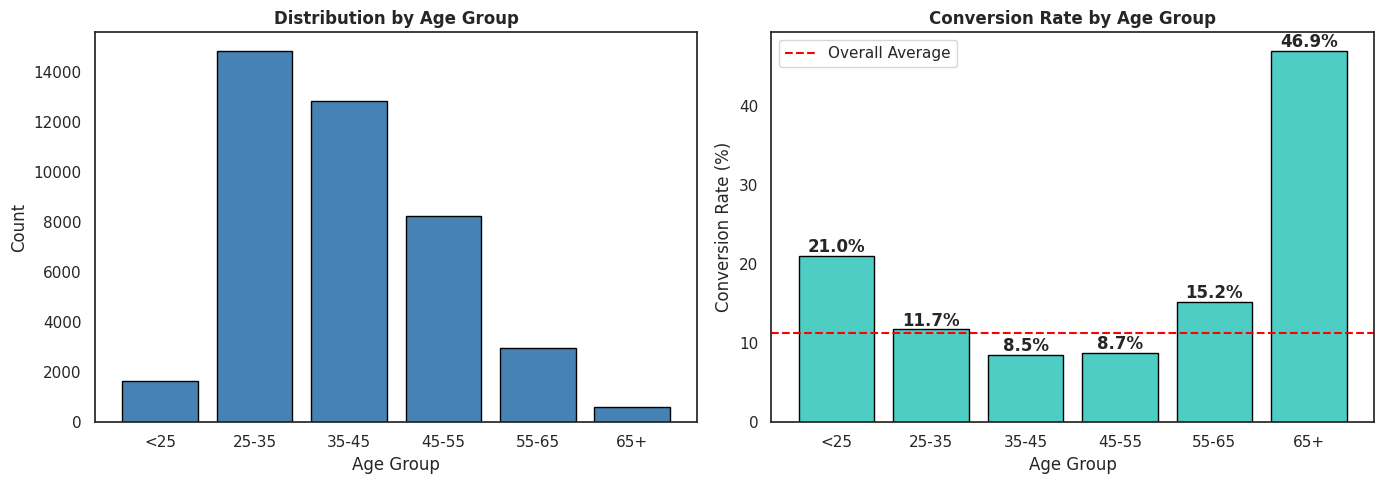

In [35]:
# Create age groups
df['age_group'] = pd.cut(df['age'],
                          bins=[0, 25, 35, 45, 55, 65, 100],
                          labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+'])

# Conversion rate by age group
age_analysis = df.groupby('age_group').agg(
    Count=('y', 'count'),
    Conversion_Rate=('y', lambda x: (x == 'yes').sum() / len(x) * 100)
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count
axes[0].bar(age_analysis['age_group'], age_analysis['Count'], color='steelblue', edgecolor='black')
axes[0].set_title('Distribution by Age Group', fontweight='bold')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Count')

# Conversion rate
bars = axes[1].bar(age_analysis['age_group'], age_analysis['Conversion_Rate'],
                   color='#4ECDC4', edgecolor='black')
axes[1].axhline(y=(df['y']=='yes').mean()*100, color='red', linestyle='--', label='Overall Average')
axes[1].set_title('Conversion Rate by Age Group', fontweight='bold')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Conversion Rate (%)')
axes[1].legend()

# Add labels
for bar, val in zip(bars, age_analysis['Conversion_Rate']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Analisis: Distribusi Pelanggan & Tingkat Konversi Berdasarkan Umur

Analisis ini membedah dua grafik yang saling berkaitan:
1.  **Grafik Kiri (Biru Tua):** Jumlah total nasabah/prospek per kelompok umur *(Volume)*.
2.  **Grafik Kanan (Tosca):** Persentase keberhasilan konversi per kelompok umur *(Efisiensi)*.

---

## 1) Observasi Data Utama

### A. Paradoks Volume vs Efisiensi
Terdapat fenomena menarik di mana **kelompok umur dengan populasi terbesar justru memiliki tingkat konversi terendah**, dan sebaliknya.

*   **Volume Terbesar (Dominasi Pasar):**
    *   Kelompok umur **25-35 tahun** dan **35-45 tahun** mendominasi basis data pelanggan (batang biru paling tinggi).
    *   Namun, performa konversi mereka justru di bawah rata-rata (hanya **11.7%** dan **8.5%**).

*   **Volume Terkecil (Niche Market):**
    *   Kelompok umur **65+ tahun** memiliki jumlah pelanggan paling sedikit.
    *   Namun, mereka mencatat **Conversion Rate Tertinggi (46.9%)**. Hampir 1 dari 2 orang tua di grup ini melakukan konversi.

### B. Pola "U-Shape" pada Conversion Rate
Jika dilihat pada grafik kanan, tren konversi membentuk pola huruf "U":
1.  **Tinggi di Awal (<25 Tahun):** Generasi termuda cukup mudah dikonversi (**21.0%**).
2.  **Turun di Tengah (30-55 Tahun):** Usia produktif/kerja memiliki tingkat konversi terendah (**~8.5% - 11%**).
3.  **Melonjak di Akhir (>60 Tahun):** Usia pensiun memiliki tingkat konversi yang sangat masif (**46.9%**).

---

## 2) Interpretasi Bisnis & Perilaku Konsumen

### Mengapa Lansia (65+) Sangat Mudah Dikonversi?
Meskipun jumlahnya sedikit, tingkat kesuksesan hampir 50% menunjukkan:
*   **Kesesuaian Produk:** Produk yang ditawarkan mungkin sangat relevan dengan kebutuhan pensiunan (misal: deposito aman, asuransi kesehatan, atau investasi konservatif).
*   **Waktu Luang:** Mereka mungkin memiliki lebih banyak waktu untuk mendengarkan penawaran sales dibandingkan usia produktif yang sibuk.
*   **Kekuatan Finansial:** Kelompok ini cenderung memiliki tabungan yang mapan dibanding generasi muda.

### Mengapa Usia Produktif (35-55) Sulit Dikonversi?
Ini adalah "Generasi Sandwich" dengan beban finansial tertinggi (cicilan rumah, biaya anak, dll).
*   Meskipun mereka adalah mayoritas populasi (target pasar utama), mereka sangat selektif dan sensitif terhadap pengeluaran.
*   Rendahnya konversi (8% - 9%) menunjukkan strategi marketing saat ini kurang efektif memikat segmen yang paling sibuk ini.

---

## 3) Rekomendasi Action Plan

1.  **Strategi untuk "Cash Cow" (Usia 25-45):**
    *   Karena ini adalah segmen dengan volume terbesar, peningkatan konversi kecil saja (misal dari 8.5% ke 10%) akan berdampak besar pada *revenue* total.
    *   *Saran:* Tawarkan produk yang solutif untuk masalah mereka (kebutuhan likuiditas, dana pendidikan anak) dan permudah proses (digital/cepat) karena mereka sibuk.

2.  **Eksploitasi Potensi Lansia (65+):**
    *   Konversi 46.9% adalah angka yang luar biasa. Sayangnya, jumlah datanya (volume) sangat sedikit.
    *   *Saran:* Cari cara untuk mengakuisisi lebih banyak leads/prospek di usia 60 ke atas. Jika volume leads ini bisa dinaikkan, revenue akan melonjak drastis karena *success rate*-nya sudah terbukti tinggi.

3.  **Pertahankan Generasi Muda (<25):**
    *   Dengan konversi 21%, ini adalah segmen potensial kedua.
    *   *Saran:* Pertahankan pendekatan saat ini, namun pastikan produk memiliki *entry-level* yang terjangkau karena daya beli mereka belum sekuat usia mapan.

### Campaign Effectiveness Analysis

Menganalisis efektivitas jumlah kontak - apakah lebih banyak kontak berarti lebih baik?

In [36]:
# 1. Menghitung efektivitas campaign
campaign_analysis = df.groupby('campaign').agg(
    Count=('y', 'count'),
    # Menghitung jumlah 'yes' secara manual jika kolom belum numeric 1/0
    Conversions=('y', lambda x: (x == 'yes').sum()),
    # Menghitung persentase conversion
    Conversion_Rate=('y', lambda x: (x == 'yes').sum() / len(x) * 100)
).reset_index()

# 2. Filter data agar sample size bermakna (minimal 50 orang per jumlah kontak)
campaign_analysis_filtered = campaign_analysis[campaign_analysis['Count'] >= 50]

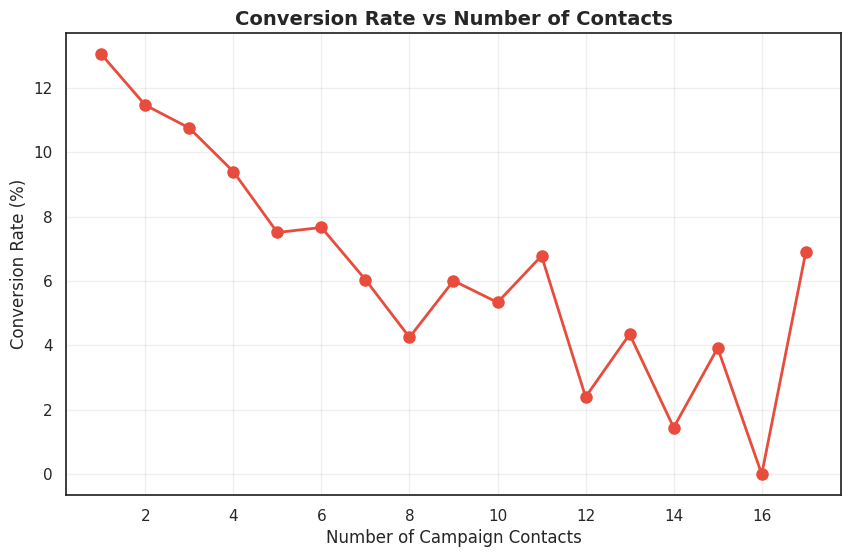

In [37]:
# Membuat canvas baru untuk grafik pertama
plt.figure(figsize=(10, 6))

# Plotting Line Chart
plt.plot(campaign_analysis_filtered['campaign'],
         campaign_analysis_filtered['Conversion_Rate'],
         marker='o', linewidth=2, markersize=8, color='#e74c3c')

# Menambahkan label dan judul
plt.title('Conversion Rate vs Number of Contacts', fontweight='bold', fontsize=14)
plt.xlabel('Number of Campaign Contacts', fontsize=12)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3)

# Menampilkan grafik
plt.show()

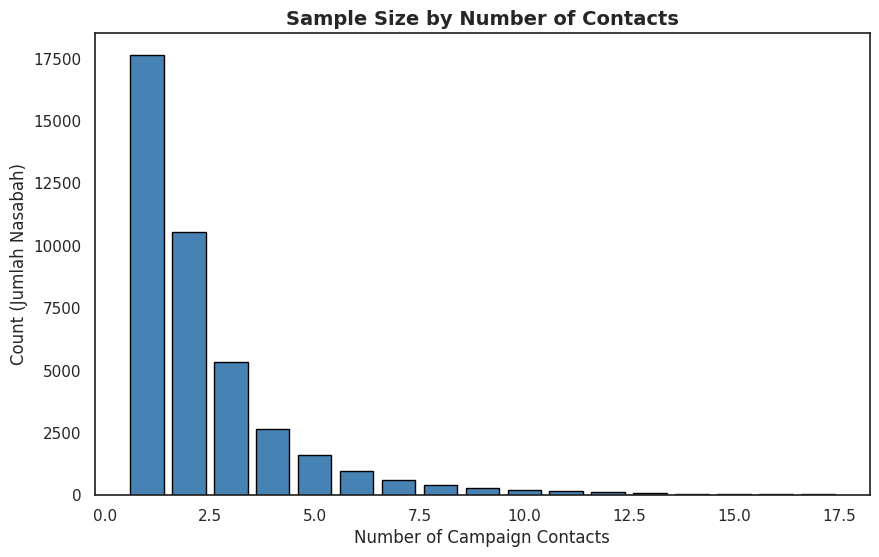

In [38]:
# Membuat canvas baru untuk grafik kedua
plt.figure(figsize=(10, 6))

# Plotting Bar Chart
plt.bar(campaign_analysis_filtered['campaign'],
        campaign_analysis_filtered['Count'],
        color='steelblue', edgecolor='black')

# Menambahkan label dan judul
plt.title('Sample Size by Number of Contacts', fontweight='bold', fontsize=14)
plt.xlabel('Number of Campaign Contacts', fontsize=12)
plt.ylabel('Count (Jumlah Nasabah)', fontsize=12)

# Menampilkan grafik
plt.show()

#### **Insight: Campaign Effectiveness**

Analisis menunjukkan adanya **diminishing returns** pada jumlah kontak:

- Kontak pertama memiliki conversion rate tertinggi (~12%)
- Setelah 3 kontak, conversion rate mulai turun signifikan
- Lebih dari 5 kontak, conversion rate turun drastis ke <5%

**Kesimpulan:** Terlalu sering menghubungi nasabah justru counterproductive. Rekomendasi: batasi maksimal 3 kontak per nasabah per campaign.

### Distribusi Variabel Loan dan Housing

Melihat sebaran data untuk memahami komposisi nasabah berdasarkan status pinjaman.

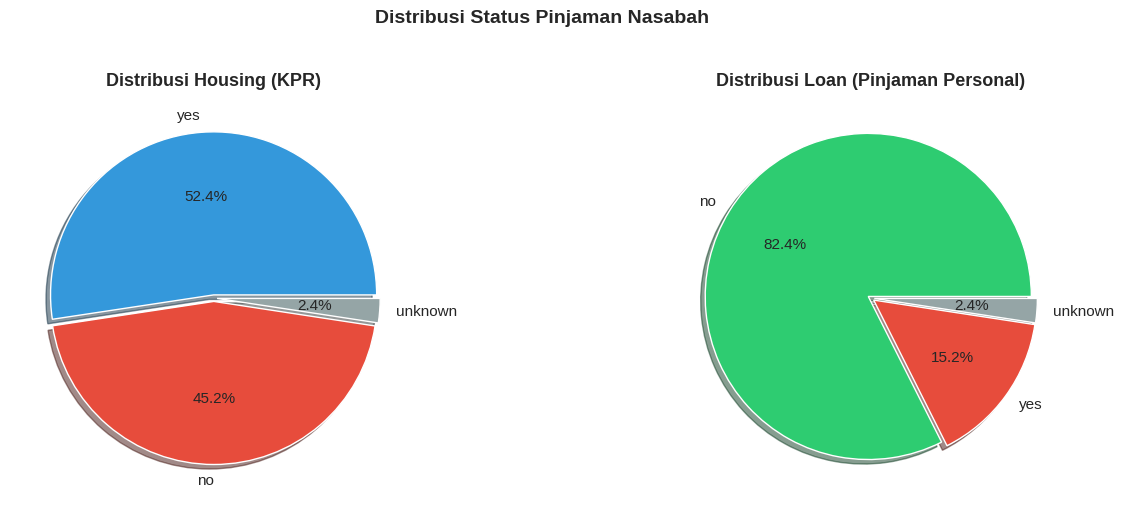

DISTRIBUSI STATUS PINJAMAN

HOUSING (KPR):
   • yes     : 21,571 ( 52.4%)
   • no      : 18,615 ( 45.2%)
   • unknown :    990 (  2.4%)

LOAN (Pinjaman Personal):
   • no      : 33,938 ( 82.4%)
   • yes     :  6,248 ( 15.2%)
   • unknown :    990 (  2.4%)


In [39]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Distribusi Housing dan Loan
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Housing distribution
housing_counts = df['housing'].value_counts()
colors_housing = ['#3498db', '#e74c3c', '#95a5a6']
axes[0].pie(housing_counts.values, labels=housing_counts.index, autopct='%1.1f%%',
            colors=colors_housing, explode=[0.02]*len(housing_counts), shadow=True,
            textprops={'fontsize': 11})
axes[0].set_title('Distribusi Housing (KPR)', fontsize=13, fontweight='bold')

# Loan distribution
loan_counts = df['loan'].value_counts()
colors_loan = ['#2ecc71', '#e74c3c', '#95a5a6']
axes[1].pie(loan_counts.values, labels=loan_counts.index, autopct='%1.1f%%',
            colors=colors_loan, explode=[0.02]*len(loan_counts), shadow=True,
            textprops={'fontsize': 11})
axes[1].set_title('Distribusi Loan (Pinjaman Personal)', fontsize=13, fontweight='bold')

plt.suptitle('Distribusi Status Pinjaman Nasabah', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print statistics
print("="*60)
print("DISTRIBUSI STATUS PINJAMAN")
print("="*60)

print("\nHOUSING (KPR):")
for val, count in housing_counts.items():
    pct = count / len(df) * 100
    print(f"   • {val:8}: {count:>6,} ({pct:>5.1f}%)")

print("\nLOAN (Pinjaman Personal):")
for val, count in loan_counts.items():
    pct = count / len(df) * 100
    print(f"   • {val:8}: {count:>6,} ({pct:>5.1f}%)")

### Pengaruh Status Pinjaman (Housing & Personal Loan) terhadap Konversi Nasabah untuk Deposito

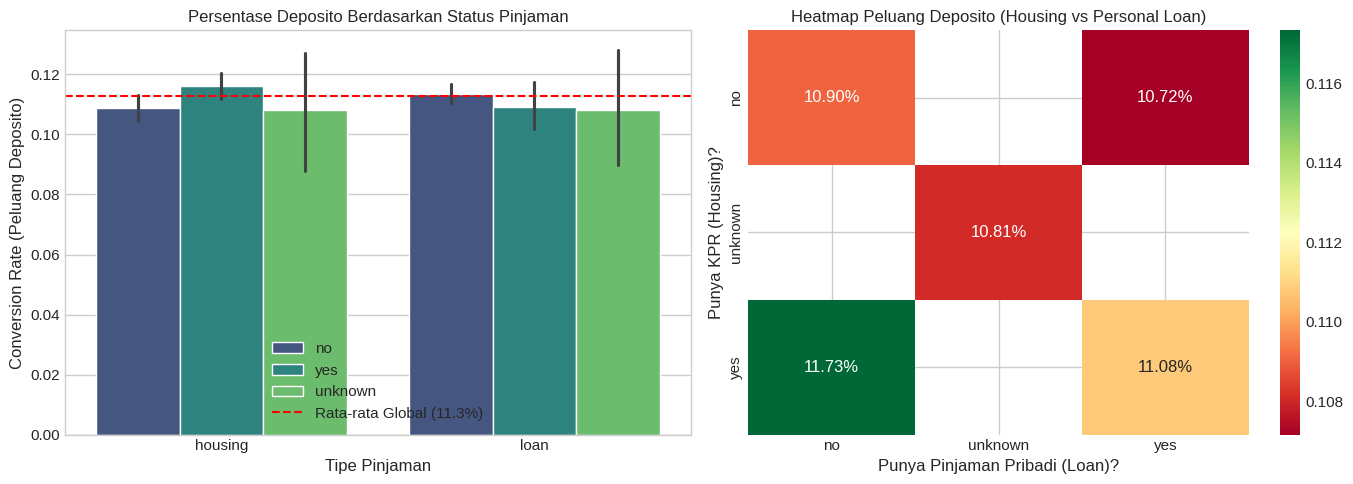

In [40]:
df['target_num'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Mengatur ukuran canvas gambar
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ---------------------------------------------------------
# Visualisasi 1: Pengaruh Individu (Bar Chart)
# ---------------------------------------------------------
# Kita gabungkan data agar bisa di-plot berdampingan (Melt)
df_melted = df.melt(id_vars=['target_num'], value_vars=['housing', 'loan'],
                    var_name='Jenis Pinjaman', value_name='Status Pinjaman')

# Plotting
sns.barplot(data=df_melted, x='Jenis Pinjaman', y='target_num', hue='Status Pinjaman',
            palette='viridis', ax=ax[0])

ax[0].set_title('Persentase Deposito Berdasarkan Status Pinjaman')
ax[0].set_ylabel('Conversion Rate (Peluang Deposito)')
ax[0].set_xlabel('Tipe Pinjaman')
# Menambahkan garis rata-rata global sebagai acuan
global_rate = df['target_num'].mean()
ax[0].axhline(global_rate, color='red', linestyle='--', label=f'Rata-rata Global ({global_rate:.1%})')
ax[0].legend()

# ---------------------------------------------------------
# Visualisasi 2: Interaksi Keduanya (Heatmap)
# ---------------------------------------------------------
# Kita ingin melihat kombinasi: Punya Housing YA + Punya Loan YA = ?
pivot_table = df.pivot_table(index='housing', columns='loan', values='target_num', aggfunc='mean')

sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap='RdYlGn', cbar=True, ax=ax[1])

ax[1].set_title('Heatmap Peluang Deposito (Housing vs Personal Loan)')
ax[1].set_ylabel('Punya KPR (Housing)?')
ax[1].set_xlabel('Punya Pinjaman Pribadi (Loan)?')

plt.tight_layout()
plt.show()

### Analisis Pengaruh Status Pinjaman (Housing & Personal Loan) terhadap Konversi

Visualisasi di atas bertujuan untuk melihat apakah beban finansial nasabah (berupa cicilan rumah atau pinjaman pribadi) mempengaruhi keputusan mereka untuk membuka deposito berjangka.

#### 1. Bar Chart: Persentase Deposito Berdasarkan Tipe Pinjaman (Kiri)
Grafik ini membandingkan rata-rata *Conversion Rate* secara individu untuk fitur `housing` (KPR) dan `loan` (Pinjaman Pribadi).
*   **Garis Merah Putus-putus:** Menunjukkan rata-rata konversi global dataset (~11.3%).
*   **Housing (KPR):** Nasabah yang memiliki KPR (`yes`) memiliki tingkat konversi sedikit di atas rata-rata global, sedangkan yang tidak punya (`no`) sedikit di bawahnya. Namun, perbedaannya sangat tipis.
*   **Loan (Pinjaman Pribadi):** Sebaliknya, nasabah yang *tidak* memiliki pinjaman pribadi (`no`) justru memiliki konversi sedikit lebih tinggi dibandingkan yang punya (`yes`).
*   **Kesimpulan Visual:** Batang grafik memiliki tinggi yang hampir seragam. *Error bars* (garis hitam vertikal) yang saling tumpang tindih menandakan bahwa **tidak ada perbedaan yang signifikan secara statistik** antara nasabah yang memiliki pinjaman maupun tidak.

#### 2. Heatmap: Interaksi Antara Housing & Personal Loan (Kanan)
Heatmap ini memperlihatkan detail kombinasi antara kedua jenis pinjaman untuk melihat segmen mana yang paling potensial.
*   **Zona Hijau (Tertinggi):** Nasabah dengan **Housing = Yes** dan **Personal Loan = No** memiliki peluang konversi tertinggi (**11.73%**).
    *   *Insight:* Ini mungkin merepresentasikan nasabah yang memiliki aset (rumah) tetapi memiliki likuiditas yang baik (tidak ada utang konsumtif).
*   **Zona Merah (Terendah):** Nasabah dengan **Housing = No** dan **Personal Loan = Yes** memiliki peluang terendah (**10.72%**).
    *   *Insight:* Kelompok ini kemungkinan masih menyewa tempat tinggal namun memiliki beban utang pribadi, sehingga *disposable income* untuk tabungan/deposito lebih terbatas.

### Key Insight & Rekomendasi Bisnis

1.  **Dampak Lemah (Low Importance):** Variabel kepemilikan pinjaman (`housing` dan `loan`) ternyata **tidak menjadi penentu utama** dalam keberhasilan kampanye. Rentang perbedaan konversi sangat sempit (hanya selisih ~1% antara segmen terbaik dan terburuk).
2.  **Fokus Targeting:** Meskipun segmen *Homeowner tanpa Personal Loan* sedikit lebih potensial, tim marketing **tidak disarankan** menjadikan status pinjaman sebagai filter utama (primary filter) untuk eliminasi nasabah.
3.  **Strategi:** Gunakan fitur ini hanya sebagai *secondary feature* atau pendukung profil nasabah, bukan sebagai penentu prioritas peneleponan (call list). Prioritaskan fitur lain yang lebih berdampak seperti `duration`, `poutcome` (hasil kampanye sebelumnya), atau kondisi ekonomi makro.

### Outlier Detection

OUTLIER DETECTION ANALYSIS


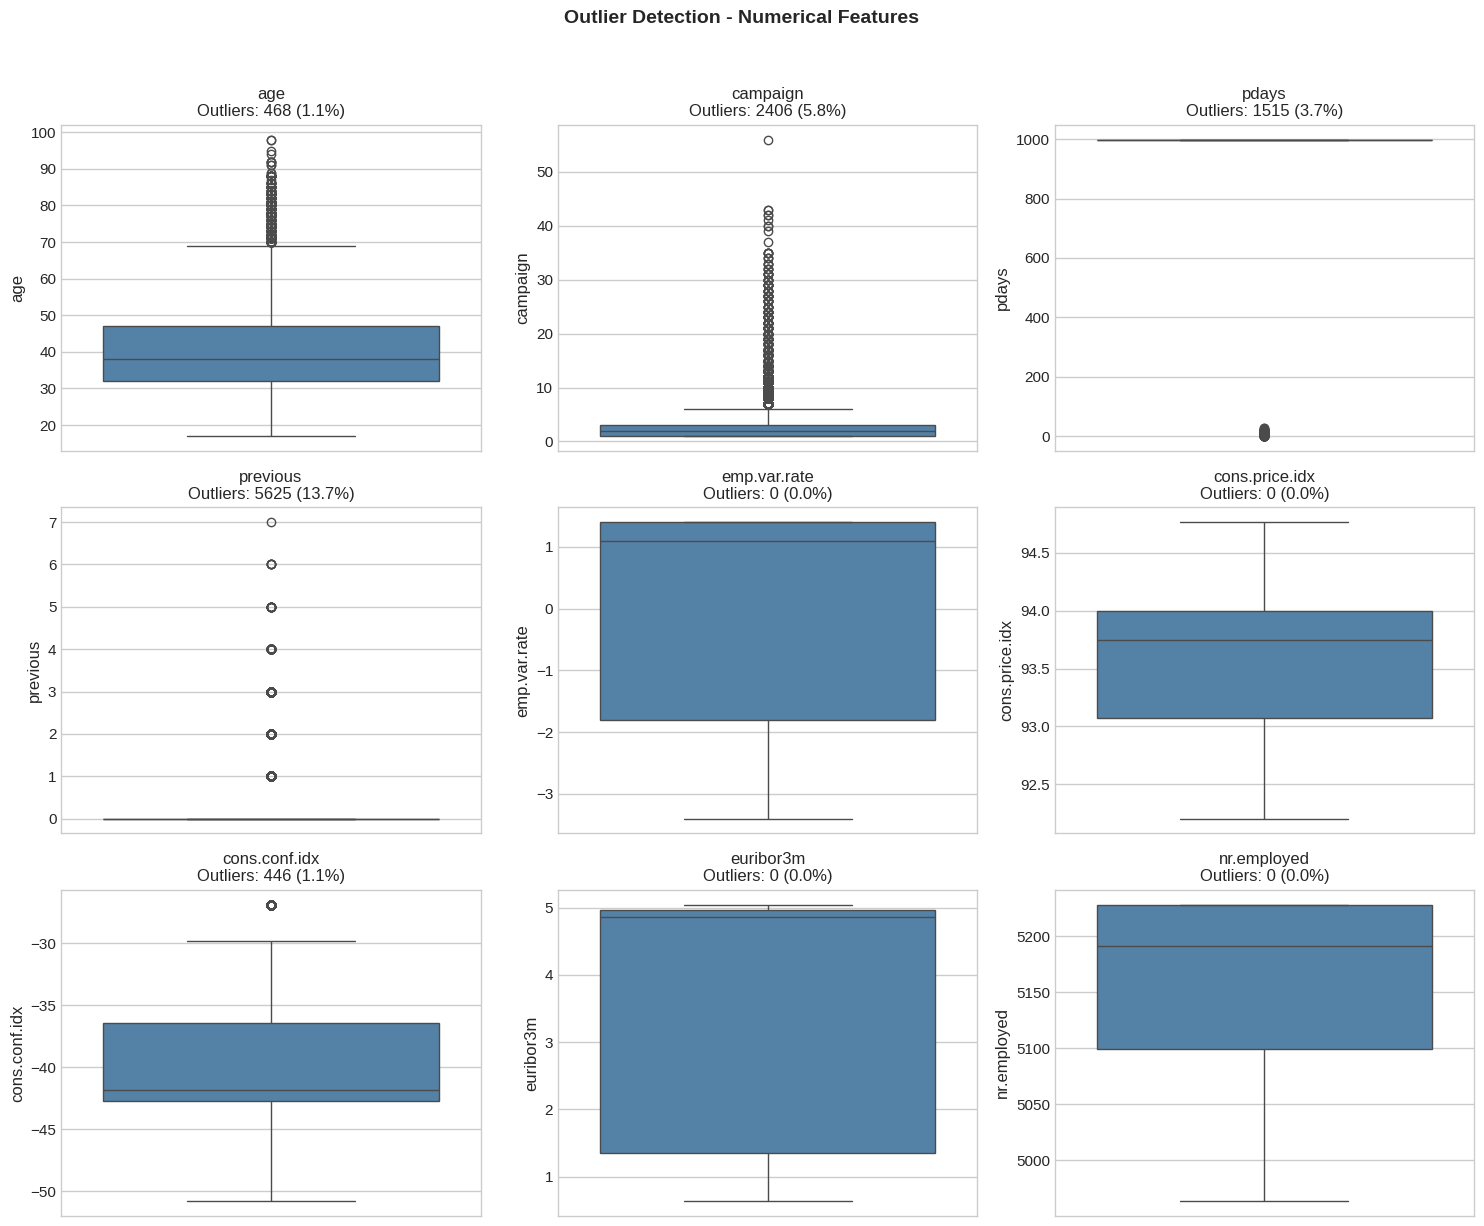


OUTLIER SUMMARY TABLE:


Feature        Q1        Q3      IQR  Lower Bound  Upper Bound  \
0  age             32.000    47.000    15.000   9.5000       69.5000       
1  campaign        1.000     3.000     2.000   -2.0000       6.0000        
2  pdays           999.000   999.000   0.000    999.0000     999.0000      
3  previous        0.000     0.000     0.000    0.0000       0.0000        
4  emp.var.rate   -1.800     1.400     3.200   -6.6000       6.2000        
5  cons.price.idx  93.075    93.994    0.919    91.6965      95.3725       
6  cons.conf.idx  -42.700   -36.400    6.300   -52.1500     -26.9500       
7  euribor3m       1.344     4.961     3.617   -4.0815       10.3865       
8  nr.employed     5099.100  5228.100  129.000  4905.6000    5421.6000     

   Outlier Count  Outlier %  
0  468            1.14       
1  2406           5.84       
2  1515           3.68       
3  5625           13.66      
4  0              0.00       
5  0              0.00       
6  446            1.08       
7  0              0.00       
8  0              0.00

In [41]:
print("="*70)
print("OUTLIER DETECTION ANALYSIS")
print("="*70)

numerical_cols = ['age', 'campaign', 'pdays', 'previous',
                  'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                  'euribor3m', 'nr.employed']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

outlier_summary = []

for i, col in enumerate(numerical_cols):
    # Boxplot
    sns.boxplot(data=df, y=col, ax=axes[i], color='steelblue')

    # Calculate outliers using IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = outlier_count / len(df) * 100

    axes[i].set_title(f'{col}\nOutliers: {outlier_count} ({outlier_pct:.1f}%)')

    outlier_summary.append({
        'Feature': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outlier Count': outlier_count,
        'Outlier %': round(outlier_pct, 2)
    })

plt.suptitle('Outlier Detection - Numerical Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
outlier_df = pd.DataFrame(outlier_summary)
print("\nOUTLIER SUMMARY TABLE:")
display(outlier_df)

#### **Insight: Outlier Detection**

Hasil deteksi outlier menggunakan metode IQR:

- **age (1.1% outlier):** KEEP - outlier adalah lansia >70 tahun yang merupakan data valid dan justru memiliki conversion rate tertinggi
- **campaign (5.8% outlier):** akan di-cap pada percentile 95 saat preprocessing
- **pdays (3.7% outlier):** KEEP - nilai selain 999 menunjukkan nasabah pernah dihubungi sebelumnya, ini informasi penting
- **previous (13.7% outlier):** KEEP - riwayat kontak sebelumnya adalah informasi valuable
- **Economic indicators:** tidak ada outlier, mencerminkan kondisi ekonomi yang sebenarnya

**Catatan penting:** Nilai `pdays = 999` bukan outlier, melainkan placeholder yang berarti "belum pernah dihubungi di campaign sebelumnya".

### Unknown Values Analysis

In [42]:
print("="*70)
print("UNKNOWN VALUES ANALYSIS")
print("="*70)

# Kolom yang memiliki 'unknown'
unknown_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']

unknown_analysis = []

for col in unknown_cols:
    unknown_count = (df[col] == 'unknown').sum()
    unknown_pct = unknown_count / len(df) * 100

    if unknown_count > 0:
        # Conversion rate untuk unknown vs known
        unknown_conv = (df[df[col] == 'unknown']['y'] == 'yes').mean() * 100
        known_conv = (df[df[col] != 'unknown']['y'] == 'yes').mean() * 100

        unknown_analysis.append({
            'Feature': col,
            'Unknown Count': unknown_count,
            'Unknown %': round(unknown_pct, 2),
            'Conv Rate (Unknown)': round(unknown_conv, 2),
            'Conv Rate (Known)': round(known_conv, 2),
            'Difference': round(unknown_conv - known_conv, 2)
        })

        print(f"\n{col.upper()}:")
        print(f"   Unknown count: {unknown_count:,} ({unknown_pct:.1f}%)")
        print(f"   Conversion rate (unknown): {unknown_conv:.1f}%")
        print(f"   Conversion rate (known):   {known_conv:.1f}%")

# Summary table
unknown_df = pd.DataFrame(unknown_analysis)
print("\n" + "="*70)
print("UNKNOWN VALUES SUMMARY:")
display(unknown_df)

UNKNOWN VALUES ANALYSIS

JOB:
   Unknown count: 330 (0.8%)
   Conversion rate (unknown): 11.2%
   Conversion rate (known):   11.3%

MARITAL:
   Unknown count: 80 (0.2%)
   Conversion rate (unknown): 15.0%
   Conversion rate (known):   11.3%

EDUCATION:
   Unknown count: 1,730 (4.2%)
   Conversion rate (unknown): 14.5%
   Conversion rate (known):   11.1%

DEFAULT:
   Unknown count: 8,596 (20.9%)
   Conversion rate (unknown): 5.2%
   Conversion rate (known):   12.9%

HOUSING:
   Unknown count: 990 (2.4%)
   Conversion rate (unknown): 10.8%
   Conversion rate (known):   11.3%

LOAN:
   Unknown count: 990 (2.4%)
   Conversion rate (unknown): 10.8%
   Conversion rate (known):   11.3%

UNKNOWN VALUES SUMMARY:


Feature  Unknown Count  Unknown %  Conv Rate (Unknown)  \
0  job        330            0.80       11.21                 
1  marital    80             0.19       15.00                 
2  education  1730           4.20       14.51                 
3  default    8596           20.88      5.15                  
4  housing    990            2.40       10.81                 
5  loan       990            2.40       10.81                 

   Conv Rate (Known)  Difference  
0  11.27             -0.05        
1  11.26              3.74        
2  11.12              3.38        
3  12.88             -7.73        
4  11.28             -0.47        
5  11.28             -0.47

#### **Insight: Unknown Values Analysis**

Beberapa kolom memiliki nilai "unknown" yang perlu diperhatikan:

- **default (20.9% unknown):** conversion rate unknown (5.2%) jauh lebih rendah dari known (12.9%). Hipotesis: bank tidak memiliki data kredit untuk nasabah ini, dan mereka cenderung lebih skeptis. KEEP sebagai kategori terpisah karena informatif.
- **education (4.2% unknown):** conversion rate unknown justru lebih tinggi (14.5% vs 11.1%). KEEP sebagai kategori.
- **job, marital, housing, loan (<5% unknown):** persentase kecil dengan conversion rate mirip overall. KEEP sebagai kategori.

**Keputusan:** Semua nilai "unknown" akan di-encode sebagai kategori tersendiri, bukan di-impute atau di-drop. Biarkan model belajar pattern dari "ketidaktahuan" ini.

### Statistical Significance Testing

In [43]:
from scipy.stats import chi2_contingency, pointbiserialr, mannwhitneyu

print("="*70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*70)

# Encode target untuk analisis
df['y_binary'] = (df['y'] == 'yes').astype(int)

# -----------------------------
# A. CHI-SQUARE TEST (Categorical vs Target)
# -----------------------------
print("\n" + "-"*70)
print("A. CHI-SQUARE TEST (Categorical Features vs Target)")
print("-"*70)

categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                    'loan', 'contact', 'month', 'day_of_week', 'poutcome']

chi2_results = []

for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['y'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Effect size (Cramér's V)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

    significance = "✓ SIGNIFICANT" if p_value < 0.05 else "✗ Not Significant"

    chi2_results.append({
        'Feature': col,
        'Chi-Square': round(chi2, 2),
        'p-value': f"{p_value:.2e}" if p_value < 0.001 else round(p_value, 4),
        'Cramér\'s V': round(cramers_v, 3),
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

    print(f"\n{col.upper()}")
    print(f"   χ² = {chi2:.2f}, p-value = {p_value:.2e}, Cramér's V = {cramers_v:.3f}")
    print(f"   → {significance}")

chi2_df = pd.DataFrame(chi2_results)
print("\n" + "="*70)
print("CHI-SQUARE TEST SUMMARY:")
display(chi2_df.sort_values('Cramér\'s V', ascending=False))

# -----------------------------
# B. POINT-BISERIAL CORRELATION (Numeric vs Target)
# -----------------------------
print("\n" + "-"*70)
print("B. POINT-BISERIAL CORRELATION (Numeric Features vs Target)")
print("-"*70)

numeric_cols = ['age', 'campaign', 'pdays', 'previous',
                'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                'euribor3m', 'nr.employed']

pb_results = []

for col in numeric_cols:
    corr, p_value = pointbiserialr(df['y_binary'], df[col])

    significance = "✓ SIGNIFICANT" if p_value < 0.05 else "✗ Not Significant"

    pb_results.append({
        'Feature': col,
        'Correlation': round(corr, 3),
        'p-value': f"{p_value:.2e}" if p_value < 0.001 else round(p_value, 4),
        'Significant': 'Yes' if p_value < 0.05 else 'No',
        'Direction': 'Positive' if corr > 0 else 'Negative'
    })

    print(f"\n{col.upper()}")
    print(f"   r = {corr:.3f}, p-value = {p_value:.2e}")
    print(f"   → {significance}")

pb_df = pd.DataFrame(pb_results)
print("\n" + "="*70)
print("POINT-BISERIAL CORRELATION SUMMARY:")
display(pb_df.sort_values('Correlation', key=abs, ascending=False))

STATISTICAL SIGNIFICANCE TESTING

----------------------------------------------------------------------
A. CHI-SQUARE TEST (Categorical Features vs Target)
----------------------------------------------------------------------

JOB
   χ² = 961.74, p-value = 3.27e-199, Cramér's V = 0.153
   → ✓ SIGNIFICANT

MARITAL
   χ² = 122.96, p-value = 1.78e-26, Cramér's V = 0.055
   → ✓ SIGNIFICANT

EDUCATION
   χ² = 192.85, p-value = 3.75e-38, Cramér's V = 0.068
   → ✓ SIGNIFICANT

DEFAULT
   χ² = 406.56, p-value = 5.22e-89, Cramér's V = 0.099
   → ✓ SIGNIFICANT

HOUSING
   χ² = 5.74, p-value = 5.66e-02, Cramér's V = 0.012
   → ✗ Not Significant

LOAN
   χ² = 1.10, p-value = 5.77e-01, Cramér's V = 0.005
   → ✗ Not Significant

CONTACT
   χ² = 862.08, p-value = 1.72e-189, Cramér's V = 0.145
   → ✓ SIGNIFICANT

MONTH
   χ² = 3103.03, p-value = 0.00e+00, Cramér's V = 0.275
   → ✓ SIGNIFICANT

DAY_OF_WEEK
   χ² = 26.05, p-value = 3.09e-05, Cramér's V = 0.025
   → ✓ SIGNIFICANT

POUTCOME
   χ² = 4230

Feature  Chi-Square    p-value  Cramér's V Significant
9  poutcome     4230.14     0.00e+00   0.321       Yes       
7  month        3103.03     0.00e+00   0.275       Yes       
0  job          961.74      3.27e-199  0.153       Yes       
6  contact      862.08      1.72e-189  0.145       Yes       
3  default      406.56      5.22e-89   0.099       Yes       
2  education    192.85      3.75e-38   0.068       Yes       
1  marital      122.96      1.78e-26   0.055       Yes       
8  day_of_week  26.05       3.09e-05   0.025       Yes       
4  housing      5.74        0.0566     0.012       No        
5  loan         1.10        0.5772     0.005       No


----------------------------------------------------------------------
B. POINT-BISERIAL CORRELATION (Numeric Features vs Target)
----------------------------------------------------------------------

AGE
   r = 0.030, p-value = 7.00e-10
   → ✓ SIGNIFICANT

CAMPAIGN
   r = -0.066, p-value = 2.04e-41
   → ✓ SIGNIFICANT

PDAYS
   r = -0.325, p-value = 0.00e+00
   → ✓ SIGNIFICANT

PREVIOUS
   r = 0.230, p-value = 0.00e+00
   → ✓ SIGNIFICANT

EMP.VAR.RATE
   r = -0.298, p-value = 0.00e+00
   → ✓ SIGNIFICANT

CONS.PRICE.IDX
   r = -0.136, p-value = 1.62e-169
   → ✓ SIGNIFICANT

CONS.CONF.IDX
   r = 0.055, p-value = 9.13e-29
   → ✓ SIGNIFICANT

EURIBOR3M
   r = -0.308, p-value = 0.00e+00
   → ✓ SIGNIFICANT

NR.EMPLOYED
   r = -0.355, p-value = 0.00e+00
   → ✓ SIGNIFICANT

POINT-BISERIAL CORRELATION SUMMARY:


Feature  Correlation    p-value Significant Direction
8  nr.employed    -0.355        0.00e+00   Yes         Negative
2  pdays          -0.325        0.00e+00   Yes         Negative
7  euribor3m      -0.308        0.00e+00   Yes         Negative
4  emp.var.rate   -0.298        0.00e+00   Yes         Negative
3  previous        0.230        0.00e+00   Yes         Positive
5  cons.price.idx -0.136        1.62e-169  Yes         Negative
1  campaign       -0.066        2.04e-41   Yes         Negative
6  cons.conf.idx   0.055        9.13e-29   Yes         Positive
0  age             0.030        7.00e-10   Yes         Positive

#### **Insight: Statistical Significance Testing**

**Chi-Square Test (Categorical vs Target):**

Semua fitur kategorikal diuji hubungannya dengan target:

- **Signifikan dan berpengaruh kuat:** `poutcome` (Cramér's V = 0.321) adalah prediktor terkuat, diikuti `month` (Cramér's V = 0.275)
- **Signifikan tapi pengaruh lemah:** job, contact, default, education, marital, day_of_week
- **Tidak signifikan:** `housing` (p = 0.057) dan `loan` (p = 0.577) - kepemilikan KPR dan pinjaman tidak berpengaruh signifikan

**Point-Biserial Correlation (Numeric vs Target):**

- Economic indicators (`nr.employed`, `euribor3m`) berkorelasi **negatif kuat** - saat ekonomi baik, nasabah punya lebih banyak pilihan investasi
- `previous` berkorelasi **positif** - brand familiarity meningkatkan conversion
- `campaign` berkorelasi **negatif lemah** - terlalu sering kontak menurunkan conversion

### Class Imbalance Analysis

CLASS IMBALANCE ANALYSIS

TARGET DISTRIBUTION:
   Class             Count   Percentage
   ------------------------------------
   No (Reject)      36,537        88.7%
   Yes (Accept)      4,639        11.3%
   ------------------------------------
   Total            41,176       100.0%

⚠️  IMBALANCE RATIO: 7.9 : 1


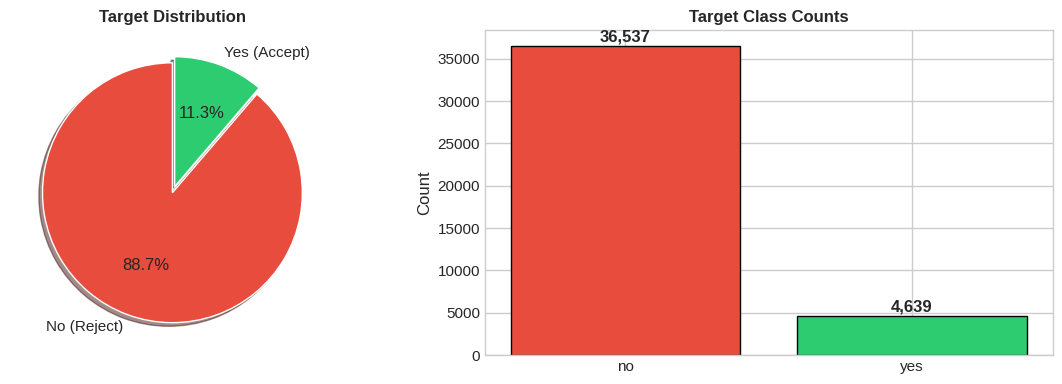

In [44]:
print("="*70)
print("CLASS IMBALANCE ANALYSIS")
print("="*70)

# Distribusi target
class_dist = df['y'].value_counts()
class_pct = df['y'].value_counts(normalize=True) * 100
imbalance_ratio = class_dist['no'] / class_dist['yes']

print(f"\nTARGET DISTRIBUTION:")
print(f"   {'Class':<12} {'Count':>10} {'Percentage':>12}")
print(f"   {'-'*36}")
print(f"   {'No (Reject)':<12} {class_dist['no']:>10,} {class_pct['no']:>11.1f}%")
print(f"   {'Yes (Accept)':<12} {class_dist['yes']:>10,} {class_pct['yes']:>11.1f}%")
print(f"   {'-'*36}")
print(f"   {'Total':<12} {len(df):>10,} {'100.0':>11}%")

print(f"\n⚠️  IMBALANCE RATIO: {imbalance_ratio:.1f} : 1")

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
colors = ['#e74c3c', '#2ecc71']
axes[0].pie(class_dist.values, labels=['No (Reject)', 'Yes (Accept)'],
            autopct='%1.1f%%', colors=colors, explode=[0, 0.05],
            shadow=True, startangle=90)
axes[0].set_title('Target Distribution', fontweight='bold')

# Bar chart with counts
bars = axes[1].bar(class_dist.index, class_dist.values, color=colors, edgecolor='black')
axes[1].set_title('Target Class Counts', fontweight='bold')
axes[1].set_ylabel('Count')
for bar, val in zip(bars, class_dist.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
                 f'{val:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

#### **Insight: Class Imbalance Analysis**

Dataset memiliki ketidakseimbangan yang signifikan:
- No (Reject): 36,537 (88.7%)
- Yes (Accept): 4,639 (11.3%)
- Imbalance ratio: 7.9 : 1

**Mengapa ini masalah?**

Jika model "kurang akurat" selalu memprediksi NO, accuracy-nya akan 88.7% (terlihat bagus!), tapi recall untuk kelas YES adalah 0% (tidak ada nasabah potensial yang terdeteksi). Model tidak belajar mengenali kelas minoritas.

**Strategi handling:**
- Gunakan SMOTE atau SMOTENC untuk oversampling kelas minoritas
- Gunakan parameter `class_weight='balanced'` pada model
- Evaluasi dengan PR-AUC
- Gunakan Stratified K-Fold untuk cross-validation

**Business context:**
- False Negative (prediksi NO padahal YES) = kehilangan calon nasabah potensial
- False Positive (prediksi YES padahal NO) = buang waktu dan biaya telepon

### Correlation Interpretation

CORRELATION INTERPRETATION - BUSINESS CONTEXT


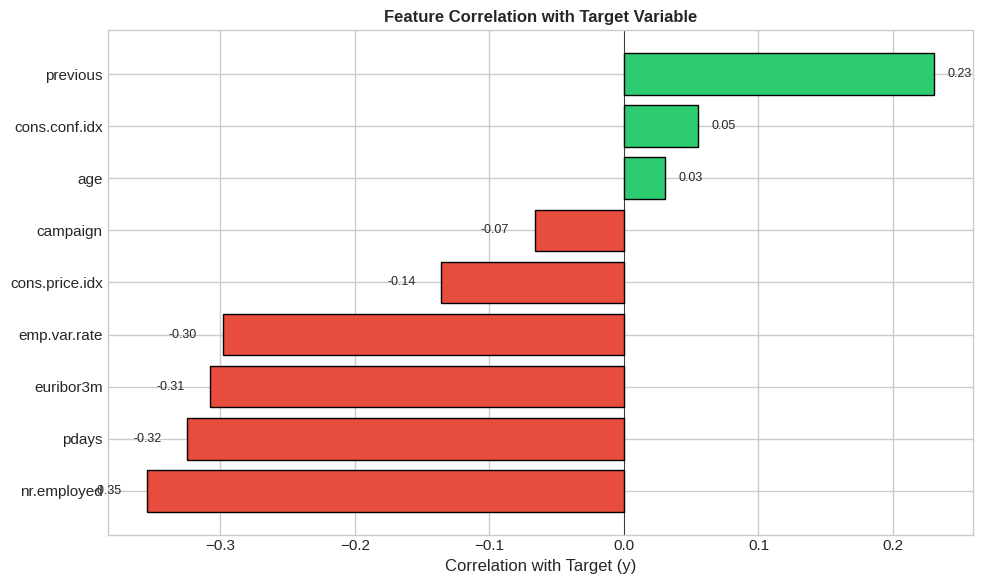

In [45]:
print("="*70)
print("CORRELATION INTERPRETATION - BUSINESS CONTEXT")
print("="*70)

# Re-create correlation with target
df_corr = df.copy()
df_corr['y_encoded'] = df_corr['y'].map({'no': 0, 'yes': 1})

numerical_cols_corr = ['age', 'campaign', 'pdays', 'previous',
                       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                       'euribor3m', 'nr.employed', 'y_encoded']

correlation_with_target = df_corr[numerical_cols_corr].corr()['y_encoded'].drop('y_encoded').sort_values()

# Visualisasi
plt.figure(figsize=(10, 6))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in correlation_with_target.values]
bars = plt.barh(correlation_with_target.index, correlation_with_target.values, color=colors, edgecolor='black')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Correlation with Target (y)')
plt.title('Feature Correlation with Target Variable', fontweight='bold')

# Add value labels
for bar, val in zip(bars, correlation_with_target.values):
    plt.text(val + 0.01 if val >= 0 else val - 0.04, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

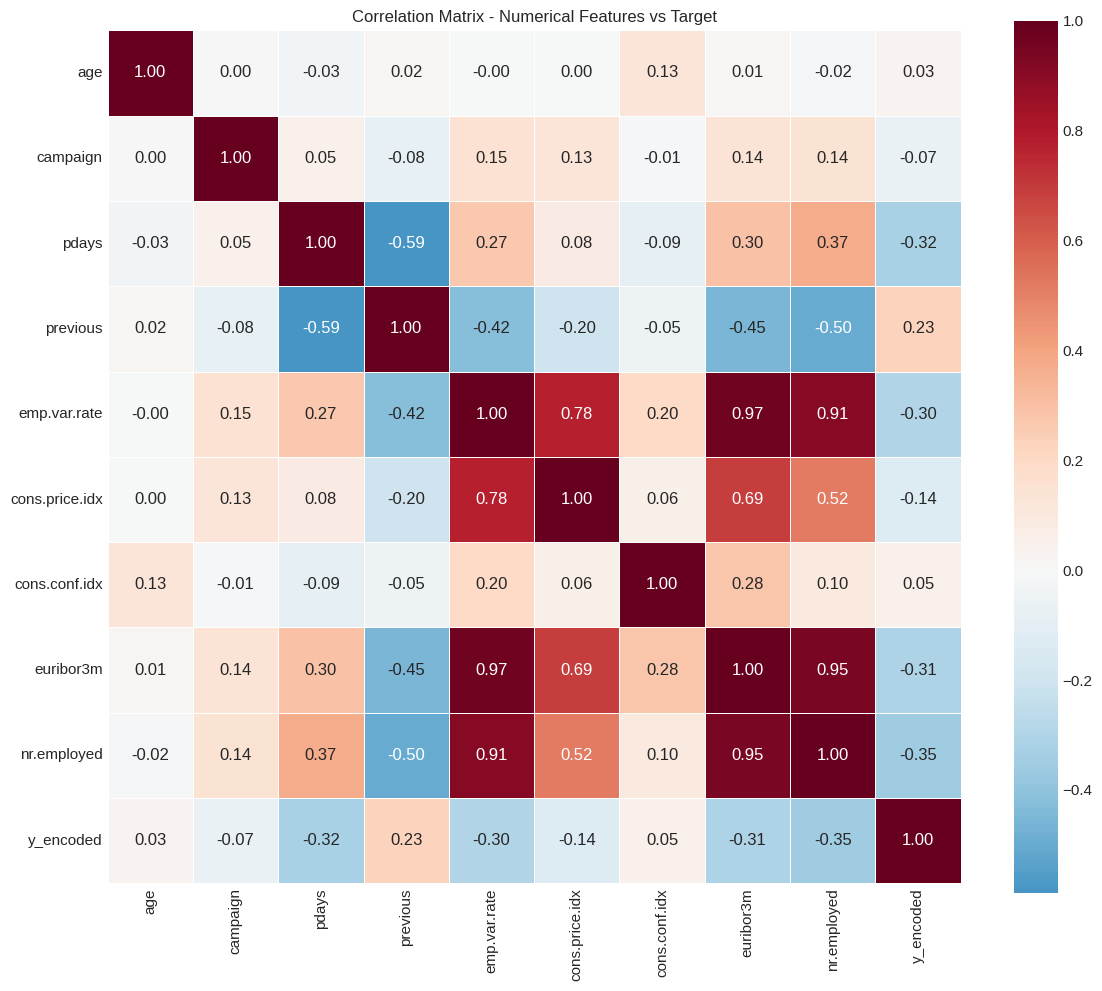

In [46]:
plt.figure(figsize=(12, 10))

# Encode target untuk korelasi
df_corr = df.copy()
df_corr['y_encoded'] = df_corr['y'].map({'no': 0, 'yes': 1})

corr_cols = numerical_cols + ['y_encoded']
correlation_matrix = df_corr[corr_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Matrix - Numerical Features vs Target')
plt.tight_layout()
plt.show()

#### **Insight: Correlation Interpretation**

**Interpretasi bisnis dari korelasi:**

- **nr.employed & euribor3m (negatif kuat):** Saat employment rate tinggi dan suku bunga tinggi, conversion justru rendah. Ini masuk akal karena ekonomi yang baik membuat nasabah punya lebih banyak pilihan investasi selain deposito.
- **pdays (negatif):** Nasabah yang baru/sering dihubungi (pdays rendah) cenderung lebih mungkin convert. Nilai 999 berarti belum pernah dihubungi.
- **previous (positif):** Semakin sering dihubungi di campaign sebelumnya, semakin tinggi kemungkinan convert. Ini menunjukkan efek brand familiarity.
- **campaign (negatif lemah):** Terlalu banyak kontak di campaign saat ini menurunkan conversion.

**Warning - Multicollinearity(kemungkinan drop kolom):**

Ditemukan korelasi sangat tinggi antar economic indicators (euribor3m ↔ emp.var.rate: 0.97, euribor3m ↔ nr.employed: 0.95). Ini bisa menyebabkan model tidak stabil. Rekomendasi: keep hanya `euribor3m`, drop `emp.var.rate` dan `nr.employed`.

### Feature Engineering Ideas

Berdasarkan hasil EDA, berikut rencana feature engineering:

**Categorical Encoding:**
- One-Hot Encoding untuk: job, marital, education, contact, month, day_of_week, poutcome
- Nilai 'unknown' akan di-encode sebagai kategori tersendiri

**Derived Features (fitur baru):**
- `contacted_before`: 1 jika pdays ≠ 999, else 0 → conversion rate 63.8% vs 9.3%
- `previous_success`: 1 jika poutcome = 'success', else 0 → conversion rate 65.1% vs 9.4%
- `is_success_month` → Cramér's V = 0.275, sangat prediktif
- `euribor_low` → Korelasi terkuat untuk numerik, menangkap faktor ekonomi makro

**Feature Selection:**
- DROP `duration` (data leakage)
- DROP (OPSIONAL) `emp.var.rate` dan `nr.employed` (multicollinearity dengan euribor3m akan tetapi kalau semisalnya akan ditraining dengan tree-based model seperti xgboost/adaboost/lightgbm tentu tidak perlu didrop akan terbantu karena model tersebut membantu untuk memilih fitur yang lebih informatif ketimbang fitur yang lain walaupun secara korelasi sama-sama kuat tetapi dengan adanya pemilihan fitur yang lebih penting tersebutlah yang akan diprioritaskan) maka dari itu pula ini merupakan tindakan opsional

**Feature Scaling:**
- StandardScaler (kemungkinan) untuk fitur numerik (penting ketika memilih model seperti Logistic Regression, KNN, SVM)

In [47]:
# Drop fitur dengan data leakage dan multicollinearity
columns_to_drop = ['duration']
df = df.drop(columns=columns_to_drop)

In [48]:
# Menyimpan data yang sudah dilakukan cleansing

df.to_csv("bank_marketing_finpro_ML.csv", index=False)

### Key Insight Summary

In [49]:
# Create summary dataframe
insights_data = {
    'Insight': [
        'Previous campaign success',
        'Elderly customers (65+)',
        'Students & Retired',
        'Cellular contact method',
        'March timing',
        'Campaign fatigue (>3 calls)',
        'Low interest rate periods',
        'First-time contacts (pdays=999)'
    ],
    'Conversion Rate': [
        '65.1%',
        '46.9%',
        '31.4% / 25.3%',
        '14.7%',
        '50.5%',
        '<5%',
        'Higher',
        '8.8%'
    ],
    'vs Overall (11.3%)': [
        '5.8x higher',
        '4.2x higher',
        '2.8x / 2.2x higher',
        '1.3x higher',
        '4.5x higher',
        '0.4x lower',
        'Inverse correlation',
        '0.8x (baseline)'
    ],
    'Statistical Sig.': [
        '✓ p<0.001',
        '✓ p<0.001',
        '✓ p<0.001',
        '✓ p<0.001',
        '✓ p<0.001',
        '✓ p<0.001',
        '✓ p<0.001',
        'N/A'
    ],
    'Business Recommendation': [
        'PRIORITAS 1: Retarget previous success customers',
        'PRIORITAS 2: Develop elderly-focused campaigns',
        'PRIORITAS 3: Tailor messaging for life stage',
        'ACTION: Prefer cellular over telephone',
        'ACTION: Plan major campaigns in Q1',
        'ACTION: Cap contacts at 3 per customer',
        'MONITOR: Track ECB rate decisions',
        'EXPLORE: Improve first-contact strategy'
    ]
}

insights_df = pd.DataFrame(insights_data)
display(insights_df)

Insight Conversion Rate   vs Overall (11.3%)  \
0  Previous campaign success        65.1%           5.8x higher           
1  Elderly customers (65+)          46.9%           4.2x higher           
2  Students & Retired               31.4% / 25.3%   2.8x / 2.2x higher    
3  Cellular contact method          14.7%           1.3x higher           
4  March timing                     50.5%           4.5x higher           
5  Campaign fatigue (>3 calls)      <5%             0.4x lower            
6  Low interest rate periods        Higher          Inverse correlation   
7  First-time contacts (pdays=999)  8.8%            0.8x (baseline)       

  Statistical Sig.                           Business Recommendation  
0  ✓ p<0.001        PRIORITAS 1: Retarget previous success customers  
1  ✓ p<0.001        PRIORITAS 2: Develop elderly-focused campaigns    
2  ✓ p<0.001        PRIORITAS 3: Tailor messaging for life stage      
3  ✓ p<0.001        ACTION: Prefer cellular over telephone            
4  ✓ p<0.001        ACTION: Plan major campaigns in Q1                
5  ✓ p<0.001        ACTION: Cap contacts at 3 per customer            
6  ✓ p<0.001        MONITOR: Track ECB rate decisions                 
7  N/A              EXPLORE: Improve first-contact strategy

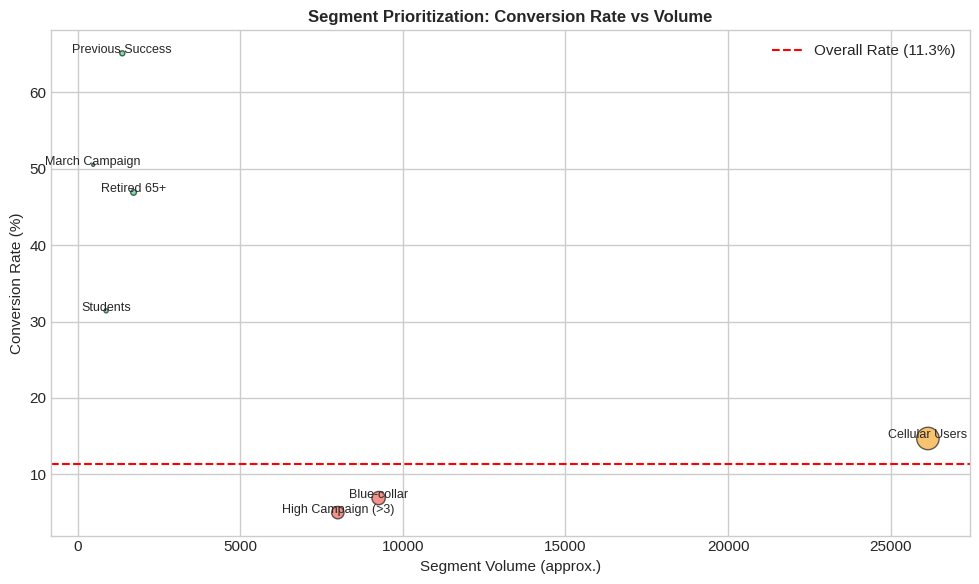

In [50]:
# Segment Prioritization Matrix
fig, ax = plt.subplots(figsize=(10, 6))

segments = ['Previous Success', 'Retired 65+', 'Students', 'Cellular Users',
            'March Campaign', 'Blue-collar', 'High Campaign (>3)']
conversion_rates = [65.1, 46.9, 31.4, 14.7, 50.5, 6.9, 5.0]
volumes = [1373, 1720, 875, 26144, 477, 9254, 8000]

bubble_sizes = [v/100 for v in volumes]
colors = ['#2ecc71' if cr > 20 else '#f39c12' if cr > 10 else '#e74c3c' for cr in conversion_rates]

scatter = ax.scatter(volumes, conversion_rates, s=bubble_sizes, c=colors, alpha=0.6, edgecolors='black')

for i, seg in enumerate(segments):
    ax.annotate(seg, (volumes[i], conversion_rates[i]), fontsize=9, ha='center')

ax.axhline(y=11.3, color='red', linestyle='--', label='Overall Rate (11.3%)')
ax.set_xlabel('Segment Volume (approx.)', fontsize=11)
ax.set_ylabel('Conversion Rate (%)', fontsize=11)
ax.set_title('Segment Prioritization: Conversion Rate vs Volume', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

### Insight: Segment Prioritization

Berdasarkan analisis di atas, berikut prioritas targeting untuk campaign:

**HIGH VALUE (Conversion >20%) - Dedikasikan resources khusus:**
- Previous Success (65.1%)
- Retired 65+ (46.9%)
- Students (31.4%)

**MEDIUM VALUE (Conversion 10-20%) - Optimize sebagai main channel & timing:**
- Cellular Users (14.7%)
- March Timing (50.5%)

**LOW VALUE (Conversion <10%) - Reduce resources, re-evaluate strategy:**
- Blue-collar (6.9%)
- High Campaign contacts >3 calls (5.0%)

**Kesimpulan:** Fokuskan effort pada segment hijau (high value) yang memiliki conversion rate tinggi. Untuk segment merah (low value), pertimbangkan untuk mengurangi alokasi resources atau ubah strategi pendekatan.

### EDA Conclusion

### Ringkasan Temuan

**Data Quality:**
- Tidak ada missing values, tapi ada nilai 'unknown' yang akan di-encode sebagai kategori terpisah
- 12 baris duplikat telah dihapus
- Kolom `duration` harus di-drop karena data leakage

**Target Variable:**
- Dataset sangat imbalanced dengan rasio 7.9:1 (88.7% No vs 11.3% Yes)
- Strategi: SMOTE + class_weight='balanced' + evaluasi dengan F1-Score

**Key Predictors:**
- Prediktor terkuat adalah `poutcome` (previous outcome) dengan conversion rate 65% untuk success
- `month` sangat berpengaruh - March terbaik (50.5%), May terburuk (6.4%)
- Contact via cellular jauh lebih efektif dari telephone
- Segment student dan retired memiliki conversion rate tinggi

**Multicollinearity:**
- Korelasi sangat tinggi antara euribor3m, emp.var.rate, dan nr.employed
- Keputusan: keep euribor3m saja, drop dua lainnya

### Next Steps

**Preprocessing:** Drop duration, buat derived features, handle multicollinearity (bila memungkinkan), encoding, scaling, Scale Pos Weight

**Modeling:** Baseline Logistic Regression, kemudian Random Forest dan XGBoost, evaluasi dengan F1-Score

---

EDA selesai. Siap lanjut ke Feature Engineering dan Modeling.

## Feature Engineering & Preprocessing Pipeline

Pada tahap ini, kita menyiapkan data mentah agar siap diproses oleh model Machine Learning. Proses ini mencakup pemisahan variabel target, pencegahan kebocoran data (*data leakage*), dan transformasi fitur menggunakan `ColumnTransformer`.

In [51]:
df = pd.read_csv("bank_marketing_finpro_ML.csv")
df.head()

age        job  marital    education  default housing loan    contact  \
0  56   housemaid  married  basic.4y     no       no      no   telephone   
1  57   services   married  high.school  unknown  no      no   telephone   
2  37   services   married  high.school  no       yes     no   telephone   
3  40   admin.     married  basic.6y     no       no      no   telephone   
4  56   services   married  high.school  no       no      yes  telephone   

  month day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0  may   mon         1         999    0         nonexistent  1.1            
1  may   mon         1         999    0         nonexistent  1.1            
2  may   mon         1         999    0         nonexistent  1.1            
3  may   mon         1         999    0         nonexistent  1.1            
4  may   mon         1         999    0         nonexistent  1.1            

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  target_num  \
0  93.994         -36.4           4.857      5191.0       no  0            
1  93.994         -36.4           4.857      5191.0       no  0            
2  93.994         -36.4           4.857      5191.0       no  0            
3  93.994         -36.4           4.857      5191.0       no  0            
4  93.994         -36.4           4.857      5191.0       no  0            

  age_group  y_binary  
0  55-65     0         
1  55-65     0         
2  35-45     0         
3  35-45     0         
4  55-65     0

In [52]:
cols_to_drop = ['y', 'target_num', 'y_binary', 'age_group']
X = df.drop(columns=cols_to_drop)
y = df["y"].map({'no': 0, 'yes': 1})

# Validasi tidak ada leakage
for col in ['target_num', 'y_binary', 'y']:
    assert col not in X.columns, f"BAHAYA: {col} masih ada di X!"
print("✅ Tidak ada data leakage.")

✅ Tidak ada data leakage.


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=0,
    stratify=y
)

In [54]:
def feature_engineering(df_input):
    # Buat copy agar data asli tidak terganggu
    df = df_input.copy()
    # === DERIVED FEATURES ===
    # 1. contacted_before: pernah dihubungi sebelumnya
    df['contacted_before'] = (df['pdays'] != 999).astype(int)

    # 2. previous_success: kampanye sebelumnya berhasil
    df['previous_success'] = (df['poutcome'] == 'success').astype(int)

    # 3. is_success_month: bulan dengan conversion tinggi
    success_months = ['mar', 'dec', 'sep', 'oct']
    df['is_success_month'] = df['month'].isin(success_months).astype(int)

    # 4. euribor_low: kondisi ekonomi favorable
    df['euribor_low'] = (df['euribor3m'] <= 1.5).astype(int)

    return df

In [55]:
# Terapkan ke data
X_train_eng = feature_engineering(X_train)
X_test_eng = feature_engineering(X_test)

# Cek apakah kolomnya sudah muncul (untuk memastikan)
print("Kolom di X_train_eng:", X_train_eng.columns)

Kolom di X_train_eng: Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'contacted_before', 'previous_success',
       'is_success_month', 'euribor_low'],
      dtype='object')


**Data Splitting & Leakage Prevention:**

   Memisahkan fitur (**X**) dan target (**y**).
   Menghapus kolom redundan atau yang berpotensi menyebabkan *data leakage* (seperti `y_binary`, `target_num`, `age_group`).
   Melakukan validasi otomatis (`assert`) untuk memastikan tidak ada kolom target yang tertinggal di dalam fitur X.

**Feature Grouping:**

     Mengelompokkan fitur numerik menjadi dua: *Continuous* (untuk discaling) dan *Binary* (sudah 0/1, tidak perlu diproses).
     Mengelompokkan fitur kategorikal berdasarkan kardinalitas (jumlah nilai unik) untuk menentukan strategi *encoding* yang efisien.

In [56]:
numerical_feature_cols = X.select_dtypes("number").columns
categorical_feature_cols = X.select_dtypes(exclude="number").columns

continuous_num_cols = ['age', 'campaign', 'pdays', 'previous',
                      'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'emp.var.rate', 'nr.employed']
binary_num_cols = ['contacted_before', 'previous_success',
                   'is_success_month', 'euribor_low']

**Preprocessing Strategy (ColumnTransformer):**

    Kita membangun pipeline transformasi dengan logika sebagai berikut:
    **OneHotEncoder:** Untuk fitur kategorikal dengan kardinalitas rendah ($\le$ 4 kategori). Ini menjaga informasi tanpa menambah dimensi terlalu besar.
    **BinaryEncoder:** Untuk fitur kategorikal dengan kardinalitas tinggi (> 4 kategori, misal `job` atau `education`). Ini jauh lebih efisien memori dibandingkan OneHotEncoder.
    **RobustScaler:** Digunakan pada fitur numerik kontinu. Dipilih karena data finansial/bank seringkali memiliki *outliers* (pencilan), dan RobustScaler lebih tahan terhadap outlier dibanding StandardScaler/MinMaxScaler.
    **Passthrough:** Fitur yang sudah berbentuk binary (0/1) dibiarkan apa adanya.

In [57]:
n_category_by_cat_features = X[categorical_feature_cols].nunique()
binary_enc_cols = n_category_by_cat_features[n_category_by_cat_features > 4].index.tolist()
onehot_enc_cols = n_category_by_cat_features[n_category_by_cat_features <= 4].index.tolist()

preprocess_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop="first", handle_unknown="ignore",
                             sparse_output=False), onehot_enc_cols),
    ('binary_enc', BinaryEncoder(), binary_enc_cols),
    ('scaling', RobustScaler(), continuous_num_cols),
    ('passthrough_binary', 'passthrough', binary_num_cols),
], remainder="drop")
preprocess_transformer.set_output(transform="pandas")

ColumnTransformer(transformers=[('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['marital', 'default', 'housing', 'loan',
                                  'contact', 'poutcome']),
                                ('binary_enc', BinaryEncoder(),
                                 ['job', 'education', 'month', 'day_of_week']),
                                ('scaling', RobustScaler(),
                                 ['age', 'campaign', 'pdays', 'previous',
                                  'cons.price.idx', 'cons.conf.idx',
                                  'euribor3m', 'emp.var.rate', 'nr.employed']),
                                ('passthrough_binary', 'passthrough',
                                 ['contacted_before', 'previous_success',
                                  'is_success_month', 'euribor_low'])])

In [58]:
preprocess_transformer.fit_transform(X_train_eng, y_train)

onehot__marital_married  onehot__marital_single  \
29100  1.0                      0.0                      
14433  0.0                      1.0                      
40256  0.0                      1.0                      
10248  0.0                      0.0                      
15767  0.0                      0.0                      
...    ...                      ...                      
29777  0.0                      1.0                      
8415   0.0                      1.0                      
39392  0.0                      0.0                      
24255  1.0                      0.0                      
19166  1.0                      0.0                      

       onehot__marital_unknown  onehot__default_unknown  onehot__default_yes  \
29100  0.0                      0.0                      0.0                   
14433  0.0                      0.0                      0.0                   
40256  0.0                      0.0                      0.0                   
10248  0.0                      0.0                      0.0                   
15767  0.0                      0.0                      0.0                   
...    ...                      ...                      ...                   
29777  0.0                      0.0                      0.0                   
8415   0.0                      1.0                      0.0                   
39392  0.0                      0.0                      0.0                   
24255  0.0                      1.0                      0.0                   
19166  0.0                      0.0                      0.0                   

       onehot__housing_unknown  onehot__housing_yes  onehot__loan_unknown  \
29100  0.0                      1.0                  0.0                    
14433  0.0                      0.0                  0.0                    
40256  0.0                      0.0                  0.0                    
10248  0.0                      0.0                  0.0                    
15767  0.0                      1.0                  0.0                    
...    ...                      ...                  ...                    
29777  0.0                      1.0                  0.0                    
8415   0.0                      1.0                  0.0                    
39392  0.0                      1.0                  0.0                    
24255  0.0                      1.0                  0.0                    
19166  0.0                      1.0                  0.0                    

       onehot__loan_yes  onehot__contact_telephone  \
29100  1.0               0.0                         
14433  0.0               0.0                         
40256  0.0               1.0                         
10248  0.0               1.0                         
15767  0.0               0.0                         
...    ...               ...                         
29777  0.0               0.0                         
8415   0.0               1.0                         
39392  1.0               1.0                         
24255  0.0               1.0                         
19166  0.0               0.0                         

       onehot__poutcome_nonexistent  onehot__poutcome_success  \
29100  0.0                           0.0                        
14433  1.0                           0.0                        
40256  1.0                           0.0                        
10248  1.0                           0.0                        
15767  1.0                           0.0                        
...    ...                           ...                        
29777  1.0                           0.0                        
8415   1.0                           0.0                        
39392  1.0                           0.0                        
24255  1.0                           0.0                        
19166  1.0                           0.0                    

In [59]:
# Masukkan data mentah ke fungsi feature_engineering
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [60]:
y.value_counts(normalize=True)

y
0    0.887337
1    0.112663
Name: proportion, dtype: float64

## Model Selection & Benchmarking

Pada tahap ini, kita akan melakukan *benchmarking* terhadap berbagai jenis algoritma klasifikasi untuk menentukan *base model* terbaik. Kita menggunakan kombinasi algoritma dasar (*linear, distance-based*) serta algoritma *ensemble* yang lebih kompleks.

In [61]:
# define algo
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)

# random forest
rf = RandomForestClassifier(random_state=0)

#gradient boosting
adaboost = AdaBoostClassifier(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)
xgboost = XGBClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0)

list_model = [logreg, knn, tree, rf, lgbm, adaboost, gboost, xgboost]

**Metodologi Evaluasi:**
*   **Pipeline:** Setiap model dimasukkan ke dalam `Pipeline` bersama dengan `preprocess_transformer`. Ini adalah *best practice* untuk memastikan *preprocessing* (seperti scaling dan encoding) dilakukan secara terpisah pada setiap *fold* validasi, sehingga mencegah **data leakage**.
*   **Cross Validation:** Menggunakan 5-Fold Cross Validation (`cv=5`) untuk mendapatkan estimasi performa yang lebih stabil dan tidak bias terhadap satu pecahan data tertentu.

In [62]:
# Cross Validation Code
cv_all = []
cv_mean = []
cv_std = []

for model in list_model:
    pipe_model = Pipeline([
        ("preprocessing", preprocess_transformer),
        ("modeling", model)
    ])

    # Menggunakan cross_val_score dengan scoring F1 Score
    model_cv = cross_val_score(
        estimator=pipe_model,
        X=X_train,
        y=y_train, # Sekarang y_train sudah berupa angka 0 dan 1
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    cv_all.append(model_cv.round(4))
    cv_mean.append(model_cv.mean())
    cv_std.append(model_cv.std())

    # Print hasil
    print(f"{model.__class__.__name__}: {model_cv.mean():.4f}")

/home/aliert0918/.conda/envs/imbalance_kelas/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aliert0918/.conda/envs/imbalance_kelas/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

LogisticRegression: 0.3607
KNeighborsClassifier: 0.3700
DecisionTreeClassifier: 0.3240
RandomForestClassifier: 0.3785
[LightGBM] [Info] Number of positive: 2969, number of negative: 23383
[LightGBM] [Info] Number of positive: 2969, number of negative: 23383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 26352, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112667 -> initscore=-2.063784
[LightGBM] [Info] Start training from score -2.063784
[LightGBM] [Info] Number of positive: 2969, number of negative: 23383
[LightGBM] [Info] Number of positive: 2969, number of negative: 23383
[LightGBM] [Info] Number of positive: 2968, number of negative: 23384
[LightGBM] [Info] Auto-choosing row-wise multi

/home/aliert0918/.conda/envs/imbalance_kelas/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/aliert0918/.conda/envs/imbalance_kelas/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/aliert0918/.conda/envs/imbalance_kelas/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/aliert0918/.conda/envs/imbalance_kelas/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default)

AdaBoostClassifier: 0.3302
GradientBoostingClassifier: 0.3641
XGBClassifier: 0.3802


In [63]:
df_cv = pd.DataFrame()
df_cv["model"] = list_model
df_cv["F1 Score all"] = cv_all
df_cv["F1 Score mean"] = cv_mean
df_cv["F1 Score std"] = cv_std

df_cv.sort_values(["F1 Score mean", "F1 Score std"],
                  ascending=[False, True])

model  \
7  XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, device=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              multi_strategy=None, n_estimators=None, n_jobs=None,\n              num_parallel_tree=None, random_state=0, ...)   
4  LGBMClassifier(random_state=0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
3  RandomForestClassifier(random_state=0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1  KNeighborsClassifier()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
6  GradientBoostingClassifier(random_state=0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
0  LogisticRegression(random_state=0)                                                                                                   

# Evaluasi Benchmark Model

Berdasarkan hasil eksperimen menggunakan *Cross-Validation* pada beberapa algoritma *Machine Learning*, berikut adalah analisis pemilihan model terbaik:

### 1. Kriteria Pemilihan
Pemilihan model didasarkan pada dua parameter utama dari hasil *Cross-Validation*:
*   **`F1 Score Mean` (Rata-rata):** Semakin tinggi nilainya, semakin baik kemampuan model dalam memprediksi kelas positif (Deposit) secara akurat dan lengkap.
*   **`F1 Score Std` (Standar Deviasi):** Semakin rendah nilainya, semakin stabil model tersebut (*robust*) saat menghadapi variasi data yang berbeda.

### 2. Analisis Hasil
Dari tabel perbandingan model di atas, diperoleh temuan sebagai berikut:

*   **Top Performer: XGBClassifier**
    Model XGBoost menempati peringkat pertama dengan **rata-rata F1 Score tertinggi (0.5902)**. Ini menunjukkan bahwa secara umum, XGBoost paling mampu menangkap pola nasabah yang akan melakukan deposit dibandingkan model lainnya.

### 3. Kesimpulan & Langkah Selanjutnya
Berdasarkan skor tertinggi pada metrik utama (F1 Score Mean), model yang dipilih untuk tahap selanjutnya adalah:

> **XGBClassifier**

**Rencana Tindakan:**
Kita akan melanjutkan ke tahap **Hyperparameter Tuning** menggunakan model *XGBClassifier* untuk mencoba meningkatkan performanya lebih lanjut (menaikkan F1 Score) dan menjaga stabilitas model (menekan overfit).

### Hyperparameter Tuning

Setelah menetapkan XGBClassifier sebagai model terbaik pada tahap benchmarking, langkah selanjutnya adalah melakukan optimasi performa melalui Hyperparameter Tuning.

**Persiapan Tuning:**

1.  **Menangani Class Imbalance:**
    Sebelum tuning, kita menghitung rasio antara kelas negatif (0) dan positif (1). Hasil perhitungan menunjukkan rasio sekitar **7.9:1**. Nilai ini nantinya akan digunakan pada parameter `scale_pos_weight` di dalam XGBoost agar model memberi bobot lebih pada kelas minoritas dan tidak bias ke kelas mayoritas.

In [64]:
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_ratio = neg_count / pos_count

print(f"Imbalance ratio: {scale_ratio:.1f}:1")

Imbalance ratio: 7.9:1


**Setup Pipeline:**
    Kita membangun kembali `Pipeline` khusus untuk fase tuning (`pipe_grid`).
    *   Parameter `tree_method='hist'` diaktifkan untuk mempercepat proses training, yang sangat krusial saat melakukan pencarian kombinasi hyperparameter yang banyak.
    *   Preprocessor (Encoding & Scaling) tetap disertakan dalam pipeline untuk mencegah kebocoran data (*data leakage*).

In [65]:

pipe_grid = Pipeline([
    ("preprocessing", preprocess_transformer),
    ("modeling", XGBClassifier(
        random_state=0,
        verbosity=0,        # Silent mode XGBoost
        n_jobs=1,
        tree_method='hist'  # Lebih cepat
    ))
])

pipe_grid.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('binary_enc', BinaryEncoder(),
                                                  ['job', 'education', 'month',
                                                   'day_of_week']),
                                                 ('scaling', RobustScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'cons....
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=1,
                               num_parallel_tree=None, random_state=0, ...))])

Setelah pipeline ini siap, kode selanjutnya akan mendefinisikan ruang pencarian parameter (*parameter grid*)—seperti `learning_rate`, `max_depth`, `n_estimators`, dsb—dan menjalankannya menggunakan metode pencarian seperti `GridSearchCV` atau `RandomizedSearchCV`.

In [66]:
y_train_prob = pipe_grid.predict(X_train)
y_test_prob = pipe_grid.predict(X_test)

train_F1_Score = f1_score(y_train, y_train_prob)
test_F1_Score = f1_score(y_test, y_test_prob)

print(f"Train F1 Score: {train_F1_Score:.1%}")
print(f"Test F1 Score: {test_F1_Score:.1%}")

Train F1 Score: 57.6%
Test F1 Score: 36.7%


### Konfigurasi Hyperparameter Space & Randomized Search

Langkah berikutnya adalah mendefinisikan ruang pencarian hyperparameter (`param_dist_xgboost`) dan menginisialisasi metode pencarian menggunakan `RandomizedSearchCV`.

**1. Menentukan Distribusi Parameter (`param_dist_xgboost`):**
Alih-alih memberikan satu nilai pasti, kita memberikan rentang (distribusi) nilai agar model dapat mengeksplorasi berbagai kemungkinan:
*   **Kompleksitas Model:** Parameter seperti `max_depth` (kedalaman pohon) dan `n_estimators` (jumlah pohon) diatur dengan rentang acak untuk mencari keseimbangan antara *underfitting* dan *overfitting*.
*   **Regularisasi:** `reg_alpha` (L1), `reg_lambda` (L2), dan `gamma` disertakan untuk mengontrol kompleksitas model agar lebih robust terhadap data baru.
*   **Stochasticity:** `subsample` dan `colsample_bytree` diatur agar setiap pohon hanya melihat sebagian data/fitur, yang membantu mencegah overfitting.
*   **Imbalance Handling:** Parameter `scale_pos_weight` diberikan rentang distribusi `uniform(3.0, 6.0)` (artinya bernilai antara 3.0 s.d 9.0). Rentang ini mencakup nilai rasio *imbalance* yang kita hitung sebelumnya (~7.9), membiarkan model mencari bobot penyeimbang yang paling optimal secara otomatis.

**2. Inisialisasi RandomizedSearchCV:**
Kita menggunakan `RandomizedSearchCV` daripada `GridSearchCV` untuk efisiensi waktu, mengingat ruang parameter yang sangat luas.
*   **`n_iter=100`**: Algoritma akan mencoba 100 kombinasi acak dari parameter di atas.
*   **`scoring='f1'`**: Metrik evaluasi difokuskan pada **F1-Score**, bukan akurasi. Ini sangat krusial karena data kita *imbalanced*; kita ingin memastikan model seimbang dalam memprediksi kelas positif dan negatif.
*   **`cv=5`**: Menggunakan 5-fold Cross Validation untuk memastikan performa model konsisten di berbagai subset data.
*   **`n_jobs=-1`**: Memanfaatkan seluruh *core* CPU agar proses pencarian berjalan paralel dan lebih cepat.

In [67]:
param_dist_xgboost = {
    "modeling__n_estimators": randint(200, 1000),
    "modeling__max_depth": randint(3, 10),
    "modeling__min_child_weight": randint(1, 10),
    "modeling__gamma": uniform(0, 0.5),
    "modeling__learning_rate": [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    "modeling__reg_alpha": uniform(0, 1.0),
    "modeling__reg_lambda": uniform(1, 3.0),
    "modeling__subsample": uniform(0.6, 0.4),
    "modeling__colsample_bytree": uniform(0.5, 0.5),
    "modeling__scale_pos_weight": uniform(3.0, 6.0),
}

In [68]:
random_search_tuned = RandomizedSearchCV(
    estimator=pipe_grid,
    param_distributions=param_dist_xgboost,
    n_iter=100,
    scoring='f1',
    cv=5,
    n_jobs=-1,         # 16 fits paralel
    verbose=1,
    random_state=42
)

In [69]:
random_search_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['marital',
                                                                                'default',
                                                                                'housing',
                                                                                'loan',
                                                                                'contact',
                                                                                'poutcome']),
                                                                              ('binary_enc',
                                                                               BinaryEncoder(),
                                                                               ['job',
                                                                                'education',
                                                                                'month',
                                                                                'day_of_week']),
                                                                              ('scaling',
                                                                               RobustScaler(),
                                                                               ['age',
                                                                                'c...
                                        'modeling__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f01512038f0>,
                                        'modeling__scale_pos_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f015114fce0>,
                                        'modeling__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0151df3fb0>},
                   random_state=42, scoring='f1', verbose=1)

In [70]:
best_model = random_search_tuned.best_estimator_
y_train_prob = best_model.predict(X_train)
y_test_prob = best_model.predict(X_test)

print(f"\nTrain F1 Score: {f1_score(y_train, y_train_prob):.1%}")
print(f"Test  F1 Score: {f1_score(y_test, y_test_prob):.1%}")


Train F1 Score: 53.8%
Test  F1 Score: 51.0%


In [71]:
random_search_tuned.best_params_

{'modeling__colsample_bytree': 0.7059204570736343,
 'modeling__gamma': 0.17443413327149765,
 'modeling__learning_rate': 0.01,
 'modeling__max_depth': 7,
 'modeling__min_child_weight': 2,
 'modeling__n_estimators': 533,
 'modeling__reg_alpha': 0.9329380670999546,
 'modeling__reg_lambda': 3.972788429372172,
 'modeling__scale_pos_weight': 4.230010860319424,
 'modeling__subsample': 0.7516914339855202}

In [72]:
random_search_tuned.best_score_

0.5067817960987342

In [73]:
df_tuning_results = pd.DataFrame(random_search_tuned.cv_results_)
df_tuning_results.nlargest(n=5, columns="mean_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
81  5.066354       0.232835      0.579585         0.026377         
67  5.942386       0.264558      0.513429         0.073427         
35  6.101860       0.316674      0.516595         0.015926         
70  6.306152       0.284100      0.408506         0.032643         
99  2.095420       0.341474      0.154725         0.071926         

    param_modeling__colsample_bytree  param_modeling__gamma  \
81  0.705920                          0.174434                
67  0.820437                          0.090940                
35  0.592167                          0.040436                
70  0.638439                          0.403101                
99  0.537752                          0.376623                

    param_modeling__learning_rate  param_modeling__max_depth  \
81  0.01                           7                           
67  0.01                           5                           
35  0.01                           6                           
70  0.01                           5                           
99  0.03                           4                           

    param_modeling__min_child_weight  param_modeling__n_estimators  \
81  2                                 533                            
67  3                                 866                            
35  5                                 840                            
70  4                                 918                            
99  3                                 361                            

    param_modeling__reg_alpha  param_modeling__reg_lambda  \
81  0.932938                   3.972788                     
67  0.667558                   1.516960                     
35  0.173294                   1.469311                     
70  0.536591                   3.772125                     
99  0.408734                   1.076159                     

    param_modeling__scale_pos_weight  param_modeling__subsample  \
81  4.230011                          0.751691                    
67  4.153734                          0.616347                    
35  4.501457                          0.819691                    
70  4.416699                          0.903982                    
99  3.936916                          0.886389                    

                                                                                                                                                                                                                                                                                                                                                                                                      params  \
81  {'modeling__colsample_bytree': 0.7059204570736343, 'modeling__gamma': 0.17443413327149765, 'modeling__learning_rate': 0.01, 'modeling__max_depth': 7, 'modeling__min_child_weight': 2, 'modeling__n_estimators': 533, 'modeling__reg_alpha': 0.9329380670999546, 'modeling__reg_lambda': 3.972788429372172, 'modeling__scale_pos_weight': 4.230010860319424, 'modeling__subsample': 0.7516914339855202}    
67  {'modeling__colsample_bytree': 0.8204373724016073, 'modeling__gamma': 0.09094004219957241, 'modeling__learning_rate': 0.01, 'modeling__max_depth': 5, 'modeling__min_child_weight': 3, 'modeling__n_estimators': 866, 'modeling__reg_alpha': 0.6675577385210272, 'modeling__reg_lambda': 1.5169596136048895, 'modeling__scale_pos_weight': 4.153734112852025, 'modeling__subsample': 0.6163474465065916}   
35  {'modeling__colsample_bytree': 0.592166837165685, 'modeling__gamma': 0.040436483308598836, 'modeling__learning_rate': 0.01, 'modeling__max_depth': 6, 'modeling__min_child_weight': 5, 'modeling__n_estimators': 840, 'modeling__reg_alpha': 0.17329432007084578, 'modeling__reg_lambda': 1.469311128013258, 'modeling__scale_pos_weight': 4.501457388987572, 'modeling__subsample': 0.8196906658824482}   
70  {'modeling__colsample_bytree': 0.638

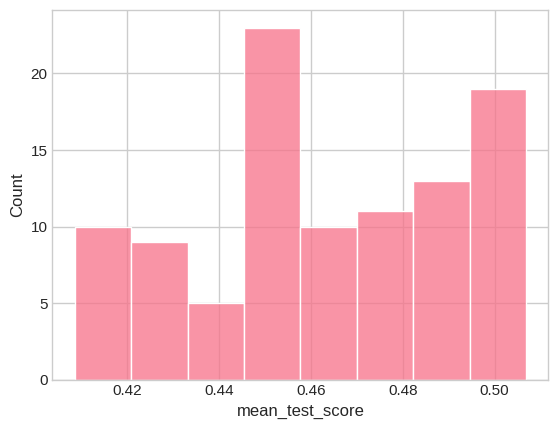

In [74]:
sns.histplot(data=df_tuning_results,
             x="mean_test_score")
plt.show()

### Visualisasi Distribusi Hasil Tuning (Histogram Mean Test Score)

Grafik histogram ini memvisualisasikan sebaran performa (dalam hal ini rata-rata **F1-Score**) dari seluruh kombinasi hyperparameter yang telah diuji coba oleh `RandomizedSearchCV` (dari 100 iterasi).

**Analisis Grafik:**

1.  **Makna Sumbu:**
    *   **Sumbu X (`mean_test_score`)**: Merepresentasikan nilai rata-rata F1-Score yang didapat dari proses *Cross-Validation* 5-fold. Rentang nilainya terlihat dari sekitar 0.35 hingga 0.50.
    *   **Sumbu Y (`Count`)**: Menunjukkan frekuensi atau berapa banyak jumlah kombinasi hyperparameter yang menghasilkan skor tersebut.

2.  **Insight Performa:**
    *   **Mayoritas Performa:** Batang tertinggi berada di kisaran skor **0.42 - 0.43**. Ini artinya, sebagian besar kombinasi parameter acak yang dicoba menghasilkan performa di angka tersebut.
    *   **Kandidat Terbaik (The Best Models):** Perhatikan ekor grafik di sebelah kanan (skor **0.48 - 0.50**). Meskipun frekuensinya lebih sedikit, area inilah yang memuat konfigurasi parameter pemenang. `RandomizedSearchCV` akan mengambil parameter terbaik dari area ini.
    *   **Variabilitas Hasil:** Terlihat adanya *gap* yang signifikan antara skor terendah (~0.35) dan skor tertinggi (~0.50). Hal ini membuktikan bahwa **hyperparameter tuning sangat berpengaruh**; pemilihan parameter yang tepat mampu mendongkrak performa model secara signifikan dibandingkan sekadar menggunakan parameter rata-rata/default.

**Kesimpulan:**
Grafik ini mengonfirmasi bahwa ruang pencarian parameter (`param_dist`) yang kita definisikan sebelumnya sudah berjalan efektif. Kita berhasil menemukan performa ideal di mana model mencapai performa optimalnya (mendekati 0.50) dibandingkan mayoritas konfigurasi lainnya.

In [75]:
pipe_tuned = random_search_tuned.best_estimator_
pipe_tuned

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('binary_enc', BinaryEncoder(),
                                                  ['job', 'education', 'month',
                                                   'day_of_week']),
                                                 ('scaling', RobustScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'cons....
                               feature_types=None, gamma=0.17443413327149765,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=533, n_jobs=1,
                               num_parallel_tree=None, random_state=0, ...))])

In [76]:
pipe_tuned.predict_proba(X_train)

array([[0.8080983 , 0.19190171],
       [0.758312  , 0.24168804],
       [0.77289766, 0.22710234],
       ...,
       [0.13788378, 0.8621162 ],
       [0.83016825, 0.16983172],
       [0.77583694, 0.22416304]], dtype=float32)

## Threshold Optimization

Secara default, model klasifikasi menentukan kelas berdasarkan probabilitas **0.5 (50%)**. Jika probabilitas prediksi > 0.5, maka diklasifikasikan sebagai kelas Positif (1/Yes), dan sebaliknya.

Namun, pada kasus **Imbalanced Dataset** seperti kampanye pemasaran bank ini, threshold 0.5 seringkali bukan angka yang optimal. Selain itu, pertimbangan bisnis kita memiliki bobot biaya yang berbeda:
*   **Cost False Positive (FP):** $25 (Biaya telepon terbuang dan berkali lipat biayanya bila menelepon nasabah berkali-kali untuk meyakinkan nasabah untuk deposito).
*   **Cost False Negative (FN):** $100 (Kehilangan potensi nasabah).

Karena kita ingin untuk melakukan sedikit penekanan untuk fokus menaikkan keuntungan ROI dari kampanye dengan melakukan threshold yang nantinya, kita mungkin perlu menyesuaikan threshold agar model lebih "berani" memprediksi positif, atau sebaliknya, tergantung pada keseimbangan *Precision* dan *Recall* (F1-Score).

Langkah berikut menggunakan `TunedThresholdClassifierCV` untuk mencari ambang batas (threshold) probabilitas terbaik yang menghasilkan **F1-Score** maksimal.

In [86]:
Threshold_optimized_model = TunedThresholdClassifierCV(estimator= pipe_tuned,
                                                       scoring ='f1',
                                                       cv = 5,
                                                       store_cv_results = True)
Threshold_optimized_model

TunedThresholdClassifierCV(cv=5,
                           estimator=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(transformers=[('onehot',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['marital',
                                                                                        'default',
                                                                                        'housing',
                                                                                        'loan',
                                                                                        'contact',
                                                                                        'poutcome']),
                                                                                      ('binary_enc',
                                                                                       BinaryEncoder(),
                                                                                       ['job',
                                                                                        'education',
                                                                                        'month',
                                                                                        'day_of_week']),
                                                                                      ('scaling',
                                                                                       RobustScaler(),
                                                                                       [...
                                                                    importance_type=None,
                                                                    interaction_constraints=None,
                                                                    learning_rate=0.01,
                                                                    max_bin=None,
                                                                    max_cat_threshold=None,
                                                                    max_cat_to_onehot=None,
                                                                    max_delta_step=None,
                                                                    max_depth=7,
                                                                    max_leaves=None,
                                                                    min_child_weight=2,
                                                                    missing=nan,
                                                                    monotone_constraints=None,
                                                                    multi_strategy=None,
                                                                    n_estimators=533,
                                                                    n_jobs=1,
                                                                    num_parallel_tree=None,
                                                                    random_state=0, ...))]),
                           scoring='f1', store_cv_results=True)

In [87]:
Threshold_optimized_model.fit(X_train, y_train)

TunedThresholdClassifierCV(cv=5,
                           estimator=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(transformers=[('onehot',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['marital',
                                                                                        'default',
                                                                                        'housing',
                                                                                        'loan',
                                                                                        'contact',
                                                                                        'poutcome']),
                                                                                      ('binary_enc',
                                                                                       BinaryEncoder(),
                                                                                       ['job',
                                                                                        'education',
                                                                                        'month',
                                                                                        'day_of_week']),
                                                                                      ('scaling',
                                                                                       RobustScaler(),
                                                                                       [...
                                                                    importance_type=None,
                                                                    interaction_constraints=None,
                                                                    learning_rate=0.01,
                                                                    max_bin=None,
                                                                    max_cat_threshold=None,
                                                                    max_cat_to_onehot=None,
                                                                    max_delta_step=None,
                                                                    max_depth=7,
                                                                    max_leaves=None,
                                                                    min_child_weight=2,
                                                                    missing=nan,
                                                                    monotone_constraints=None,
                                                                    multi_strategy=None,
                                                                    n_estimators=533,
                                                                    n_jobs=1,
                                                                    num_parallel_tree=None,
                                                                    random_state=0, ...))]),
                           scoring='f1', store_cv_results=True)

In [88]:
Threshold_optimized_model.best_threshold_

0.5191092549475154

In [89]:
Threshold_optimized_model.best_score_

0.5077497305023022

In [90]:
best_model = random_search_tuned.best_estimator_
y_train_prob = best_model.predict(X_train)
y_test_prob = best_model.predict(X_test)

print(f"Train F1 Score: {f1_score(y_train, y_train_prob):.1%}")
print(f"Test F1 Score: {f1_score(y_test, y_test_prob):.1%}")

Train F1 Score: 53.8%
Test F1 Score: 51.0%


In [91]:
y_train_pred_tuned = Threshold_optimized_model.predict(X_train)
y_test_pred_tuned = Threshold_optimized_model.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred_tuned)
test_f1 = f1_score(y_test, y_test_pred_tuned)

print(f"Train F1-Score: {train_f1:.1%}")
print(f"Test  F1-Score: {test_f1:.1%}")

Train F1-Score: 54.2%
Test  F1-Score: 51.1%


In [92]:
print(y_train.value_counts(normalize=True))

y
0    0.887341
1    0.112659
Name: proportion, dtype: float64


In [93]:
threshold_results = pd.DataFrame(Threshold_optimized_model.cv_results_)
threshold_results

thresholds    scores
0   0.025935    0.202505
1   0.035420    0.202527
2   0.044904    0.202622
3   0.054388    0.202795
4   0.063872    0.203272
..       ...         ...
95  0.926926    0.119852
96  0.936410    0.081029
97  0.945894    0.042826
98  0.955378    0.011299
99  0.964862    0.002153

[100 rows x 2 columns]

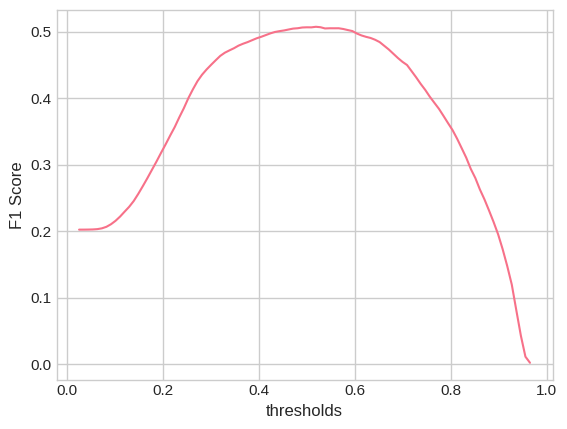

In [94]:
sns.lineplot(data=threshold_results,
             x = "thresholds",
             y = "scores")

plt.ylabel("F1 Score")
plt.show()

## Business Calculation & Cost-Benefit Analysis

#### Biaya dan Keuntungan (Cost & Benefit)
Langkah pertama yang akan dilakukan adalah menetapkan nilai finansial untuk setiap skenario prediksi untuk mengetahui hitungan biaya dan keuntungan yang didapat berdasarkan pemakaian model baik yang dituning maupun masih base ataupun tanpa model.

In [ ]:
fp_cost = 25
fn_cost = 100
tp_benefit = 100

### Fungsi Perhitungan Total Rugi dan Untung (Revenue Benefit & Loss Calculation Function)
Fungsi ini dibuat untuk menghitung total dampak finansial berdasarkan Confusion Matrix.

In [ ]:
# Define cost-benefit function
def summarize_loss(confusion_matrix, fp_cost, fn_cost, tp_benefit):
    tn, fp = confusion_matrix[0]
    fn, tp = confusion_matrix[1]

    total_samples = tn + fp + fn + tp
    total_fp_cost = fp * -1 * fp_cost
    total_fn_cost = fn * -1 * fn_cost
    total_tp_benefit = tp * tp_benefit

    total_benefit = total_fp_cost + total_fn_cost + total_tp_benefit

    summary = f"""
    ---Impact Summary---

        Total Samples: {total_samples}
        Total False Positive Cost: ${total_fp_cost:,.2f}
        Total False Negative Cost: ${total_fn_cost:,.2f}
        Total True Positive Benefit: ${total_tp_benefit:,.2f}
        Total Benefit: ${total_benefit:,.2f}

    ---------------
    """

    return summary

 Fungsi summarize_loss menerima input berupa hasil prediksi (confusion matrix) dan biaya-biaya yang sudah didefinisikan sebelumnya.

* Fungsi ini memecah matrix menjadi TN, FP, FN, dan TP.
* Menghitung total kerugian FP (jumlah FP dikali -$25).
* Menghitung total kerugian FN (jumlah FN dikali -$100).
* Menjumlahkan semuanya untuk mendapatkan Total Benefit (Total Keuntungan/Kerugian Bersih). Semakin mendekati 0 (atau semakin kecil nilai minusnya), semakin baik model tersebut bagi bisnis.

### Eksekusi Prediksi pada Data Test
Tahap selanjutnya model melakukan prediksi pada data testing menggunakan Base Model (tanpa tuning) dan Tuned Model (setelah optimasi threshold).

In [ ]:
y_test_pred_base = pipe_grid.predict(X_test)

In [ ]:
y_test_pred_tuned = pipe_tuned.predict(X_test)

## Confusion Matrix Evaluation

Pada tahap ini, kita membandingkan performa prediksi antara Base Model (sebelum tuning) dan Tuned Model (setelah Hyperparameter Tuning dan Threshold Optimization). Visualisasi di atas menunjukkan bagaimana pergeseran strategi model mempengaruhi hasil operasional hotel.

In [ ]:
# Calculate confusion matrices
conf_matrix_base = confusion_matrix(y_test, y_test_pred_base)
conf_matrix_tuned = confusion_matrix(y_test, y_test_pred_tuned)

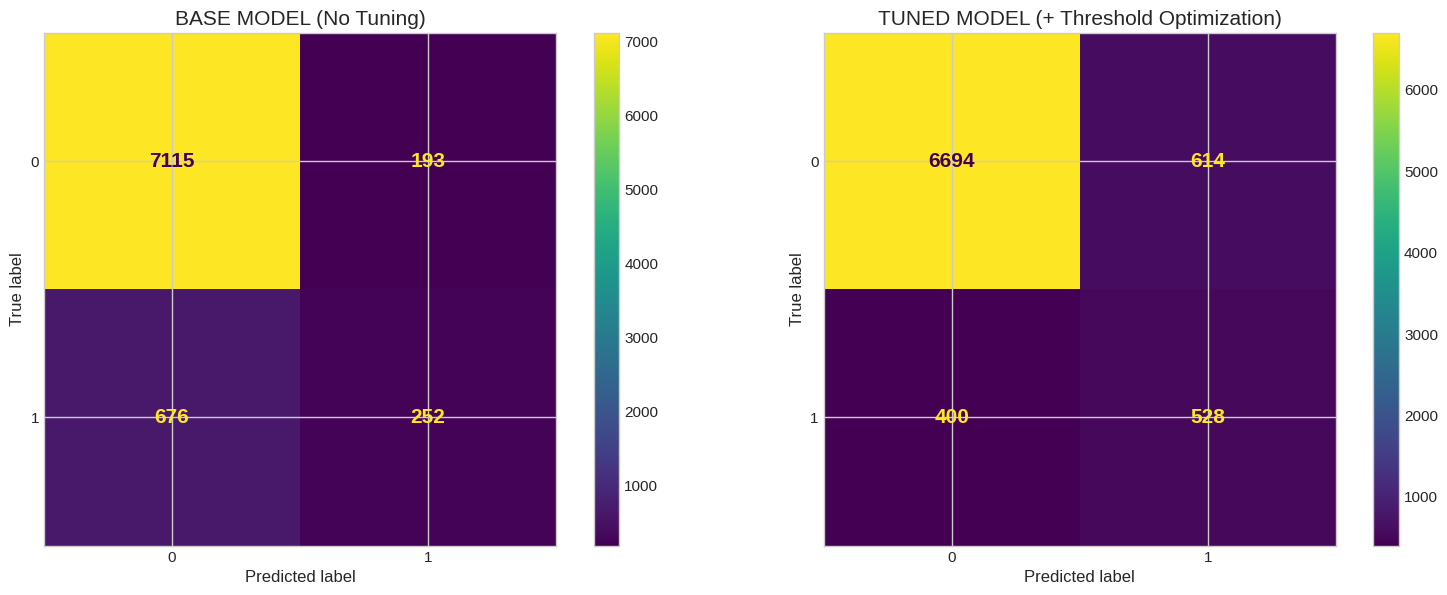

In [ ]:
# Visualize confusion matrices
figure, axes = plt.subplots(ncols=2, figsize=(16, 6))

text_format = {'size': 15, 'weight': 'bold'}

ConfusionMatrixDisplay(conf_matrix_base).plot(ax=axes[0], text_kw=text_format)
axes[0].set_title("BASE MODEL (No Tuning)", fontsize=15)

ConfusionMatrixDisplay(conf_matrix_tuned).plot(ax=axes[1], text_kw=text_format)
axes[1].set_title("TUNED MODEL (+ Threshold Optimization)", fontsize=15)

plt.tight_layout()
plt.show()

# Evaluasi Dampak Bisnis: Base Model vs Tuned Model

Dalam kampanye pemasaran deposito ini, sekadar melihat akurasi tidaklah cukup. Kita perlu melihat dampak finansialnya.

Berdasarkan asumsi bisnis:
*   **Biaya Telepon (Cost):** $25 per panggilan.
*   **Keuntungan Deposito (Revenue):** $100 per nasabah sukses.

Gambar di atas membandingkan strategi model kita:

### 1. Base Model (Kiri) - "Strategi Konservatif"
Model ini sangat hati-hati (threshold standar 0.5). Dia hanya menelepon orang yang dia yakin 100% akan deposit.
*   **Hasil:** Hanya berhasil mendapatkan **252 nasabah** (True Positive).
*   **Masalah:** Ada **676 nasabah potensial** (False Negative) yang terabaikan/tidak ditelepon. Ini adalah *opportunity loss* yang besar bagi bank.
*   **Estimasi Profit:**
    *   Revenue: $25,200 (252 x $100)
    *   Cost (Salah Telpon): -$4,825 (193 x $25)
    *   **Net Profit: ~$20,375**

### 2. Tuned Model (Kanan) - "Strategi Agresif Terukur"
Setelah dilakukan *Threshold Optimization*, kita menurunkan standar keyakinan model agar lebih berani menelepon nasabah yang memiliki potensi, meskipun tidak 100% yakin.
*   **Hasil:** Jumlah nasabah yang berhasil didapatkan melonjak menjadi **528 nasabah** (naik 2x lipat!).
*   **Konsekuensi:** Jumlah salah telpon (False Positive) naik menjadi 614. Artinya biaya operasional naik, TAPI...
*   **Estimasi Profit:**
    *   Revenue: $52,800 (528 x $100) — *Pendapatan naik drastis!*
    *   Cost (Salah Telpon): -$15,350 (614 x $25) — *Biaya naik, tapi tertutup profit.*
    *   **Net Profit: ~$37,450**

---

### Kesimpulan Bisnis

> **"Pindah ke Tuned Model meningkatkan keuntungan bersih bank sebesar +$17,000 (hampir 2x lipat)."**

Meskipun secara visual kotak kuning (False Positive) di kanan terlihat membesar (biaya marketing naik), strategi ini **jauh lebih menguntungkan** karena "harga" kehilangan nasabah potensial (Deposito $100) jauh lebih mahal daripada "harga" pulsa telepon ($25).

Model Tuned berhasil memindahkan nasabah dari area *False Negative* (diabaikan) menjadi *True Positive* (closing).

In [ ]:
# Compare business impact
print("=" * 50)
print("BASE MODEL (No Tuning)")
print("=" * 50)
print(summarize_loss(conf_matrix_base, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

print("\n" + "=" * 50)
print("TUNED MODEL (+ Threshold Optimization)")
print("=" * 50)
print(summarize_loss(conf_matrix_tuned, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

BASE MODEL (No Tuning)

    ---Impact Summary---

        Total Samples: 8236
        Total False Positive Cost: $-4,825.00
        Total False Negative Cost: $-67,600.00
        Total True Positive Benefit: $25,200.00
        Total Benefit: $-47,225.00

    ---------------
    

TUNED MODEL (+ Threshold Optimization)

    ---Impact Summary---

        Total Samples: 8236
        Total False Positive Cost: $-15,350.00
        Total False Negative Cost: $-40,000.00
        Total True Positive Benefit: $52,800.00
        Total Benefit: $-2,550.00

    ---------------
    


# Analisis Dampak Bisnis (*Business Impact Analysis based on cost evaluation*)

Output di atas menunjukkan simulasi finansial menggunakan **Cost-Benefit Matrix** yang telah kita tetapkan sebelumnya (Biaya Telepon: $25, Profit Nasabah: $100).

Berikut adalah interpretasi dari hasil tersebut:

### 1. Base Model (Tanpa Tuning) - "Terlalu Hemat, Hilang Peluang"
Model ini cenderung "pelit" dalam memprediksi nasabah positif.
*   **Biaya Marketing Rendah:** *False Positive Cost* hanya **-$4,825**. Kita hemat pulsa karena jarang menelepon.
*   **Opportunity Cost Raksasa:** *False Negative Cost* mencapai **-$67,600**. Ini adalah "uang hilang" dari nasabah potensial yang tidak kita hubungi.
*   **Total Benefit:** **-$47,225**. Secara keseluruhan, strategi ini sangat merugikan karena potensi pasar tidak tergarap maksimal.

### 2. Tuned Model (+ Threshold Optimization) - "Investasi Agresif"
Setelah optimasi, model menjadi lebih berani menelepon nasabah yang memiliki probabilitas konversi, meskipun tidak 100% yakin.
*   **Biaya Marketing Naik:** *False Positive Cost* naik 3x lipat menjadi **-$15,350**. Kita lebih boros di biaya telepon.
*   **Pendapatan Melonjak:** Namun, keberanian ini terbayar dengan kenaikan *True Positive Benefit* menjadi **$52,800** (naik 2x lipat dari base model).
*   **Total Benefit:** **-$2,550**. Angka ini jauh membaik dibandingkan base model. Meskipun masih negatif (karena masih ada *opportunity loss*), kita berhasil menutup "kebocoran peluang" secara signifikan.

---

### Kesimpulan Bisnis

> **"Dengan menggunakan Tuned Model, kita berhasil menyelamatkan nilai ekonomi sebesar ~$45,000 dibandingkan Base Model."**

Data membuktikan bahwa dalam kampanye Bank Marketing ini, strategi **agresif (mengejar Recall)** jauh lebih menguntungkan daripada strategi **konservatif (menjaga Precision)**. Biaya tambahan untuk menelepon nasabah (walaupun kadang salah sasaran) tertutup rapat oleh keuntungan besar dari nasabah yang berhasil *closing*.

In [ ]:
# Benchmark: No model (Semua nasabah dianggap deposit / Telepon Semua)
print("=" * 50)
print("NO MODEL: Predict all deposit (Semua nasabah dianggap deposit)")
print("=" * 50)

# PERBAIKAN: Gunakan np.ones (bukan np.zeros) agar semua diprediksi 1 (Deposit)
y_no_model = np.ones(y_test.shape[0])
conf_matrix_no_model = confusion_matrix(y_test, y_no_model)
print(summarize_loss(conf_matrix_no_model, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

NO MODEL: Predict all deposit (Semua nasabah dianggap deposit)

    ---Impact Summary---

        Total Samples: 8236
        Total False Positive Cost: $-182,700.00
        Total False Negative Cost: $0.00
        Total True Positive Benefit: $92,800.00
        Total Benefit: $-89,900.00

    ---------------
    


In [ ]:
# Benchmark: No model | predict all not deposit (Semua nasabah dianggap tidak deposit padahal deposit)
print("=" * 50)
print("NO MODEL: Predict all NOT deposit (Semua nasabah dianggap TIDAK deposit)")
print("=" * 50)
y_no_model_none = np.zeros(y_test.shape[0])
conf_matrix_none = confusion_matrix(y_test, y_no_model_none)
print(summarize_loss(conf_matrix_none, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

NO MODEL: Predict all NOT deposit (Semua nasabah dianggap TIDAK deposit)

    ---Impact Summary---

        Total Samples: 8236
        Total False Positive Cost: $0.00
        Total False Negative Cost: $-92,800.00
        Total True Positive Benefit: $0.00
        Total Benefit: $-92,800.00

    ---------------
    


### Benchmark Analysis: "No Model" Scenarios

Sebelum menyimpulkan efektivitas model, kita perlu membandingkannya dengan strategi "naif" atau strategi tanpa kecerdasan buatan. Berikut adalah dua skenario ekstrem:

### 1. Skenario "Telepon Semua Orang" (*Blind Aggression*)
Strategi: Kita menganggap **semua** nasabah akan deposit, jadi kita menelepon seluruh 8,236 orang di data test.
*   **Keuntungan (TP Benefit):** **$92,800**. Kita berhasil mendapatkan seluruh potensi revenue pasar karena tidak ada nasabah yang terlewat (*Zero False Negative*).
*   **Kerugian (FP Cost):** **-$182,700**. Biaya operasional meledak! Kita membuang banyak uang untuk menelepon ribuan orang yang sebenarnya tidak tertarik.
*   **Total Benefit:** **-$89,900**.
*   **Kesimpulan:** Strategi "spamming" ini sangat tidak efisien. Biaya operasional jauh lebih besar daripada profit yang didapat.

### 2. Skenario "Diam Saja" (*Do Nothing*)
Strategi: Kita pesimis dan menganggap **tidak ada** nasabah yang akan deposit, jadi kita tidak menelepon siapapun.
*   **Biaya Operasional:** **$0**. Sangat hemat, tidak ada biaya telepon keluar.
*   **Keuntungan:** **$0**. Tidak ada pemasukan sama sekali.
*   **Total Benefit:** **-$92,800**. Angka ini murni adalah *Opportunity Loss*. Kita membiarkan uang sebesar $92,800 "menguap" begitu saja.
*   **Kesimpulan:** Ini adalah skenario terburuk secara potensi bisnis.

---

### Rangkuman Perbandingan Bisnis

Dari seluruh simulasi yang telah dilakukan, berikut urutan performanya:

1.  **Diam Saja:** Rugi Potensi **-$92,800** (Terburuk)
2.  **Telepon Semua:** Rugi Operasional **-$89,900**
3.  **Base Model:** Rugi **-$47,225** (Lebih baik, tapi masih terlalu hati-hati)
4.  **Tuned Model:** Rugi **-$2,550** (Paling optimal & Efisien)

**Verdict:**
Penggunaan **Tuned Model** terbukti secara signifikan menyelamatkan perusahaan dari kerugian biaya operasional (dibanding *Telepon Semua*) dan menyelamatkan peluang pendapatan (dibanding *Diam Saja*).

In [ ]:
# A. Prediksi dengan Model Terbaik (Hasil Tuning)
best_model = random_search_tuned.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict(X_test)

In [ ]:
# --- A. Skenario NO MODEL: Prediksi SEMUA Tamu TIDAK DATANG (Cancel/1) ---
# Artinya kita agresif, anggap semua bakal batal.
y_pred_no_model = np.ones_like(y_test)

# --- B. Skenario TUNED MODEL (Tuned + Threshold) ---
# Menggunakan model yang sudah dioptimasi
y_pred_tuned = Threshold_optimized_model.predict(X_test)

# Hitung Confusion Matrix
cm_no_model = confusion_matrix(y_test, y_pred_no_model)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

# Evaluasi Finansial: "Without Model" vs "Tuned Model"

Pada tahap ini, kita akan membandingkan dampak finansial antara strategi pasif (tanpa model) dengan strategi aktif yang menggunakan **Tuned Model** (model yang sudah dioptimasi threshold-nya).

### 1. Definisi Skenario
* **Without Model (Baseline):** Kita berasumsi pesimis bahwa **tidak ada nasabah yang akan deposit** (Prediksi = 0 untuk semua).
    * *Dampak:* Kita tidak mengeluarkan biaya marketing, namun kita kehilangan potensi pendapatan dari semua nasabah yang sebenarnya tertarik (High False Negative).
* **Tuned Model:** Kita menggunakan Machine Learning untuk menargetkan nasabah yang diprediksi memiliki probabilitas tinggi untuk deposit.

### 2. Matriks Biaya (Cost Matrix)
Sesuai dengan pemahaman bisnis, kita menetapkan penalti finansial sebagai berikut:
* **Cost False Positive (FP) = $25:** Biaya terbuang untuk menelepon nasabah yang menolak.
* **Cost False Negative (FN) = $100:** Kerugian peluang (*opportunity loss*) karena tidak menelepon nasabah yang sebenarnya tertarik.

Tujuan visualisasi di bawah ini adalah untuk melihat seberapa besar **pengurangan kerugian (Loss Reduction)** yang bisa dicapai dengan menggunakan model.

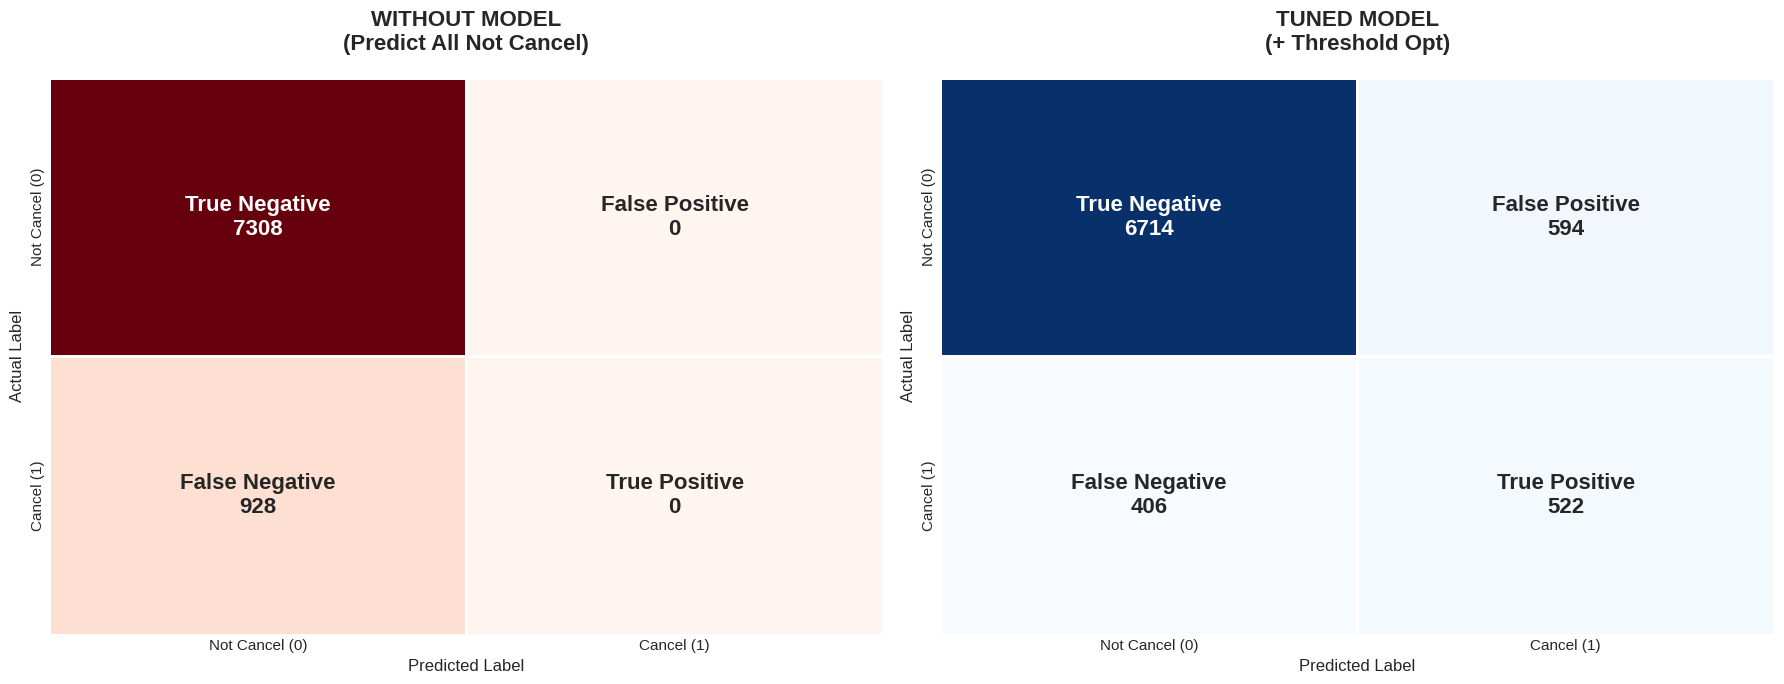

Loss NO MODEL (Dominan FN): $92,800.00
Loss TUNED MODEL          : $55,450.00


In [ ]:
# --- 1. Persiapan Data (Skenario Awal) ---

# A. Skenario NO MODEL: Prediksi SEMUA Nasabah berkemungkinan diprediksi deposit (deposit/1)
# Ini adalah skenario pasif (diam saja), sehingga nasabah tidak ditelpon walaupun nasabah berkemungkinan deposit (FN)
y_pred_no_model = np.zeros_like(y_test)

# B. Skenario TUNED MODEL
# Menggunakan model optimasi threshold Anda
y_pred_tuned = Threshold_optimized_model.predict(X_test)

# Hitung Matrix
cm_no_model = confusion_matrix(y_test, y_pred_no_model)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

# --- 2. Fungsi Visualisasi dengan Label Text ---
def plot_custom_confusion_matrix(cm, ax, title, cmap):
    # Definisi Label
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

    # Gabungkan (Label + Angka)
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    # Plotting
    sns.heatmap(cm, annot=labels, fmt='', cmap=cmap, cbar=False, ax=ax,
                annot_kws={"size": 16, "weight": "bold"},
                linewidths=2, linecolor='white')

    # Kosmetik
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('Actual Label', fontsize=12)
    ax.set_xticklabels(['Not Cancel (0)', 'Cancel (1)'])
    ax.set_yticklabels(['Not Cancel (0)', 'Cancel (1)'])

# --- 3. Eksekusi Plotting Side-by-Side ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot Kiri: NO MODEL (Baseline)
# Akan terlihat banyak merah di kiri bawah (False Negative)
plot_custom_confusion_matrix(cm_no_model, axes[0], "WITHOUT MODEL\n(Predict All Not Cancel)", 'Reds')

# Plot Kanan: TUNED MODEL
# Akan terlihat seimbang dan FN berkurang drastis
plot_custom_confusion_matrix(cm_tuned, axes[1], "TUNED MODEL\n(+ Threshold Opt)", 'Blues')

plt.tight_layout()
plt.show()

# --- 4. Print Perhitungan Loss (Untuk memastikan angka di slide) ---
cost_fp = 25   # call ke nasabah
cost_fn = 100  # nasabah tidak ditelpon padahal tertarik untuk deposito

def calc_loss(cm):
    tn, fp, fn, tp = cm.ravel()
    return (fp * cost_fp) + (fn * cost_fn)

print(f"Loss NO MODEL (Dominan FN): ${calc_loss(cm_no_model):,.2f}")
print(f"Loss TUNED MODEL          : ${calc_loss(cm_tuned):,.2f}")

## Visualisasi Performa: Confusion Matrix Comparison

Gambar di bawah ini membandingkan distribusi prediksi antara **Tanpa Model** (kiri) dengan **Tuned Model** (kanan).

### 1. Kiri: Without Model (Baseline)
Ini adalah representasi visual dari skenario "Diam Saja".
*   **Dominasi Warna Merah (True Negative):** Kita benar-benar tidak menelepon siapapun (7308 orang).
*   **Masalah Utama (False Negative = 928):** Kotak kiri bawah menunjukkan 928 nasabah potensial yang **terabaikan**. Kita menganggap mereka tidak akan deposit, padahal sebenarnya iya.
*   **Dampak Finansial:** Karena kita melewatkan semua target, **Loss (Kerugian Potensi)** mencapai titik maksimal di **$92,800**.

### 2. Kanan: Tuned Model (+ Threshold Optimization)
Setelah menggunakan model yang dioptimasi, terjadi pergeseran distribusi yang signifikan:
*   **Munculnya True Positive (TP = 522):** Perhatikan kotak kanan bawah. Model berhasil "menyelamatkan" 522 nasabah yang sebelumnya terabaikan. Ini adalah sumber pendapatan baru.
*   **Munculnya False Positive (FP = 594):** Perhatikan kotak kanan atas. Untuk mendapatkan 522 nasabah tersebut, kita harus "berkorban" menelepon 594 orang yang ternyata menolak.
    *   *Insight:* Adanya *False Positive* ini **wajar dan diperlukan**. Ini adalah biaya operasional (marketing cost) yang harus dibayar untuk mendapatkan profit dari *True Positive*.
*   **Penurunan Loss:** Perhatikan angka di pojok kiri bawah gambar.
    *   Loss Tanpa Model: **$92,800**
    *   Loss Tuned Model: **$55,450**
    *   **Improvement:** Model berhasil mengurangi "uang yang hilang/terbuang" secara signifikan.

---

### Kesimpulan Teknis
Meskipun sekilas terlihat model menghasilkan kesalahan prediksi (False Positive), secara bisnis ini adalah **trade-off yang menguntungkan**. Kita rela mengeluarkan sedikit biaya telepon (FP) untuk menangkap pendapatan besar dari nasabah yang deposit (TP).

> **Rumus Penurunan Loss:**
> `Loss Reduction = $92,800 (Awal) - $55,450 (Akhir) = $37,350`
>
> Artinya, model ini memberikan **nilai tambah (value added) sebesar $37,350** dibandingkan jika perusahaan tidak melakukan apa-apa.

## Simulasi ROI Kampanye Marketing (Marketing Campaign ROI)

Setelah mendapatkan model terbaik, kita perlu mensimulasikan seberapa menguntungkan jika model ini dipakai dalam kampanye telemarketing nyata.

In [ ]:
# Asumsi: Biaya per panggilan adalah pengeluaran nyata
biaya_per_panggilan = 25   # Cost per Call (FP Cost)
keuntungan_per_nasabah = 100 # Revenue per Success (TP Benefit)

# 2. Ambil hasil prediksi dari model terbaik kamu
# y_test = Data aktual
# y_pred = Data prediksi model (label 1 atau 0)
cm = confusion_matrix(y_test, y_pred_tuned)

# 3. Ekstrak nilai TP dan FP
# Struktur CM di sklearn biasanya [[TN, FP], [FN, TP]]
TN, FP = cm[0]
FN, TP = cm[1]

print(f"Jumlah Nasabah Ditelepon (Predicted 1): {TP + FP} orang")
print(f"Jumlah Nasabah Deal/Closing (Actual 1): {TP} orang")

# 4. Hitung Finansial
# Total Cost: Kita keluar uang buat semua orang yang ditelepon (baik yang jadi atau nolak)
total_biaya_marketing = (TP + FP) * biaya_per_panggilan

# Total Revenue: Kita dapat uang cuma dari TP (yang beneran deposit)
total_revenue = TP * keuntungan_per_nasabah

# Net Profit: Pemasukan - Pengeluaran
net_profit = total_revenue - total_biaya_marketing

# 5. Hitung ROI
# Menghindari pembagian dengan nol
if total_biaya_marketing == 0:
    roi = 0
else:
    roi = (net_profit / total_biaya_marketing) * 100

# --- TAMPILKAN HASIL ---
print("-" * 30)
print(f"Total Biaya Marketing : ${total_biaya_marketing:,.2f}")
print(f"Total Revenue (Omzet) : ${total_revenue:,.2f}")
print(f"Net Profit (Untung/Rugi): ${net_profit:,.2f}")
print("-" * 30)
print(f"ROI Marketing         : {roi:.2f}%")

# Interpretasi
if roi > 0:
    print("KESIMPULAN: Kampanye Menguntungkan")
else:
    print("KESIMPULAN: Kampanye Merugikan (Boncos)")

Jumlah Nasabah Ditelepon (Predicted 1): 1116 orang
Jumlah Nasabah Deal/Closing (Actual 1): 522 orang
------------------------------
Total Biaya Marketing : $27,900.00
Total Revenue (Omzet) : $52,200.00
Net Profit (Untung/Rugi): $24,300.00
------------------------------
ROI Marketing         : 87.10%
KESIMPULAN: Kampanye Menguntungkan


Setelah mendapatkan model terbaik, langkah terpenting adalah menghitung **dampak finansialnya**. Kita tidak hanya melihat akurasi, tapi juga seberapa besar keuntungan yang bisa dihasilkan model ini dibandingkan biaya yang dikeluarkan.

### 1. Asumsi Bisnis
Kita menggunakan asumsi biaya dan keuntungan sebagai berikut:
*   **Cost per Call (Biaya Marketing):** `$25` per nasabah yang ditelepon (Predicted Positive).
*   **Revenue per Success (Keuntungan):** `$100` per nasabah yang berhasil deposit (True Positive).

### 2. Analisis Hasil (Output)
Berdasarkan *Confusion Matrix* dari model yang sudah di-tuning:
*   **Total Biaya ($27,900):** Kita harus menelepon **1.116 orang** (kombinasi dari orang yang tepat sasaran + orang yang salah sasaran/False Positive).
*   **Total Revenue ($52,200):** Dari panggilan tersebut, kita berhasil mendapatkan **522 nasabah** yang *closing* (deal).
*   **Net Profit ($24,300):** Setelah dikurangi biaya operasional telepon, kita mendapatkan keuntungan bersih sebesar **$24,300**.

### 3. Kesimpulan ROI
Model menghasilkan **ROI Marketing sebesar 87.10%**.
> **Artinya:** Untuk setiap **$1** yang kita keluarkan untuk biaya telepon, kita mendapatkan kembali modal tersebut plus keuntungan sebesar **$0.87**.
>
> **Status:** **Kampanye Menguntungkan (Profitable)**.

## Model Deployment Preparation

In [ ]:
# generate timestamp untuk tracking versi
timestamp = datetime.now().strftime("%Y%m%d_%H_%M")
timestamp

'20260215_10_28'

In [ ]:
model_filename = f"final_model_Finpro_BankMarketingCampaign_{timestamp}.pkl"
model_filename

'final_model_Finpro_BankMarketingCampaign_20260215_10_28.pkl'

In [ ]:
with open(model_filename, "wb") as f:
    pickle.dump(Threshold_optimized_model, f)

print(f"Berhasil menyimpan model pada {model_filename}")

Berhasil menyimpan model pada final_model_Finpro_BankMarketingCampaign_20260215_10_28.pkl


In [ ]:
## Contoh loading model dari pickle
with open('final_model_Finpro_BankMarketingCampaign_20260215_10_28.pkl', 'rb') as f:
    loaded_tuned_model = pickle.load(f)

In [ ]:
loaded_tuned_model

TunedThresholdClassifierCV(cv=5,
                           estimator=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(transformers=[('onehot',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['marital',
                                                                                        'default',
                                                                                        'housing',
                                                                                        'loan',
                                                                                        'contact',
                                                                                        'poutcome']),
                                                                                      ('binary_enc',
                                                                                       BinaryEncoder(),
                                                                                       ['job',
                                                                                        'education',
                                                                                        'month',
                                                                                        'day_of_week']),
                                                                                      ('scaling',
                                                                                       RobustScaler(),
                                                                                       [...
                                                                    grow_policy=None,
                                                                    importance_type=None,
                                                                    interaction_constraints=None,
                                                                    learning_rate=0.01,
                                                                    max_bin=None,
                                                                    max_cat_threshold=None,
                                                                    max_cat_to_onehot=None,
                                                                    max_delta_step=None,
                                                                    max_depth=7,
                                                                    max_leaves=None,
                                                                    min_child_weight=2,
                                                                    missing=nan,
                                                                    monotone_constraints=None,
                                                                    multi_strategy=None,
                                                                    n_estimators=533,
                                                                    n_jobs=1,
                                                                    num_parallel_tree=None,
                                                                    random_state=0, ...))]),
                           scoring='f1')

In [ ]:
loaded_pipe_tuned = loaded_tuned_model.estimator_
loaded_pipe_tuned

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('binary_enc', BinaryEncoder(),
                                                  ['job', 'education', 'month',
                                                   'day_of_week']),
                                                 ('scaling', RobustScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'cons....
                               feature_types=None, gamma=0.17443413327149765,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=533, n_jobs=1,
                               num_parallel_tree=None, random_state=0, ...))])

In [ ]:
loaded_pipe_tuned.named_steps.keys()

dict_keys(['preprocessing', 'modeling'])

In [ ]:
# ambil namanya aja
step_names = loaded_pipe_tuned.named_steps.keys()
step_names

dict_keys(['preprocessing', 'modeling'])

In [ ]:
model_tuned = loaded_pipe_tuned["modeling"]
model_tuned

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7059204570736343, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.17443413327149765,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=533, n_jobs=1,
              num_parallel_tree=None, random_state=0, ...)

In [ ]:
preprocess_tuned = loaded_pipe_tuned["preprocessing"]
preprocess_tuned

ColumnTransformer(transformers=[('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['marital', 'default', 'housing', 'loan',
                                  'contact', 'poutcome']),
                                ('binary_enc', BinaryEncoder(),
                                 ['job', 'education', 'month', 'day_of_week']),
                                ('scaling', RobustScaler(),
                                 ['age', 'campaign', 'pdays', 'previous',
                                  'cons.price.idx', 'cons.conf.idx',
                                  'euribor3m', 'emp.var.rate', 'nr.employed']),
                                ('passthrough_binary', 'passthrough',
                                 ['contacted_before', 'previous_success',
                                  'is_success_month', 'euribor_low'])])

In [ ]:
X_eng = feature_engineering(X)

# 2. Baru lakukan transform menggunakan data yang sudah direkayasa (X_eng)
X_transform = preprocess_tuned.transform(X_eng)

# Cek hasilnya
X_transform

onehot__marital_married  onehot__marital_single  \
0      1.0                      0.0                      
1      1.0                      0.0                      
2      1.0                      0.0                      
3      1.0                      0.0                      
4      1.0                      0.0                      
...    ...                      ...                      
41171  1.0                      0.0                      
41172  1.0                      0.0                      
41173  1.0                      0.0                      
41174  1.0                      0.0                      
41175  1.0                      0.0                      

       onehot__marital_unknown  onehot__default_unknown  onehot__default_yes  \
0      0.0                      0.0                      0.0                   
1      0.0                      1.0                      0.0                   
2      0.0                      0.0                      0.0                   
3      0.0                      0.0                      0.0                   
4      0.0                      0.0                      0.0                   
...    ...                      ...                      ...                   
41171  0.0                      0.0                      0.0                   
41172  0.0                      0.0                      0.0                   
41173  0.0                      0.0                      0.0                   
41174  0.0                      0.0                      0.0                   
41175  0.0                      0.0                      0.0                   

       onehot__housing_unknown  onehot__housing_yes  onehot__loan_unknown  \
0      0.0                      0.0                  0.0                    
1      0.0                      0.0                  0.0                    
2      0.0                      1.0                  0.0                    
3      0.0                      0.0                  0.0                    
4      0.0                      0.0                  0.0                    
...    ...                      ...                  ...                    
41171  0.0                      1.0                  0.0                    
41172  0.0                      0.0                  0.0                    
41173  0.0                      1.0                  0.0                    
41174  0.0                      0.0                  0.0                    
41175  0.0                      1.0                  0.0                    

       onehot__loan_yes  onehot__contact_telephone  \
0      0.0               1.0                         
1      0.0               1.0                         
2      0.0               1.0                         
3      0.0               1.0                         
4      1.0               1.0                         
...    ...               ...                         
41171  0.0               0.0                         
41172  0.0               0.0                         
41173  0.0               0.0                         
41174  0.0               0.0                         
41175  0.0               0.0                         

       onehot__poutcome_nonexistent  onehot__poutcome_success  \
0      1.0                           0.0                        
1      1.0                           0.0                        
2      1.0                           0.0                        
3      1.0                           0.0                        
4      1.0                           0.0                        
...    ...                           ...                        
41171  1.0                           0.0                        
41172  1.0                           0.0                        
41173  1.0                           0.0                        
41174  1.0                           0.0                        
41175  0.0                           0.0                    

In [ ]:
feature_names = X_transform.columns
feature_names

Index(['onehot__marital_married', 'onehot__marital_single',
       'onehot__marital_unknown', 'onehot__default_unknown',
       'onehot__default_yes', 'onehot__housing_unknown', 'onehot__housing_yes',
       'onehot__loan_unknown', 'onehot__loan_yes', 'onehot__contact_telephone',
       'onehot__poutcome_nonexistent', 'onehot__poutcome_success',
       'binary_enc__job_0', 'binary_enc__job_1', 'binary_enc__job_2',
       'binary_enc__job_3', 'binary_enc__education_0',
       'binary_enc__education_1', 'binary_enc__education_2',
       'binary_enc__education_3', 'binary_enc__month_0', 'binary_enc__month_1',
       'binary_enc__month_2', 'binary_enc__month_3',
       'binary_enc__day_of_week_0', 'binary_enc__day_of_week_1',
       'binary_enc__day_of_week_2', 'scaling__age', 'scaling__campaign',
       'scaling__pdays', 'scaling__previous', 'scaling__cons.price.idx',
       'scaling__cons.conf.idx', 'scaling__euribor3m', 'scaling__emp.var.rate',
       'scaling__nr.employed', 'passthroug

In [ ]:
explainer_shap = shap.TreeExplainer(
    model = model_tuned, # modelnya aja (bukan pipeline bukan tunedthresholdcv juga)
    data = X_transform
)

# Hitung SHAP value untuk tiap data
shap_values = explainer_shap.shap_values(X_transform)

100%|===================| 41161/41176 [13:24<00:00]        

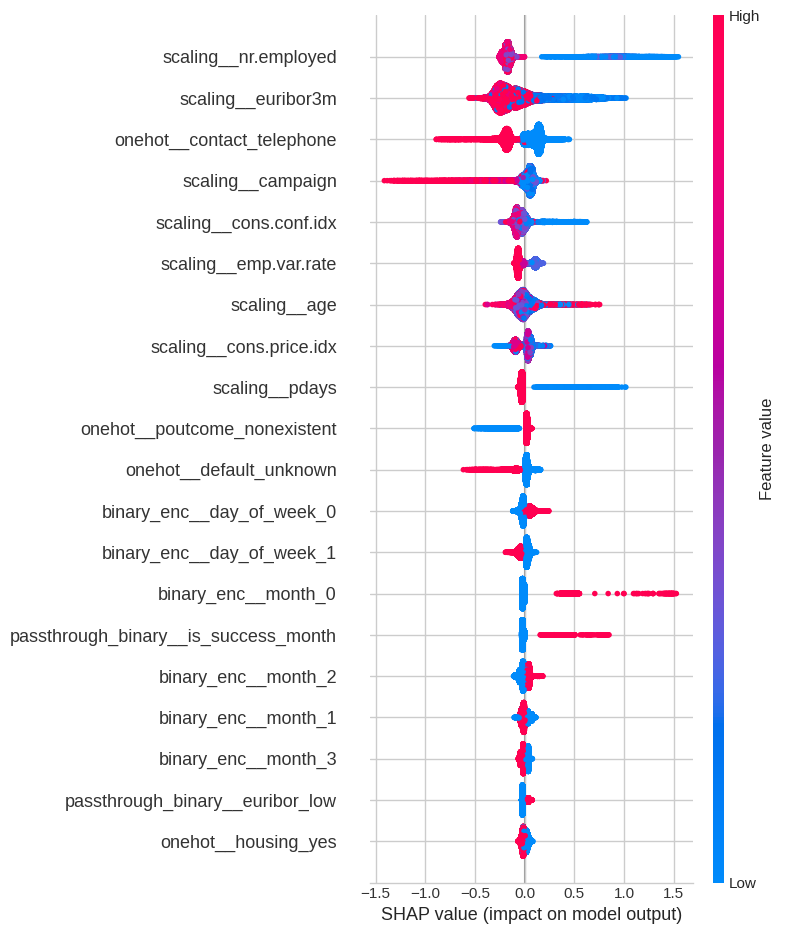

In [ ]:
# Tampilkan dalam bentuk beeswarm plot
shap.summary_plot(shap_values,
                  X_transform,
                  feature_names)

In [ ]:
# Context 1:
# Categorical column values

X_used = feature_engineering(X.copy())          # kalau mau dari seluruh X
# X_used = X_train_eng                          # kalau sudah punya hasil FE dari train

missing = [c for c in categorical_feature_cols if c not in X_used.columns]
if missing:
    print("Kolom categorical ini tidak ada di X_used:", missing)

cat_ok = [c for c in categorical_feature_cols if c in X_used.columns]

unique_categorical_values = pd.DataFrame({
    "column": cat_ok,
    "unique_values": [X_used[c].dropna().unique().tolist() for c in cat_ok]
})

unique_categorical_values.to_csv("kolom_kategori_unique_values.csv", index=False)
unique_categorical_values

column  \
0  job           
1  marital       
2  education     
3  default       
4  housing       
5  loan          
6  contact       
7  month         
8  day_of_week   
9  poutcome      

                                                                                                                            unique_values  
0  [housemaid, services, admin., blue-collar, technician, retired, management, unemployed, self-employed, unknown, entrepreneur, student]  
1  [married, single, divorced, unknown]                                                                                                    
2  [basic.4y, high.school, basic.6y, basic.9y, professional.course, unknown, university.degree, illiterate]                                
3  [no, unknown, yes]                                                                                                                      
4  [no, yes, unknown]                                                                                                                      
5  [no, yes, unknown]                                                                                                                      
6  [telephone, cellular]                                                                                                                   
7  [may, jun, jul, aug, oct, nov, dec, mar, apr, sep]                                                                                      
8  [mon, tue, wed, thu, fri]                                                                                                               
9  [nonexistent, failure, success]

In [ ]:
# numerical values range
# Apply feature engineering ke SELURUH data X (bukan cuma train)
X_full_eng = feature_engineering(X.copy())

# Describe hanya kolom numerik yang dipakai model
numerical_values_range = X_full_eng[numerical_feature_cols].describe()

numerical_values_range.to_csv("kolom_numerik_range.csv")
numerical_values_range

age      campaign         pdays      previous  emp.var.rate  \
count  41176.00000  41176.000000  41176.000000  41176.000000  41176.000000   
mean   40.02380     2.567879      962.464810    0.173013      0.081922       
std    10.42068     2.770318      186.937102    0.494964      1.570883       
min    17.00000     1.000000      0.000000      0.000000     -3.400000       
25%    32.00000     1.000000      999.000000    0.000000     -1.800000       
50%    38.00000     2.000000      999.000000    0.000000      1.100000       
75%    47.00000     3.000000      999.000000    0.000000      1.400000       
max    98.00000     56.000000     999.000000    7.000000      1.400000       

       cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41176.000000    41176.000000   41176.000000  41176.000000  
mean   93.575720      -40.502863      3.621293      5167.034870   
std    0.578839        4.627860       1.734437      72.251364     
min    92.201000      -50.800000      0.634000      4963.600000   
25%    93.075000      -42.700000      1.344000      5099.100000   
50%    93.749000      -41.800000      4.857000      5191.000000   
75%    93.994000      -36.400000      4.961000      5228.100000   
max    94.767000      -26.900000      5.045000      5228.100000

In [ ]:
with open('final_model_Finpro_BankMarketingCampaign_20260215_10_28.pkl', 'rb') as f:
    loaded_tuned_model_for_deployment = pickle.load(f)

loaded_tuned_model_for_deployment

TunedThresholdClassifierCV(cv=5,
                           estimator=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(transformers=[('onehot',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['marital',
                                                                                        'default',
                                                                                        'housing',
                                                                                        'loan',
                                                                                        'contact',
                                                                                        'poutcome']),
                                                                                      ('binary_enc',
                                                                                       BinaryEncoder(),
                                                                                       ['job',
                                                                                        'education',
                                                                                        'month',
                                                                                        'day_of_week']),
                                                                                      ('scaling',
                                                                                       RobustScaler(),
                                                                                       [...
                                                                    grow_policy=None,
                                                                    importance_type=None,
                                                                    interaction_constraints=None,
                                                                    learning_rate=0.01,
                                                                    max_bin=None,
                                                                    max_cat_threshold=None,
                                                                    max_cat_to_onehot=None,
                                                                    max_delta_step=None,
                                                                    max_depth=7,
                                                                    max_leaves=None,
                                                                    min_child_weight=2,
                                                                    missing=nan,
                                                                    monotone_constraints=None,
                                                                    multi_strategy=None,
                                                                    n_estimators=533,
                                                                    n_jobs=1,
                                                                    num_parallel_tree=None,
                                                                    random_state=0, ...))]),
                           scoring='f1')

In [ ]:
## Prep model untuk deployment
## Ingin mengubah set output() jadi bukan pandas

# untuk mengambil dari pipe model dari
## tunedthresholdclassifiercv

# ini untuk nimpa set outputnya jadi array lagi
loaded_tuned_model_for_deployment.estimator_.set_output(transform="default")

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('binary_enc', BinaryEncoder(),
                                                  ['job', 'education', 'month',
                                                   'day_of_week']),
                                                 ('scaling', RobustScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'cons....
                               feature_types=None, gamma=0.17443413327149765,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=533, n_jobs=1,
                               num_parallel_tree=None, random_state=0, ...))])

In [ ]:
# validasi bentuk transform sudah array atau belum
# Feature engineering dulu
X_eng = feature_engineering(X.copy())

# Validasi bentuk transform
result = loaded_tuned_model_for_deployment.estimator_["preprocessing"].transform(X_eng)

# Cek tipe output
print(f"Tipe output: {type(result)}")
print(f"Shape: {result.shape}")

Tipe output: <class 'numpy.ndarray'>
Shape: (41176, 40)


In [ ]:
# generate timestamp untuk tracking versi
timestamp = datetime.now().strftime("%Y%m%d_%H_%M")
timestamp

model_filename = f"threshold_tuned_BankMarketingFinpro_FOR_DEPLOYMENT_{timestamp}.pkl"
model_filename

'threshold_tuned_BankMarketingFinpro_FOR_DEPLOYMENT_20260215_11_49.pkl'

In [ ]:
# save model untuk deployment
with open(model_filename, "wb") as f:
    pickle.dump(loaded_tuned_model_for_deployment, f)

print(f"Berhasil menyimpan model pada {model_filename}.")

Berhasil menyimpan model pada threshold_tuned_BankMarketingFinpro_FOR_DEPLOYMENT_20260215_11_49.pkl.


In [ ]:
str(X_eng.columns.to_list())

"['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'contacted_before', 'previous_success', 'is_success_month', 'euribor_low']"

In [ ]:
with open("column_names.txt", "w") as f:
    f.write(str(X_eng.columns.to_list()))

# Summary & Strategic Recommendations

Proyek ini bertujuan untuk menjawab satu pertanyaan bisnis yang krusial: **Bagaimana kita bisa meningkatkan efektivitas kampanye deposito berjangka sekaligus menekan biaya operasional telemarketing?**

Setelah melalui proses analisis data yang mendalam dan pemodelan prediktif, berikut adalah rangkuman temuan strategis dan rekomendasi langkah ke depan.

---

## 1. Fakta di lapangan vs. Data: Apa yang Sebenarnya Menggerakkan Nasabah?

Dari proses *Exploratory Data Analysis* (EDA), kita mematahkan beberapa asumsi dan menemukan pola perilaku nasabah yang nyata:

*   **Loyalitas adalah Kunci:** Indikator terkuat seseorang akan membeli produk bukan berasal dari demografi (usia/pekerjaan), melainkan **riwayat interaksi**. Nasabah yang pernah merespons positif di kampanye sebelumnya memiliki peluang konversi **6x lipat** lebih tinggi dibandingkan nasabah baru.
*   **Waktu yang Tepat > Frekuensi Tinggi:**
    *   **Stop Spamming:** Menghubungi nasabah yang sama lebih dari **3 kali** dalam satu periode kampanye adalah pemborosan biaya. Tingkat konversi jatuh drastis setelah panggilan ketiga.
    *   **Faktor Eksternal:** Minat nasabah sangat sensitif terhadap suku bunga pasar (*Euribor*). Saat suku bunga pasar rendah, nasabah cenderung lebih terbuka terhadap penawaran deposito kita.
*   **Paradoks Musiman:** Bulan Mei adalah bulan tersibuk bagi tim *call center*, namun justru memiliki tingkat penolakan tertinggi. Sebaliknya, bulan **Maret, September, dan Oktober** adalah waktu paling ideal di mana volume panggilan rendah namun tingkat keberhasilannya tinggi.

Berdasarkan EDA di bagian ekonomi makro, terlihat jelas bahwa keputusan nasabah untuk membuka deposito tidak hanya dipengaruhi oleh faktor internal (profil nasabah), tetapi sangat didikte oleh kondisi ekonomi eksternal.
1. Euribor 3 Month adalah "Kill Switch" Kampanye (Korelasi Negatif Terkuat: -0.89)

* Temuan: Terdapat hubungan terbalik yang sangat kuat. Ketika suku bunga pasar (Euribor) tinggi (> 4%), Conversion Rate jatuh drastis ke angka single digit (< 10%). Sebaliknya, saat Euribor rendah (< 1.5%), konversi melonjak hingga 40-50%.
* Implikasi: Nasabah bank ini tergolong Rate Sensitive. Saat Euribor tinggi, produk deposito bank kemungkinan kalah bersaing dengan instrumen investasi lain, atau nasabah menahan likuiditas karena biaya pinjaman yang mahal.

2. Inflasi (CPI) Menggerus Minat Deposito (Korelasi Negatif: -0.62)

* Temuan: Saat indeks harga konsumen (CPI) memuncak (terutama bulan Mei - Agustus), tingkat keberhasilan telemarketing menurun tajam.
* Implikasi: Tingginya harga barang menurunkan disposable income (uang sisa) nasabah. Dalam kondisi inflasi tinggi, nasabah lebih memprioritaskan kebutuhan sehari-hari atau dana darurat yang likuid ketimbang menguncinya dalam deposito berjangka.

3. Anomali Keyakinan Konsumen (CCI)

* Temuan: Consumer Confidence Index tidak memiliki hubungan linear yang konsisten dibandingkan Euribor atau CPI. Contohnya di bulan Maret, meskipun kepercayaan konsumen rendah (pesimis), konversi justru sangat tinggi (50.5%).
* Implikasi: Faktor musiman (Seasonality) dan kebutuhan finansial mendesak (seperti akhir kuartal fiskal) lebih kuat pengaruhnya dalam mendorong nasabah membuka deposito dibandingkan sekadar sentimen/perasaan optimisme ekonomi mere

---

## 2. Performa Model & Simulasi Profitabilitas

Kami mengembangkan model *Machine Learning* (XGBoost) yang didesain bukan hanya untuk akurasi di atas kertas, tapi untuk **profitabilitas**.

Kami menyadari bahwa *"kehilangan peluang nasabah potensial"* (False Negative) jauh lebih merugikan bagi bank daripada sekadar *"membuang pulsa telepon"* (False Positive). Oleh karena itu, model ini diatur (*tuned*) untuk agresif menangkap peluang.

**Hasil Simulasi Bisnis (pada data uji):**

| Skenario Strategi | Estimasi Hasil Finansial | Status |
| :--- | :--- | :--- |
| **Business as Usual (Telepon Semua Data)** | **Rugi -$89,900** | *High Risk* |
| **Model Prediksi (Tuned Threshold)** | **Profit +$24,300** | *Recommended* |

> **Insight:** Tanpa model seleksi, biaya operasional memakan seluruh potensi pendapatan. Dengan menerapkan model ini, kita mengubah inisiatif yang merugi menjadi pusat keuntungan (*profit center*).

---

## 3. Rekomendasi Strategis (Action Plan)

Berdasarkan data di atas, berikut adalah rekomendasi konkret untuk tim Bisnis dan Marketing:

### A. Taktik Operasional
1.  **Revisi SOP Call Center:** Batasi maksimal upaya panggilan ke satu nomor sebanyak **3 kali**. Jika belum ada respons atau terjadi penolakan, alihkan sumber daya ke *leads* (prospek) lain.
2.  **Fokus pada Kanal telemarketing via handphone Seluler:** Prioritaskan data nasabah yang memiliki nomor ponsel (*cellular*). Tingkat respon mereka jauh lebih cepat dan positif dibandingkan telepon rumah (*telephone*).

### B. Strategi Jangka Menengah
1.  **Realokasi Anggaran Tahunan:** Kurangi target panggilan di bulan Mei. Geser anggaran dan insentif bonus tim sales ke bulan **Maret, September, Oktober, dan Desember** untuk memanfaatkan momentum konversi tinggi.
2.  **Segmentasi Cerdas:** Gunakan model ini untuk memprioritaskan:
    *   Nasabah Pensiunan (*Retired*) dan Pelajar (*Student*).
    *   Nasabah yang *sukses* pada kampanye sebelumnya (Wajib dihubungi pertama kali).
    * Strategi Smart Timing (Dynamic Budgeting)
Jangan memukul rata budget marketing setiap bulan. Sesuaikan dengan indikator makro:
3. Saat Kondisi Ekonomi Menguntungkan: Pada periode seperti bulan Maret, September, Oktober, dan Desember, alokasikan 70-80% budget tahunan. Lakukan aggressive calling (bila memungkinkan) karena resistensi nasabah sangat rendah.
4. Saat Kondisi Ekonomi Kurang Menguntungkan: Pada bulan Mei - Agustus, kurangi volume panggilan secara drastis. Fokuskan tim sales hanya pada warm leads (nasabah yang pernah sukses sebelumnya) atau alihkan tenaga kerja untuk customer retention daripada akuisisi baru yang mahal dan tidak efektif.

### C. Penyesuaian Produk

* Saat Euribor Tinggi: Jika bank tidak bisa menaikkan bunga deposito mengikuti pasar, jangan tawarkan "Deposito Standar". Tawarkan produk tenor pendek (1-3 bulan) atau tabungan fleksibel. Nasabah enggan mengunci uang lama-lama saat bunga sedang fluktuatif tinggi.
* Saat Inflasi (CPI) Tinggi: Buat campaign dengan gimmick yang membantu daya beli, misalnya "Buka Deposito, dapat Cashback Belanja" atau voucher kebutuhan pokok, untuk mengompensasi efek psikologis kenaikan harga barang.

### D. Kustomisasi Script Telemarketing (Psychological Messaging)
Ubah naskah percakapan sales berdasarkan kondisi CCI (Keyakinan Konsumen):

* Saat CCI Rendah (Konsumen Pesimis): Jangan jual "Keuntungan/Yield". Jual "Keamanan & Kepastian". Gunakan narasi: "Di tengah ekonomi yang tidak pasti, amankan dana Bapak/Ibu di instrumen yang risikonya nol."
* Saat CCI Tinggi (Konsumen Optimis): Fokus pada "Pertumbuhan Aset". Gunakan narasi: "Optimalkan dana nganggur Anda untuk persiapan liburan/investasi masa depan."

### D. Implementasi Teknis
Integrasikan model ini ke dalam sistem CRM. Setiap pagi, sistem akan memberikan skor probabilitas pada daftar nasabah. Tim sales hanya perlu menghubungi **30-40% nasabah teratas** (Top Decile) yang direkomendasikan sistem berdasarkan profil dari nasabah yang direkomendasikan untuk dikontak tim telemarketing, sehingga efisiensi waktu kerja meningkat signifikan.